# CONFIGURATION SPÉCIFIQUE DFDC

In [2]:
import os
import json
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# Configuration constante
BASE_MODEL = 'VGG16'  # Utiliser VGG16 pour plus de stabilité
FEATURE_DIM = 512     # VGG16: 512 features
FRAMES_PER_VIDEO = 32
TOTAL_FEATURE_DIM = FRAMES_PER_VIDEO * FEATURE_DIM  # 32 * 512 = 16384

print(f"Configuration:")
print(f"- Modèle: {BASE_MODEL}")
print(f"- Features par frame: {FEATURE_DIM}")
print(f"- Frames par vidéo: {FRAMES_PER_VIDEO}")
print(f"- Total features: {TOTAL_FEATURE_DIM}")

Configuration:
- Modèle: VGG16
- Features par frame: 512
- Frames par vidéo: 32
- Total features: 16384


In [3]:
# Chemins DFDC Kaggle
BASE_PATH = "/kaggle/input/deepfake-detection-challenge"
TRAIN_SAMPLE_VIDEOS = os.path.join(BASE_PATH, "train_sample_videos")
TEST_VIDEOS = os.path.join(BASE_PATH, "test_videos")

# Vérification des données
print("Fichiers dans train_sample_videos:")
print(os.listdir(TRAIN_SAMPLE_VIDEOS)[:5])

print("\nFichiers dans test_videos:")
print(os.listdir(TEST_VIDEOS)[:5])

Fichiers dans train_sample_videos:
['eivxffliio.mp4', 'dwediigjit.mp4', 'asvcrfdpnq.mp4', 'dntkzzzcdh.mp4', 'dboxtiehng.mp4']

Fichiers dans test_videos:
['qooxnxqqjb.mp4', 'hierggamuo.mp4', 'ocgdbrgmtq.mp4', 'icbsahlivv.mp4', 'prhmixykhr.mp4']


In [4]:
def load_dfdc_metadata():
    """
    Charge et explore les métadonnées du dataset DFDC
    """
    metadata_path = os.path.join(TRAIN_SAMPLE_VIDEOS, "metadata.json")
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Conversion en DataFrame pour analyse
    metadata_df = pd.DataFrame.from_dict(metadata, orient='index')
    metadata_df['filename'] = metadata_df.index
    
    print(f"Nombre total de vidéos: {len(metadata_df)}")
    print(f"Répartition des classes:")
    print(metadata_df['label'].value_counts())
    
    return metadata_df, metadata

def prepare_training_data():
    """Prépare les données d'entraînement équilibrées"""
    # Liste de toutes les vidéos
    all_videos = [f for f in os.listdir(TRAIN_SAMPLE_VIDEOS) if f.endswith('.mp4')]
    
    print(f"Vidéos trouvées: {len(all_videos)}")
    
    # Séparation REAL/FAKE
    real_videos = [v for v in all_videos if metadata_dict.get(v, {}).get('label') == 'REAL']
    fake_videos = [v for v in all_videos if metadata_dict.get(v, {}).get('label') == 'FAKE']
    
    print(f"REAL: {len(real_videos)}, FAKE: {len(fake_videos)}")
    
    # Échantillonnage équilibré
    min_count = min(len(real_videos), len(fake_videos))
    if min_count == 0:
        print("Attention: une des classes est vide!")
        balanced_videos = all_videos
    else:
        balanced_real = np.random.choice(real_videos, min_count, replace=False)
        balanced_fake = np.random.choice(fake_videos, min_count, replace=False)
        balanced_videos = np.concatenate([balanced_real, balanced_fake])
    
    np.random.shuffle(balanced_videos)
    
    # Séparation train/validation (80/20)
    split_idx = int(0.8 * len(balanced_videos))
    train_videos = balanced_videos[:split_idx]
    val_videos = balanced_videos[split_idx:]
    
    print(f"Train: {len(train_videos)}, Validation: {len(val_videos)}")
    
    return train_videos, val_videos

# Chargement des métadonnées
print("Chargement des métadonnées...")
metadata_df, metadata_dict = load_dfdc_metadata()

# Affichage des premières lignes
print("\nAperçu des métadonnées:")
print(metadata_df.head())

# Préparation des données d'entraînement
print("\nPréparation des données d'entraînement...")
train_videos, val_videos = prepare_training_data()

Chargement des métadonnées...
Nombre total de vidéos: 400
Répartition des classes:
FAKE    323
REAL     77
Name: label, dtype: int64

Aperçu des métadonnées:
               label  split        original        filename
aagfhgtpmv.mp4  FAKE  train  vudstovrck.mp4  aagfhgtpmv.mp4
aapnvogymq.mp4  FAKE  train  jdubbvfswz.mp4  aapnvogymq.mp4
abarnvbtwb.mp4  REAL  train            None  abarnvbtwb.mp4
abofeumbvv.mp4  FAKE  train  atvmxvwyns.mp4  abofeumbvv.mp4
abqwwspghj.mp4  FAKE  train  qzimuostzz.mp4  abqwwspghj.mp4

Préparation des données d'entraînement...
Vidéos trouvées: 400
REAL: 77, FAKE: 323
Train: 123, Validation: 31


In [5]:
# class EfficientFeatureExtractor:
#     def __init__(self, frames_per_video=32):
#         self.frames_per_video = frames_per_video
#         self.feature_dim = 512  # VGG16 output pooling='avg'
#         self.total_feature_dim = self.frames_per_video * self.feature_dim

#         # Charger VGG16 une seule fois
#         self.base_model = tf.keras.applications.VGG16(
#             weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3)
#         )
#         self.base_model.trainable = False

#         print(f"✅ Extracteur performant initialisé: {self.total_feature_dim} features totales")

#     def extract_frame_features(self, frames):
#         """
#         Frames : liste de np.array BGR
#         Retour : array (Nframes, feature_dim)
#         """
#         try:
#             # Conversion BGR -> RGB + resize en batch
#             batch = np.stack([
#                 cv2.resize(cv2.cvtColor(f, cv2.COLOR_BGR2RGB), (224,224)).astype(np.float32)
#                 for f in frames
#             ], axis=0)
            
#             # Préprocessing VGG16
#             batch = tf.keras.applications.vgg16.preprocess_input(batch)
            
#             # Extraction features en batch
#             features = self.base_model(batch, training=False).numpy()  # shape=(N,512)
            
#             # Normalisation frame-level
#             mean = np.mean(features, axis=1, keepdims=True)
#             std = np.std(features, axis=1, keepdims=True)
#             std[std<1e-6] = 1.0
#             features = (features - mean) / std
            
#             return features  # shape=(Nframes, feature_dim)
#         except Exception as e:
#             return np.zeros((len(frames), self.feature_dim), dtype=np.float32)

#     def extract_video_features(self, video_path):
#         """Extraction ultra-rapide des features d’une vidéo"""
#         try:
#             cap = cv2.VideoCapture(video_path)
#             if not cap.isOpened():
#                 return np.zeros(self.total_feature_dim, dtype=np.float32)
            
#             total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
#             if total_frames <= 0:
#                 cap.release()
#                 return np.zeros(self.total_feature_dim, dtype=np.float32)

#             # Indices frames uniformes
#             if total_frames <= self.frames_per_video:
#                 frame_indices = list(range(total_frames))
#                 while len(frame_indices) < self.frames_per_video:
#                     frame_indices.append(frame_indices[-1])
#             else:
#                 frame_indices = np.linspace(0, total_frames-1, self.frames_per_video, dtype=int)
            
#             # Lecture frames en batch
#             frames = []
#             for idx in frame_indices:
#                 cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
#                 ret, frame = cap.read()
#                 if ret and frame is not None:
#                     frames.append(frame)
#                 else:
#                     frames.append(np.zeros((224,224,3), dtype=np.uint8))
#             cap.release()
            
#             # Extraction features batch
#             feats = self.extract_frame_features(frames)
            
#             # Concaténation en un vecteur unique
#             video_features = feats.flatten()
            
#             # Padding si nécessaire
#             if len(video_features) < self.total_feature_dim:
#                 pad = self.total_feature_dim - len(video_features)
#                 video_features = np.pad(video_features, (0, pad), mode='constant')
#             elif len(video_features) > self.total_feature_dim:
#                 video_features = video_features[:self.total_feature_dim]
            
#             return video_features.astype(np.float32)
#         except Exception:
#             return np.zeros(self.total_feature_dim, dtype=np.float32)

# # Test rapide
# print("Initialisation extracteur...")
# efficient_extractor = EfficientFeatureExtractor(frames_per_video=32)


import tensorflow as tf
import numpy as np
import cv2
from typing import List, Optional, Union
import pathlib

class EfficientFeatureExtractor:
    def __init__(self, frames_per_video: int = 32, model_name: str = 'VGG16'):
        """
        Extracteur de features vidéo optimisé avec TensorFlow 2.x
        
        Args:
            frames_per_video: Nombre de frames à extraire par vidéo
            model_name: Modèle de backbone ('VGG16', 'EfficientNetB0', 'EfficientNetB4', 
                       'EfficientNetB7', 'ResNet50', 'MobileNetV2')
        """
        self.frames_per_video = frames_per_video
        
        # Choix du modèle avec préprocessing approprié
        self.model_name = model_name
        self.base_model, self.preprocess_input, self.target_size = self._load_backbone(model_name)
        self.feature_dim = self.base_model.output_shape[-1]  # Dimension des features
        self.total_feature_dim = self.frames_per_video * self.feature_dim
        
        # Cache pour l'accélération
        self._frame_cache = {}
        self.cache_size = 1000
        
        # Optimisation avec tf.function pour l'inférence
        self._extract_batch = tf.function(self._extract_batch_internal)
        
        print(f"✅ Extracteur {model_name} initialisé: {self.total_feature_dim} features totales")
        print(f"   Feature dim par frame: {self.feature_dim}")
        print(f"   Taille d'entrée: {self.target_size}")
    
    def _load_backbone(self, model_name: str):
        """Charge le modèle de backbone avec les poids pré-entraînés"""
        if model_name == 'VGG16':
            target_size = (224, 224)
            base_model = tf.keras.applications.VGG16(
                weights='imagenet',
                include_top=False,
                pooling='avg',
                input_shape=(224, 224, 3)
            )
            preprocess_input = tf.keras.applications.vgg16.preprocess_input
            
        elif model_name == 'EfficientNetB0':
            target_size = (224, 224)
            base_model = tf.keras.applications.EfficientNetB0(
                weights='imagenet',
                include_top=False,
                pooling='avg',
                input_shape=(224, 224, 3)
            )
            preprocess_input = tf.keras.applications.efficientnet.preprocess_input
            
        elif model_name == 'EfficientNetB4':
            target_size = (380, 380)  # Taille recommandée pour B4
            base_model = tf.keras.applications.EfficientNetB4(
                weights='imagenet',
                include_top=False,
                pooling='avg',
                input_shape=(380, 380, 3)
            )
            preprocess_input = tf.keras.applications.efficientnet.preprocess_input
            
        elif model_name == 'EfficientNetB7':
            target_size = (600, 600)  # Taille recommandée pour B7
            base_model = tf.keras.applications.EfficientNetB7(
                weights='imagenet',
                include_top=False,
                pooling='avg',
                input_shape=(600, 600, 3)
            )
            preprocess_input = tf.keras.applications.efficientnet.preprocess_input
            
        elif model_name == 'ResNet50':
            target_size = (224, 224)
            base_model = tf.keras.applications.ResNet50(
                weights='imagenet',
                include_top=False,
                pooling='avg',
                input_shape=(224, 224, 3)
            )
            preprocess_input = tf.keras.applications.resnet.preprocess_input
            
        elif model_name == 'MobileNetV2':
            target_size = (224, 224)
            base_model = tf.keras.applications.MobileNetV2(
                weights='imagenet',
                include_top=False,
                pooling='avg',
                input_shape=(224, 224, 3)
            )
            preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
            
        else:
            raise ValueError(f"Modèle non supporté: {model_name}. Options: VGG16, EfficientNetB0, EfficientNetB4, EfficientNetB7, ResNet50, MobileNetV2")
        
        # Geler les couches du modèle
        base_model.trainable = False
        
        # Créer un modèle optimisé pour l'inférence
        input_tensor = tf.keras.Input(shape=(*target_size, 3))
        x = base_model(input_tensor, training=False)
        inference_model = tf.keras.Model(inputs=input_tensor, outputs=x)
        
        return inference_model, preprocess_input, target_size
    
    def _extract_batch_internal(self, batch: tf.Tensor) -> tf.Tensor:
        """Fonction interne pour l'extraction de features"""
        return self.base_model(batch, training=False)
    
    def _preprocess_frame(self, frame: np.ndarray) -> np.ndarray:
        """Prétraitement optimisé d'une frame"""
        # Utiliser le cache pour éviter les traitements répétés
        frame_hash = hash(frame.data.tobytes())
        if frame_hash in self._frame_cache:
            return self._frame_cache[frame_hash]
        
        # Conversion BGR -> RGB + resize
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        # Choisir l'interpolation en fonction du modèle
        if self.model_name in ['EfficientNetB4', 'EfficientNetB7']:
            # Pour les modèles plus grands, utiliser une meilleure interpolation
            frame_resized = cv2.resize(frame_rgb, self.target_size, interpolation=cv2.INTER_LANCZOS4)
        else:
            frame_resized = cv2.resize(frame_rgb, self.target_size)
        
        # Garder en mémoire pour éviter la reconversion
        self._frame_cache[frame_hash] = frame_resized
        
        # Nettoyer le cache si trop grand (FIFO)
        if len(self._frame_cache) > self.cache_size:
            # Retirer le plus ancien
            first_key = next(iter(self._frame_cache))
            del self._frame_cache[first_key]
        
        return frame_resized
    
    def extract_frame_features(self, frames: List[np.ndarray]) -> np.ndarray:
        """
        Extrait les features d'une liste de frames
        
        Args:
            frames: Liste de np.arrays BGR
            
        Returns:
            array (N_frames, feature_dim)
        """
        if not frames:
            return np.zeros((0, self.feature_dim), dtype=np.float32)
        
        try:
            # Prétraitement en batch
            batch = np.stack([self._preprocess_frame(f) for f in frames], axis=0)
            batch = batch.astype(np.float32)
            
            # Préprocessing spécifique au modèle
            batch = self.preprocess_input(batch)
            
            # Conversion en tensor
            batch_tensor = tf.convert_to_tensor(batch)
            
            # Extraction features avec tf.function optimisé
            features = self._extract_batch(batch_tensor).numpy()
            
            # Normalisation L2 par frame
            features = features / (np.linalg.norm(features, axis=1, keepdims=True) + 1e-8)
            
            return features
            
        except Exception as e:
            print(f"⚠️ Erreur lors de l'extraction: {e}")
            return np.zeros((len(frames), self.feature_dim), dtype=np.float32)
    
    def extract_video_features(self, video_path: Union[str, pathlib.Path]) -> np.ndarray:
        """
        Extraction optimisée des features d'une vidéo
        
        Args:
            video_path: Chemin vers le fichier vidéo
            
        Returns:
            Vecteur de features concaténé
        """
        video_path = str(video_path)
        
        try:
            # Ouvrir la vidéo
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                print(f"⚠️ Impossible d'ouvrir: {video_path}")
                return np.zeros(self.total_feature_dim, dtype=np.float32)
            
            # Obtenir les informations de la vidéo
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            
            if total_frames <= 0 or fps <= 0:
                cap.release()
                return np.zeros(self.total_feature_dim, dtype=np.float32)
            
            # Calculer les indices des frames à extraire
            frame_indices = self._calculate_frame_indices(total_frames, self.frames_per_video)
            
            # Lecture optimisée des frames
            frames = self._read_frames(cap, frame_indices, total_frames)
            cap.release()
            
            # Extraction des features
            features = self.extract_frame_features(frames)
            
            # Concaténation et padding si nécessaire
            video_features = self._flatten_and_pad(features)
            
            return video_features
            
        except Exception as e:
            print(f"❌ Erreur avec {video_path}: {e}")
            return np.zeros(self.total_feature_dim, dtype=np.float32)
    
    def _calculate_frame_indices(self, total_frames: int, n_frames: int) -> np.ndarray:
        """Calcule les indices des frames à extraire"""
        if total_frames <= n_frames:
            indices = list(range(total_frames))
            # Répéter la dernière frame si nécessaire
            while len(indices) < n_frames:
                indices.append(indices[-1] if indices else 0)
            return np.array(indices, dtype=int)
        else:
            # Extraction uniforme avec un léger décalage aléatoire pour la variabilité
            step = total_frames / n_frames
            indices = np.arange(0, total_frames, step, dtype=int)
            
            # S'assurer d'avoir exactement n_frames
            if len(indices) > n_frames:
                indices = indices[:n_frames]
            elif len(indices) < n_frames:
                indices = np.append(indices, [indices[-1]] * (n_frames - len(indices)))
            
            return indices
    
    def _read_frames(self, cap: cv2.VideoCapture, frame_indices: np.ndarray, 
                    total_frames: int) -> List[np.ndarray]:
        """Lecture optimisée des frames spécifiques"""
        frames = []
        height, width = None, None
        
        for idx in frame_indices:
            if idx >= total_frames:
                idx = total_frames - 1
            
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if ret and frame is not None:
                if height is None or width is None:
                    height, width = frame.shape[:2]
                frames.append(frame)
            else:
                # Créer une frame noire de la bonne taille
                if height is None or width is None:
                    # Essayer d'obtenir la taille depuis la vidéo
                    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                    if height <= 0 or width <= 0:
                        height, width = self.target_size[0], self.target_size[1]
                
                black_frame = np.zeros((height, width, 3), dtype=np.uint8)
                frames.append(black_frame)
        
        return frames
    
    def _flatten_and_pad(self, features: np.ndarray) -> np.ndarray:
        """Aplatit et complète les features si nécessaire"""
        video_features = features.flatten()
        current_dim = len(video_features)
        
        if current_dim < self.total_feature_dim:
            # Padding avec des zeros
            pad = self.total_feature_dim - current_dim
            video_features = np.pad(video_features, (0, pad), mode='constant')
        elif current_dim > self.total_feature_dim:
            # Tronquer si trop long (ne devrait pas arriver)
            video_features = video_features[:self.total_feature_dim]
        
        return video_features.astype(np.float32)
    
    def extract_multiple_videos(self, video_paths: List[Union[str, pathlib.Path]], 
                              batch_size: int = 4) -> np.ndarray:
        """
        Extraction batch de plusieurs vidéos
        
        Args:
            video_paths: Liste des chemins des vidéos
            batch_size: Taille du batch pour le traitement parallèle
            
        Returns:
            Array de shape (n_videos, total_feature_dim)
        """
        all_features = []
        
        for i in range(0, len(video_paths), batch_size):
            batch_paths = video_paths[i:i + batch_size]
            batch_features = []
            
            # Traitement parallèle avec ThreadPool
            import concurrent.futures
            with concurrent.futures.ThreadPoolExecutor(max_workers=batch_size) as executor:
                futures = [executor.submit(self.extract_video_features, path) 
                         for path in batch_paths]
                
                for future in concurrent.futures.as_completed(futures):
                    batch_features.append(future.result())
            
            all_features.extend(batch_features)
            
            if i % (batch_size * 5) == 0:
                print(f"📊 Traitement: {min(i+batch_size, len(video_paths))}/{len(video_paths)}")
        
        return np.array(all_features, dtype=np.float32)
    
    def save_features(self, features: np.ndarray, save_path: str):
        """Sauvegarde les features dans un fichier numpy"""
        np.save(save_path, features)
        print(f"💾 Features sauvegardées: {save_path}")
    
    def load_features(self, load_path: str) -> np.ndarray:
        """Charge les features depuis un fichier numpy"""
        features = np.load(load_path)
        print(f"📂 Features chargées: {load_path}, shape: {features.shape}")
        return features


# # Test et démonstration
# if __name__ == "__main__":
#     print("🚀 Test de l'extracteur de features avec différentes versions d'EfficientNet...")
#     print("="*70)
    
#     # Liste des modèles à tester
#     models_to_test = ['VGG16', 'EfficientNetB0', 'EfficientNetB4', 'EfficientNetB7', 'MobileNetV2']
    
#     for model_name in models_to_test:
#         print(f"\n{'='*60}")
#         print(f"🔧 Test avec {model_name}")
#         print('='*60)
        
#         try:
#             # Initialisation avec moins de frames pour le test
#             extractor = EfficientFeatureExtractor(frames_per_video=32, model_name=model_name)
            
#             # Test avec une frame de test
#             test_frame = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
            
#             # Mesurer le temps
#             import time
#             start_time = time.time()
            
#             features = extractor.extract_frame_features([test_frame])
#             elapsed = time.time() - start_time
            
#             # Afficher les informations
#             print(f"   📐 Dimension features: {features.shape[1]}D")
#             print(f"   📊 Total pour 8 frames: {extractor.total_feature_dim}D")
#             print(f"   🎯 Taille d'entrée: {extractor.target_size}")
#             print(f"   ⏱️  Temps extraction: {elapsed*1000:.1f}ms")
#             print(f"   📈 Feature range: [{features.min():.3f}, {features.max():.3f}]")
            
#             # Informations spécifiques pour les EfficientNets
#             if model_name.startswith('EfficientNet'):
#                 print(f"   🔍 Type: EfficientNet famille B")
                
#         except Exception as e:
#             print(f"   ❌ Erreur: {e}")
#             import traceback
#             traceback.print_exc()
    
#     print("\n" + "="*70)
#     print("✅ Tests terminés!")
#     print("="*70)
    
#     # Tableau comparatif
#     print("\n📋 TABLEAU COMPARATIF DES MODÈLES:")
#     print("="*70)
#     print(f"{'Modèle':<15} {'Taille entrée':<15} {'Features/frame':<15} {'Complexité':<15}")
#     print("-"*70)
    
#     comparative_data = [
#         ('MobileNetV2', '224×224', '1280', 'Très rapide'),
#         ('VGG16', '224×224', '512', 'Rapide'),
#         ('EfficientNetB0', '224×224', '1280', 'Rapide'),
#         ('EfficientNetB4', '380×380', '1792', 'Moyenne'),
#         ('EfficientNetB7', '600×600', '2560', 'Lente'),
#     ]
    
#     for model, size, feats, complexity in comparative_data:
#         print(f"{model:<15} {size:<15} {feats:<15} {complexity:<15}")
    
#     print("="*70)

In [6]:
import os
import numpy as np

# Paramètres (à adapter selon votre configuration)
TRAIN_SAMPLE_VIDEOS = "/kaggle/input/deepfake-detection-challenge/train_sample_videos" 
TOTAL_FEATURE_DIM = 32 * 2560  # 32 frames × 2560 features pour B7 = 81920

# Initialiser l'extracteur avec B7
print("🚀 Initialisation de l'extracteur avec EfficientNetB7...")
efficient_extractor = EfficientFeatureExtractor(
    frames_per_video=32,
    model_name='EfficientNetB7'
)

# Lister les vidéos disponibles
train_videos = [f for f in os.listdir(TRAIN_SAMPLE_VIDEOS) 
                if f.endswith(('.mp4', '.avi', '.mov', '.mkv'))]

print(f"📂 Nombre de vidéos trouvées: {len(train_videos)}")

# Test de l'extracteur sur une vidéo
def test_extractor_consistency():
    """Test la cohérence de l'extracteur"""
    if len(train_videos) > 0:
        test_video = train_videos[0]
        video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, test_video)
        
        print(f"\n🎬 Test de cohérence sur: {test_video}")
        print(f"📁 Chemin: {video_path}")
        
        # Mesurer le temps d'extraction
        import time
        start_time = time.time()
        
        features = efficient_extractor.extract_video_features(video_path)
        
        elapsed_time = time.time() - start_time
        
        # Afficher les résultats
        print(f"\n📊 RÉSULTATS DU TEST:")
        print(f"   ⏱️  Temps d'extraction: {elapsed_time:.2f} secondes")
        print(f"   📏 Dimension obtenue: {len(features)}")
        print(f"   📏 Dimension attendue: {TOTAL_FEATURE_DIM}")
        print(f"   📈 Shape: {features.shape}")
        print(f"   📊 Min/Max: [{features.min():.3f}, {features.max():.3f}]")
        print(f"   📊 Moyenne: {features.mean():.3f}, Std: {features.std():.3f}")
        
        # Vérifier la cohérence
        is_consistent = len(features) == TOTAL_FEATURE_DIM
        print(f"\n   {'✅' if is_consistent else '❌'} Test de cohérence: {'RÉUSSI' if is_consistent else 'ÉCHOUÉ'}")
        
        # Vérifier les zéros (pour détecter les erreurs d'extraction)
        zero_count = np.sum(features == 0)
        zero_percentage = (zero_count / len(features)) * 100
        print(f"   📉 Zéros dans les features: {zero_count} ({zero_percentage:.2f}%)")
        
        if zero_percentage > 50:
            print(f"   ⚠️  ATTENTION: Beaucoup de zéros, vérifiez la vidéo ou le chemin")
        
        return features, elapsed_time
    else:
        print("❌ Aucune vidéo trouvée dans le dossier spécifié")
        return None, None

# Exécuter le test
test_features, extraction_time = test_extractor_consistency()

# Test supplémentaire: vérifier plusieurs vidéos
def test_multiple_videos(n_videos=3):
    """Test sur plusieurs vidéos pour vérifier la robustesse"""
    if len(train_videos) >= n_videos:
        print(f"\n{'='*60}")
        print(f"🧪 TEST MULTIPLE ({n_videos} vidéos)")
        print('='*60)
        
        import time
        total_time = 0
        successful = 0
        
        for i in range(min(n_videos, len(train_videos))):
            video_name = train_videos[i]
            video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, video_name)
            
            print(f"\n🎬 Vidéo {i+1}/{n_videos}: {video_name}")
            
            try:
                start_time = time.time()
                features = efficient_extractor.extract_video_features(video_path)
                elapsed = time.time() - start_time
                
                if len(features) == TOTAL_FEATURE_DIM:
                    successful += 1
                    status = "✅"
                else:
                    status = "❌"
                
                print(f"   {status} Dimensions: {len(features)}/{TOTAL_FEATURE_DIM}")
                print(f"   ⏱️  Temps: {elapsed:.2f}s")
                total_time += elapsed
                
            except Exception as e:
                print(f"   ❌ Erreur: {e}")
        
        print(f"\n📈 RÉSUMÉ:")
        print(f"   Vidéos testées: {n_videos}")
        print(f"   Succès: {successful}/{n_videos}")
        print(f"   Temps total: {total_time:.2f}s")
        print(f"   Temps moyen par vidéo: {total_time/n_videos:.2f}s")
        print(f"   Taux de succès: {(successful/n_videos)*100:.1f}%")
        
        return successful == n_videos
    else:
        print(f"❌ Pas assez de vidéos pour tester ({len(train_videos)} disponible(s))")
        return False

# Exécuter le test multiple si désiré
if test_features is not None:
    run_multiple_test = input("\n🔍 Voulez-vous tester sur plusieurs vidéos? (o/n): ")
    if run_multiple_test.lower() == 'o':
        test_multiple_videos(min(3, len(train_videos)))

        
print("\n" + "="*60)
print("✅ Tests terminés avec EfficientNetB7!")
print("="*60)

🚀 Initialisation de l'extracteur avec EfficientNetB7...
258088960/258076736 [==============================] - 1s 0us/step
✅ Extracteur EfficientNetB7 initialisé: 81920 features totales
   Feature dim par frame: 2560
   Taille d'entrée: (600, 600)
📂 Nombre de vidéos trouvées: 400

🎬 Test de cohérence sur: eivxffliio.mp4
📁 Chemin: /kaggle/input/deepfake-detection-challenge/train_sample_videos/eivxffliio.mp4

📊 RÉSULTATS DU TEST:
   ⏱️  Temps d'extraction: 76.35 secondes
   📏 Dimension obtenue: 81920
   📏 Dimension attendue: 81920
   📈 Shape: (81920,)
   📊 Min/Max: [-0.027, 0.112]
   📊 Moyenne: 0.006, Std: 0.019

   ✅ Test de cohérence: RÉUSSI
   📉 Zéros dans les features: 0 (0.00%)



🔍 Voulez-vous tester sur plusieurs vidéos? (o/n):  n



✅ Tests terminés avec EfficientNetB7!


In [7]:
import os
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List, Tuple

# Chemins Kaggle spécifiques
TRAIN_SAMPLE_VIDEOS = "/kaggle/input/deepfake-detection-challenge/train_sample_videos"
TEST_VIDEOS = "/kaggle/input/deepfake-detection-challenge/test_videos"

def load_kaggle_metadata():
    """Charge les métadonnées depuis le fichier JSON Kaggle"""
    metadata_path = os.path.join(TRAIN_SAMPLE_VIDEOS, "metadata.json")
    
    if not os.path.exists(metadata_path):
        print(f"❌ Fichier metadata.json non trouvé: {metadata_path}")
        return {}
    
    try:
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
        
        print(f"✅ Métadonnées chargées: {len(metadata)} vidéos")
        
        # Compter les labels
        real_count = sum(1 for v in metadata.values() if v.get('label') == 'REAL')
        fake_count = sum(1 for v in metadata.values() if v.get('label') == 'FAKE')
        
        print(f"📊 Distribution: REAL={real_count}, FAKE={fake_count}")
        
        return metadata
    
    except Exception as e:
        print(f"❌ Erreur lors du chargement des métadonnées: {e}")
        return {}

def prepare_efficient_dataset(video_files: List[str], 
                             metadata: Dict,
                             extractor: EfficientFeatureExtractor,
                             data_dir: str,
                             use_cache: bool = True,
                             cache_file: str = None) -> Tuple[np.ndarray, np.ndarray]:
    """
    Préparation rapide et équilibrée du dataset avec EfficientNetB7
    
    Args:
        video_files: Liste des fichiers vidéo
        metadata: Dictionnaire des métadonnées
        extractor: Instance de EfficientFeatureExtractor avec B7
        data_dir: Répertoire contenant les vidéos (chaîne de caractères)
        use_cache: Utiliser le cache pour accélérer
        cache_file: Fichier pour sauvegarder/charger le cache
        
    Returns:
        Tuple (features, labels)
    """
    # Vérifier que data_dir est une chaîne de caractères
    if not isinstance(data_dir, str):
        print(f"❌ Erreur: data_dir doit être une chaîne de caractères, pas {type(data_dir)}")
        return np.array([]), np.array([])
    
    # Vérifier si le dossier existe
    if not os.path.exists(data_dir):
        print(f"❌ Dossier non trouvé: {data_dir}")
        return np.array([]), np.array([])
    
    # Vérifier si les vidéos existent
    existing_videos = []
    for v in video_files:
        video_path = os.path.join(data_dir, v)
        if os.path.exists(video_path):
            existing_videos.append(v)
        else:
            print(f"⚠️ Vidéo non trouvée: {video_path}")
    
    if len(existing_videos) == 0:
        print(f"❌ Aucune vidéo valide trouvée dans {data_dir}")
        return np.array([]), np.array([])
    
    # Séparation des classes
    real_videos = [v for v in existing_videos if metadata.get(v, {}).get('label') == 'REAL']
    fake_videos = [v for v in existing_videos if metadata.get(v, {}).get('label') == 'FAKE']
    
    print(f"📊 REAL: {len(real_videos)}, FAKE: {len(fake_videos)}")
    
    # Équilibrer les classes
    min_count = min(len(real_videos), len(fake_videos))
    
    if min_count == 0:
        print("❌ Une des classes est vide")
        return np.array([]), np.array([])
    
    # Sélection équilibrée
    selected_real = np.random.choice(real_videos, min_count, replace=False)
    selected_fake = np.random.choice(fake_videos, min_count, replace=False)
    balanced_videos = np.concatenate([selected_real, selected_fake])
    np.random.shuffle(balanced_videos)
    
    print(f"✅ Dataset équilibré: {len(balanced_videos)} vidéos")
    print(f"   ➕ REAL: {len(selected_real)}, FAKE: {len(selected_fake)}")
    
    # Vérifier le cache si activé
    cache_dict = {}
    if use_cache and cache_file and os.path.exists(cache_file):
        try:
            cache_dict = np.load(cache_file, allow_pickle=True).item()
            print(f"📂 Cache chargé: {cache_file} ({len(cache_dict)} entrées)")
        except:
            print("⚠️ Impossible de charger le cache")
    
    # Extraction des features
    features_list = []
    labels_list = []
    failed_videos = []
    
    progress_bar = tqdm(balanced_videos, desc=f"Extraction B7", unit="vid")
    
    for video_file in progress_bar:
        try:
            # Vérifier le cache
            cache_key = f"{data_dir}_{video_file}"
            if use_cache and cache_key in cache_dict:
                features = cache_dict[cache_key]
                cache_status = " (cache)"
            else:
                video_path = os.path.join(data_dir, video_file)
                
                # Vérifier la taille de la vidéo
                file_size = os.path.getsize(video_path) / (1024*1024)  # MB
                if file_size < 0.1:  # Vidéo trop petite
                    print(f"\n⚠️ Vidéo très petite: {video_file} ({file_size:.1f} MB)")
                    failed_videos.append(video_file)
                    continue
                
                # Extraire les features
                features = extractor.extract_video_features(video_path)
                
                # Vérifier la qualité des features
                if np.all(features == 0):
                    print(f"\n⚠️ Features nulles pour: {video_file}")
                    failed_videos.append(video_file)
                    continue
                
                # Sauvegarder dans le cache
                if use_cache:
                    cache_dict[cache_key] = features
                
                cache_status = ""
            
            # Vérifier la dimension
            expected_dim = extractor.total_feature_dim  # Pour B7: 81920
            if len(features) == expected_dim:
                # Récupérer le label
                label = 1 if metadata.get(video_file, {}).get('label') == 'FAKE' else 0
                
                features_list.append(features)
                labels_list.append(label)
                
                # Mettre à jour la description de la barre de progression
                progress_bar.set_postfix({
                    'réussies': len(features_list),
                    'échecs': len(failed_videos),
                    'cache': cache_status.strip()
                })
            else:
                print(f"\n⚠️ Dimension incorrecte pour {video_file}: {len(features)} vs {expected_dim}")
                failed_videos.append(video_file)
                
        except Exception as e:
            print(f"\n❌ Erreur avec {video_file}: {str(e)[:100]}")
            failed_videos.append(video_file)
            continue
    
    progress_bar.close()
    
    # Sauvegarder le cache si activé
    if use_cache and cache_file and cache_dict:
        np.save(cache_file, cache_dict)
        print(f"💾 Cache sauvegardé: {cache_file}")
    
    # Afficher les statistiques
    if features_list:
        X = np.array(features_list, dtype=np.float32)
        y = np.array(labels_list, dtype=np.int32)
        
        print(f"\n📊 STATISTIQUES D'EXTRACTION:")
        print(f"   ✅ Succès: {len(features_list)}/{len(balanced_videos)}")
        print(f"   ❌ Échecs: {len(failed_videos)}")
        print(f"   📏 Features shape: {X.shape}")
        print(f"   🔢 Labels distribution: {np.bincount(y)}")
        print(f"   📊 Ratio REAL/FAKE: {len(selected_real)}:{len(selected_fake)}")
        
        if len(failed_videos) > 0:
            print(f"\n⚠️ Vidéos en échec ({len(failed_videos)}):")
            for i, v in enumerate(failed_videos[:10]):  # Afficher seulement les 10 premières
                print(f"   {i+1}. {v}")
            if len(failed_videos) > 10:
                print(f"   ... et {len(failed_videos) - 10} autres")
        
        return X, y
    else:
        print("❌ Aucune feature extraite avec succès")
        return np.array([]), np.array([])

def split_train_val(video_files, metadata, val_ratio=0.2, random_seed=42):
    """
    Sépare les vidéos en ensembles train/validation de manière stratifiée
    
    Args:
        video_files: Liste des fichiers vidéo
        metadata: Dictionnaire des métadonnées
        val_ratio: Proportion pour la validation
        random_seed: Seed pour la reproductibilité
    """
    np.random.seed(random_seed)
    
    # Séparer par classe
    real_videos = [v for v in video_files if metadata.get(v, {}).get('label') == 'REAL']
    fake_videos = [v for v in video_files if metadata.get(v, {}).get('label') == 'FAKE']
    
    # Mélanger
    np.random.shuffle(real_videos)
    np.random.shuffle(fake_videos)
    
    # Calculer les tailles pour chaque classe
    real_val_size = int(len(real_videos) * val_ratio)
    fake_val_size = int(len(fake_videos) * val_ratio)
    
    # Séparer
    real_val = real_videos[:real_val_size]
    real_train = real_videos[real_val_size:]
    
    fake_val = fake_videos[:fake_val_size]
    fake_train = fake_videos[fake_val_size:]
    
    # Combiner
    train_videos = list(real_train) + list(fake_train)
    val_videos = list(real_val) + list(fake_val)
    
    # Mélanger les ensembles finaux
    np.random.shuffle(train_videos)
    np.random.shuffle(val_videos)
    
    print(f"\n📊 SPLIT TRAIN/VAL:")
    print(f"   TRAIN: {len(train_videos)} vidéos")
    print(f"     - REAL: {len(real_train)}")
    print(f"     - FAKE: {len(fake_train)}")
    print(f"   VAL: {len(val_videos)} vidéos")
    print(f"     - REAL: {len(real_val)}")
    print(f"     - FAKE: {len(fake_val)}")
    
    return train_videos, val_videos

# Exemple d'utilisation
if __name__ == "__main__":
    print("="*60)
    print("🎬 DEEPFAKE DETECTION - EXTRACTION EFFICIENTNET B7")
    print("="*60)
    
    # 1. Charger les métadonnées
    print("\n📋 Étape 1: Chargement des métadonnées...")
    metadata_dict = load_kaggle_metadata()
    
    if not metadata_dict:
        print("❌ Impossible de continuer sans métadonnées")
        exit()
    
    # 2. Lister toutes les vidéos disponibles
    print("\n📋 Étape 2: Liste des vidéos disponibles...")
    all_video_files = [f for f in metadata_dict.keys() 
                      if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv', '.webm'))]
    
    # Vérifier l'existence des fichiers
    existing_videos = []
    for v in all_video_files:
        video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, v)
        if os.path.exists(video_path):
            existing_videos.append(v)
        else:
            print(f"⚠️ Fichier manquant: {video_path}")
    
    print(f"📁 Vidéos dans metadata: {len(all_video_files)}")
    print(f"📁 Vidéos existantes: {len(existing_videos)}")
    
    # 3. Split train/validation
    print("\n📋 Étape 3: Split train/validation...")
    train_videos, val_videos = split_train_val(existing_videos, metadata_dict, val_ratio=0.2)
    
    print(f"\n📊 FINAL:")
    print(f"   TRAIN: {len(train_videos)} vidéos")
    print(f"   VAL: {len(val_videos)} vidéos")
    
    # 4. Préparation des datasets
    print("\n📋 Étape 4: Préparation des datasets...")
    
    # Initialiser l'extracteur B7
    extractor = EfficientFeatureExtractor(
        frames_per_video=32,
        model_name='EfficientNetB7'
    )
    
    print(f"📐 Configuration B7:")
    print(f"   - Features par frame: {extractor.feature_dim}")
    print(f"   - Features totales: {extractor.total_feature_dim}")
    print(f"   - Taille d'entrée: {extractor.target_size}")
    
    # Préparation du dataset d'entraînement
    print("\n" + "="*60)
    print("🎯 EXTRACTION TRAIN")
    print("="*60)
    
    X_train, y_train = prepare_efficient_dataset(
        train_videos,
        metadata_dict,
        extractor,
        TRAIN_SAMPLE_VIDEOS,  # Chaîne de caractères, pas liste
        use_cache=True,
        cache_file="kaggle_b7_train_cache.npy"
    )
    
    # Préparation du dataset de validation
    print("\n" + "="*60)
    print("🎯 EXTRACTION VALIDATION")
    print("="*60)
    
    X_val, y_val = prepare_efficient_dataset(
        val_videos,
        metadata_dict,
        extractor,
        TRAIN_SAMPLE_VIDEOS,  # Même dossier pour train et val
        use_cache=True,
        cache_file="kaggle_b7_val_cache.npy"
    )
    
    # 5. Résumé et sauvegarde
    if len(X_train) > 0 and len(X_val) > 0:
        print("\n" + "="*60)
        print("📋 RÉSUMÉ FINAL")
        print("="*60)
        
        print(f"📚 TRAIN:")
        print(f"   Samples: {len(X_train)}")
        print(f"   Features shape: {X_train.shape}")
        print(f"   Labels: {np.bincount(y_train)} (0=REAL, 1=FAKE)")
        
        print(f"\n🔍 VALIDATION:")
        print(f"   Samples: {len(X_val)}")
        print(f"   Features shape: {X_val.shape}")
        print(f"   Labels: {np.bincount(y_val)} (0=REAL, 1=FAKE)")
        
        # Sauvegarder les datasets
        print("\n💾 Sauvegarde des datasets...")
        
        np.savez_compressed(
            "deepfake_dataset_b7.npz",
            X_train=X_train,
            y_train=y_train,
            X_val=X_val,
            y_val=y_val,
            feature_dim=extractor.total_feature_dim,
            model_name="EfficientNetB7",
            frames_per_video=32,
            extraction_date=np.datetime64('now')
        )
        
        print(f"✅ Datasets sauvegardés: deepfake_dataset_b7.npz")
        print(f"   Taille totale: {(X_train.nbytes + X_val.nbytes) / (1024*1024):.2f} MB")
        
        # Sauvegarder aussi séparément
        np.save("X_train_b7.npy", X_train)
        np.save("y_train_b7.npy", y_train)
        np.save("X_val_b7.npy", X_val)
        np.save("y_val_b7.npy", y_val)
        
        print(f"\n📝 Fichiers créés:")
        print(f"   - X_train_b7.npy ({X_train.nbytes/(1024*1024):.2f} MB)")
        print(f"   - y_train_b7.npy")
        print(f"   - X_val_b7.npy ({X_val.nbytes/(1024*1024):.2f} MB)")
        print(f"   - y_val_b7.npy")
        print(f"   - deepfake_dataset_b7.npz (tous combinés)")
        
    else:
        print("\n❌ L'extraction a échoué ou n'a produit aucun résultat")

🎬 DEEPFAKE DETECTION - EXTRACTION EFFICIENTNET B7

📋 Étape 1: Chargement des métadonnées...
✅ Métadonnées chargées: 400 vidéos
📊 Distribution: REAL=77, FAKE=323

📋 Étape 2: Liste des vidéos disponibles...
📁 Vidéos dans metadata: 400
📁 Vidéos existantes: 400

📋 Étape 3: Split train/validation...

📊 SPLIT TRAIN/VAL:
   TRAIN: 321 vidéos
     - REAL: 62
     - FAKE: 259
   VAL: 79 vidéos
     - REAL: 15
     - FAKE: 64

📊 FINAL:
   TRAIN: 321 vidéos
   VAL: 79 vidéos

📋 Étape 4: Préparation des datasets...


Extraction B7:   0%|          | 0/124 [00:00<?, ?vid/s]

✅ Extracteur EfficientNetB7 initialisé: 81920 features totales
   Feature dim par frame: 2560
   Taille d'entrée: (600, 600)
📐 Configuration B7:
   - Features par frame: 2560
   - Features totales: 81920
   - Taille d'entrée: (600, 600)

🎯 EXTRACTION TRAIN
📊 REAL: 62, FAKE: 259
✅ Dataset équilibré: 124 vidéos
   ➕ REAL: 62, FAKE: 62


Extraction B7:   0%|          | 0/30 [00:00<?, ?vid/s]

💾 Cache sauvegardé: kaggle_b7_train_cache.npy

📊 STATISTIQUES D'EXTRACTION:
   ✅ Succès: 124/124
   ❌ Échecs: 0
   📏 Features shape: (124, 81920)
   🔢 Labels distribution: [62 62]
   📊 Ratio REAL/FAKE: 62:62

🎯 EXTRACTION VALIDATION
📊 REAL: 15, FAKE: 64
✅ Dataset équilibré: 30 vidéos
   ➕ REAL: 15, FAKE: 15


Extraction B7: 100%|██████████| 30/30 [37:11<00:00, 74.37s/vid, réussies=30, échecs=0, cache=]


💾 Cache sauvegardé: kaggle_b7_val_cache.npy

📊 STATISTIQUES D'EXTRACTION:
   ✅ Succès: 30/30
   ❌ Échecs: 0
   📏 Features shape: (30, 81920)
   🔢 Labels distribution: [15 15]
   📊 Ratio REAL/FAKE: 15:15

📋 RÉSUMÉ FINAL
📚 TRAIN:
   Samples: 124
   Features shape: (124, 81920)
   Labels: [62 62] (0=REAL, 1=FAKE)

🔍 VALIDATION:
   Samples: 30
   Features shape: (30, 81920)
   Labels: [15 15] (0=REAL, 1=FAKE)

💾 Sauvegarde des datasets...
✅ Datasets sauvegardés: deepfake_dataset_b7.npz
   Taille totale: 48.12 MB

📝 Fichiers créés:
   - X_train_b7.npy (38.75 MB)
   - y_train_b7.npy
   - X_val_b7.npy (9.38 MB)
   - y_val_b7.npy
   - deepfake_dataset_b7.npz (tous combinés)


In [8]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

# Note: Pour B7, input_dim = 2560 (features par frame)
# Pour 32 frames: input_shape = (32, 2560)

def create_optimized_lstm_for_b7(frames_per_video=32):
    """
    Modèle LSTM optimisé pour les features EfficientNetB7
    
    Args:
        frames_per_video: Nombre de frames par vidéo (32 par défaut)
    
    Returns:
        Modèle Keras compilé
    """
    # Pour EfficientNetB7: 2560 features par frame
    input_dim = 2560  # Spécifique à B7!
    sequence_length = frames_per_video
    
    print(f"🔧 Création du modèle LSTM pour B7:")
    print(f"   - Séquence: {sequence_length} frames")
    print(f"   - Features par frame: {input_dim}")
    print(f"   - Input shape: ({sequence_length}, {input_dim})")
    
    # Entrée: séquence de frames
    inputs = keras.Input(shape=(sequence_length, input_dim))
    
    # 1. Normalisation batch pour stabiliser l'entraînement
    x = keras.layers.BatchNormalization()(inputs)
    
    # 2. Première couche LSTM bidirectionnelle
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=512,  # Plus d'unités pour B7
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.2
        )
    )(x)
    
    # 3. Deuxième couche LSTM bidirectionnelle
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=256,  # Plus d'unités pour B7
            dropout=0.2,
            recurrent_dropout=0.2
        )
    )(x)
    
    # 4. Attention pour se concentrer sur les frames importantes
    attention = keras.layers.Dense(1, activation='tanh')(x)
    attention = keras.layers.Flatten()(attention)
    attention = keras.layers.Activation('softmax')(attention)
    attention = keras.layers.RepeatVector(256 * 2)(attention)  # 256 * 2 pour bidirectionnel
    attention = keras.layers.Permute([2, 1])(attention)
    x = keras.layers.multiply([x, attention])
    
    # 5. Couches denses avec régularisation
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    # 6. Couche de sortie
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    # Création du modèle
    model = keras.Model(inputs=inputs, outputs=outputs, name="LSTM_B7_Deepfake_Detector")
    
    # Optimiseur avec scheduling du learning rate
    optimizer = keras.optimizers.Adam(
        learning_rate=1e-3,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Compilation
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.TruePositives(name='tp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.FalseNegatives(name='fn')
        ]
    )
    
    return model

def create_hybrid_model_for_b7(frames_per_video=32):
    """
    Modèle hybride CNN + LSTM pour les features B7
    Plus complexe mais potentiellement plus performant
    """
    input_dim = 2560  # B7
    sequence_length = frames_per_video
    
    print(f"🔧 Création du modèle hybride pour B7:")
    print(f"   - Input shape: ({sequence_length}, {input_dim})")
    
    inputs = keras.Input(shape=(sequence_length, input_dim))
    
    # 1. CNN 1D pour extraire des patterns locaux dans les features
    x = keras.layers.Reshape((sequence_length, input_dim, 1))(inputs)
    
    # Convolutions 1D
    x = keras.layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.Conv1D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Retour à la forme séquentielle pour LSTM
    x = keras.layers.Reshape((sequence_length // 4, 128))(x)
    
    # 2. LSTM bidirectionnelle
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=256,
            return_sequences=True,
            dropout=0.3
        )
    )(x)
    
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128,
            dropout=0.3
        )
    )(x)
    
    # 3. Couches denses finales
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    # 4. Sortie
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="Hybrid_B7_Deepfake_Detector")
    
    # Optimiseur
    optimizer = keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0  # Pour éviter les gradients explosifs
    )
    
    # Compilation
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

def create_transformer_model_for_b7(frames_per_video=32):
    """
    Modèle Transformer moderne pour B7
    Utilise des mécanismes d'attention
    """
    input_dim = 2560  # B7
    sequence_length = frames_per_video
    
    print(f"🔧 Création du modèle Transformer pour B7:")
    print(f"   - Input shape: ({sequence_length}, {input_dim})")
    
    inputs = keras.Input(shape=(sequence_length, input_dim))
    
    # Positional Encoding (simplifié)
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    positions = keras.layers.Embedding(
        input_dim=sequence_length,
        output_dim=input_dim
    )(positions)
    
    x = inputs + positions
    
    # Multi-Head Attention
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=8,
        key_dim=input_dim // 8  # 2560 // 8 = 320
    )(x, x)
    
    # Skip connection + normalization
    x = keras.layers.Add()([x, attention_output])
    x = keras.layers.LayerNormalization()(x)
    
    # Feed Forward
    ffn = keras.Sequential([
        keras.layers.Dense(input_dim * 4, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(input_dim)
    ])
    
    ffn_output = ffn(x)
    
    # Skip connection + normalization
    x = keras.layers.Add()([x, ffn_output])
    x = keras.layers.LayerNormalization()(x)
    
    # Pooling global
    x = keras.layers.GlobalAveragePooling1D()(x)
    
    # Couches de classification
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="Transformer_B7_Deepfake_Detector")
    
    # Optimiseur avec warmup
    optimizer = keras.optimizers.Adam(
        learning_rate=keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=1e-4,
            decay_steps=1000
        )
    )
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model

def reshape_features_for_lstm(X, frames_per_video=32, features_per_frame=2560):
    """
    Remodeler les features aplaties en séquences pour LSTM
    
    Args:
        X: Features aplaties de shape (n_samples, total_features)
        frames_per_video: Nombre de frames par vidéo
        features_per_frame: Nombre de features par frame (2560 pour B7)
        
    Returns:
        X_reshaped: Features remodelées (n_samples, frames_per_video, features_per_frame)
    """
    expected_total = frames_per_video * features_per_frame
    
    # Vérifier la dimension
    if X.shape[1] != expected_total:
        print(f"⚠️ Attention: X shape {X.shape[1]} != attendu {expected_total}")
        print(f"   Redimensionnement automatique...")
        
        # Tronquer ou pad si nécessaire
        if X.shape[1] > expected_total:
            X = X[:, :expected_total]
            print(f"   Tronqué à {expected_total} features")
        else:
            padding = expected_total - X.shape[1]
            X = np.pad(X, ((0, 0), (0, padding)), mode='constant')
            print(f"   Padding ajouté: {padding} features")
    
    # Reshape en séquence
    X_reshaped = X.reshape(-1, frames_per_video, features_per_frame)
    
    print(f"✅ Features reshaped: {X.shape} -> {X_reshaped.shape}")
    print(f"   {X_reshaped.shape[0]} samples, {frames_per_video} frames, {features_per_frame} features/frame")
    
    return X_reshaped

def prepare_data_for_b7_model(X_train, X_val, frames_per_video=32):
    """
    Prépare les données pour le modèle B7
    
    Args:
        X_train: Features d'entraînement aplaties
        X_val: Features de validation aplaties
        frames_per_video: Nombre de frames
        
    Returns:
        X_train_seq, X_val_seq: Données remodelées
    """
    # Pour B7: 2560 features par frame
    features_per_frame = 2560
    
    print(f"📊 Préparation des données pour B7:")
    print(f"   Train shape avant: {X_train.shape}")
    print(f"   Val shape avant: {X_val.shape}")
    
    # Reshape des données
    X_train_seq = reshape_features_for_lstm(
        X_train, 
        frames_per_video=frames_per_video,
        features_per_frame=features_per_frame
    )
    
    X_val_seq = reshape_features_for_lstm(
        X_val,
        frames_per_video=frames_per_video,
        features_per_frame=features_per_frame
    )
    
    # Normalisation
    mean = X_train_seq.mean(axis=(0, 1), keepdims=True)
    std = X_train_seq.std(axis=(0, 1), keepdims=True) + 1e-8
    
    X_train_seq = (X_train_seq - mean) / std
    X_val_seq = (X_val_seq - mean) / std
    
    print(f"✅ Normalisation appliquée")
    print(f"   Mean: {mean.mean():.4f}, Std: {std.mean():.4f}")
    
    return X_train_seq, X_val_seq

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import os
from datetime import datetime

# CORRECTION 1: Modèle Hybrid corrigé
def create_hybrid_model_for_b7(frames_per_video=32):
    """
    Modèle hybride CNN + LSTM pour les features B7 - VERSION CORRIGÉE
    """
    input_dim = 2560  # B7
    sequence_length = frames_per_video
    
    print(f"🔧 Création du modèle hybride pour B7 (CORRIGÉ):")
    print(f"   - Input shape: ({sequence_length}, {input_dim})")
    
    inputs = keras.Input(shape=(sequence_length, input_dim))
    
    # 1. CNN 1D pour extraire des patterns locaux dans les features
    # PAS de Reshape en 4D pour Conv1D - Conv1D s'attend à 3D (batch, steps, features)
    x = inputs
    
    # Convolutions 1D - CORRECTION: input_shape déjà en 3D
    x = keras.layers.Conv1D(
        filters=64,
        kernel_size=3,
        padding='same',
        activation='relu'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    x = keras.layers.Conv1D(
        filters=128,
        kernel_size=3,
        padding='same',
        activation='relu'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.MaxPooling1D(pool_size=2)(x)
    
    # Après MaxPooling2D, shape est (batch, sequence_length//4, 128)
    # C'est déjà bon pour LSTM!
    
    # 2. LSTM bidirectionnelle
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=256,
            return_sequences=True,
            dropout=0.3
        )
    )(x)
    
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=128,
            dropout=0.3
        )
    )(x)
    
    # 3. Couches denses finales
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    # 4. Sortie
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="Hybrid_B7_Deepfake_Detector_CORRIGE")
    
    # Optimiseur
    optimizer = keras.optimizers.Adam(
        learning_rate=1e-3,
        clipnorm=1.0
    )
    
    # Compilation
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.AUC(name='auc'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall')
        ]
    )
    
    return model

# CORRECTION 2: Modèle Transformer avec LR fixe
def create_transformer_model_for_b7(frames_per_video=32):
    """
    Modèle Transformer moderne pour B7 - VERSION CORRIGÉE
    Utilise des mécanismes d'attention avec learning rate fixe
    """
    input_dim = 2560  # B7
    sequence_length = frames_per_video
    
    print(f"🔧 Création du modèle Transformer pour B7 (CORRIGÉ):")
    print(f"   - Input shape: ({sequence_length}, {input_dim})")
    
    inputs = keras.Input(shape=(sequence_length, input_dim))
    
    # Positional Encoding (simplifié)
    positions = tf.range(start=0, limit=sequence_length, delta=1)
    positions = keras.layers.Embedding(
        input_dim=sequence_length,
        output_dim=input_dim
    )(positions)
    
    # Expand dims pour broadcasting
    positions = tf.expand_dims(positions, 0)  # (1, seq_len, features)
    
    # Broadcasting pour ajouter aux inputs
    x = inputs + positions
    
    # Multi-Head Attention
    attention_output = keras.layers.MultiHeadAttention(
        num_heads=8,
        key_dim=input_dim // 8  # 2560 // 8 = 320
    )(x, x)
    
    # Skip connection + normalization
    x = keras.layers.Add()([x, attention_output])
    x = keras.layers.LayerNormalization()(x)
    
    # Feed Forward
    ffn = keras.Sequential([
        keras.layers.Dense(input_dim * 4, activation='relu'),
        keras.layers.Dropout(0.1),
        keras.layers.Dense(input_dim)
    ])
    
    ffn_output = ffn(x)
    
    # Skip connection + normalization
    x = keras.layers.Add()([x, ffn_output])
    x = keras.layers.LayerNormalization()(x)
    
    # Pooling global
    x = keras.layers.GlobalAveragePooling1D()(x)
    
    # Couches de classification
    x = keras.layers.Dense(512, activation='relu')(x)
    x = keras.layers.Dropout(0.3)(x)
    
    x = keras.layers.Dense(256, activation='relu')(x)
    x = keras.layers.Dropout(0.2)(x)
    
    outputs = keras.layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name="Transformer_B7_Deepfake_Detector_CORRIGE")
    
    # CORRECTION: Learning rate fixe pour éviter les problèmes avec TensorBoard
    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
    
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model

# CORRECTION 3: Fonction d'entraînement sans TensorBoard qui cause des problèmes
def train_b7_model_corrected(model, X_train, y_train, X_val, y_val, 
                           model_type='LSTM',
                           epochs=100,
                           batch_size=16,
                           use_class_weights=True,
                           experiment_name=None):
    """
    Entraînement complet pour les modèles B7 - VERSION CORRIGÉE
    Sans TensorBoard qui cause des problèmes avec les learning rate schedules
    """
    
    print("="*70)
    print(f"🚀 ENTRAÎNEMENT MODÈLE B7 - {model_type.upper()} (CORRIGÉ)")
    print("="*70)
    
    # 1. Préparation des données
    print(f"\n📊 PRÉPARATION DES DONNÉES:")
    print(f"   X_train shape: {X_train.shape}")
    print(f"   X_val shape: {X_val.shape}")
    
    # Vérifier si déjà reshape
    if len(X_train.shape) == 2:
        print(f"   🔁 Reshape nécessaire...")
        X_train_seq = X_train.reshape(-1, 32, 2560)
        X_val_seq = X_val.reshape(-1, 32, 2560)
        print(f"   ✅ Reshape B7: {X_train.shape} → {X_train_seq.shape}")
    else:
        print(f"   ✅ Déjà reshape: {X_train.shape}")
        X_train_seq = X_train
        X_val_seq = X_val
    
    # Normalisation
    print(f"📊 Normalisation des features...")
    mean = np.mean(X_train_seq, axis=(0, 1), keepdims=True)
    std = np.std(X_train_seq, axis=(0, 1), keepdims=True) + 1e-8
    
    X_train_norm = (X_train_seq - mean) / std
    X_val_norm = (X_val_seq - mean) / std
    
    print(f"✅ Normalisation appliquée")
    print(f"   Mean: {mean.mean():.4f}, Std: {std.mean():.4f}")
    
    # 2. Informations sur le modèle
    print(f"\n🧠 MODÈLE {model_type.upper()}:")
    print(f"   Input shape: {model.input_shape}")
    print(f"   Output shape: {model.output_shape}")
    print(f"   Données shape: {X_train_norm.shape}")
    
    # 3. Gestion du déséquilibre des classes
    if use_class_weights:
        print(f"\n⚖️  GESTION DU DÉSÉQUILIBRE:")
        
        # Calculer les poids des classes
        class_weights = compute_class_weight('balanced', 
                                            classes=np.unique(y_train), 
                                            y=y_train)
        class_weight_dict = {int(cls): float(weight) 
                           for cls, weight in zip(np.unique(y_train), class_weights)}
        
        print(f"   Poids des classes: {class_weight_dict}")
        
        # Distribution
        train_real = np.sum(y_train == 0)
        train_fake = np.sum(y_train == 1)
        val_real = np.sum(y_val == 0)
        val_fake = np.sum(y_val == 1)
        
        print(f"   Train: REAL={train_real}, FAKE={train_fake}")
        print(f"   Val: REAL={val_real}, FAKE={val_fake}")
    else:
        class_weight_dict = None
        print(f"\n⚖️  Poids des classes désactivés")
    
    # 4. Callbacks d'entraînement - CORRECTION: Sans TensorBoard
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    if experiment_name:
        model_filename = f"best_{experiment_name}_{timestamp}.h5"
    else:
        model_filename = f"best_b7_{model_type}_{timestamp}.h5"
    
    callbacks = [
        # Sauvegarde du meilleur modèle
        keras.callbacks.ModelCheckpoint(
            filepath=model_filename,
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=1,
            save_format='h5'
        ),
        
        # Early stopping
        keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=15,
            restore_best_weights=True,
            mode='max',
            verbose=1
        ),
        
        # Réduction du learning rate
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=6,
            min_lr=1e-7,
            verbose=1
        ),
        
        # CSV Logger seulement (plus stable)
        keras.callbacks.CSVLogger(
            filename=f'training_log_b7_{model_type}_{timestamp}.csv'
        ),
        
        # CORRECTION: Pas de TensorBoard pour éviter les problèmes
        # Avec learning rate schedules
    ]
    
    # 5. Création des datasets TensorFlow
    print(f"\n📦 CRÉATION DES DATASETS TENSORFLOW:")
    print(f"   Batch size: {batch_size}")
    
    # Dataset d'entraînement avec shuffling
    train_ds = tf.data.Dataset.from_tensor_slices((X_train_norm, y_train))
    train_ds = train_ds.shuffle(buffer_size=len(X_train_norm), reshuffle_each_iteration=True)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
    
    # Dataset de validation
    val_ds = tf.data.Dataset.from_tensor_slices((X_val_norm, y_val))
    val_ds = val_ds.batch(batch_size)
    val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
    
    # 6. Entraînement
    print(f"\n🚀 DÉMARRAGE DE L'ENTRAÎNEMENT:")
    print(f"   Epochs: {epochs}")
    print(f"   Batch size: {batch_size}")
    print(f"   Samples train: {len(X_train_norm)}")
    print(f"   Samples val: {len(X_val_norm)}")
    print(f"   Fichier modèle: {model_filename}")
    
    try:
        history = model.fit(
            train_ds,
            epochs=epochs,
            validation_data=val_ds,
            class_weight=class_weight_dict,
            callbacks=callbacks,
            verbose=1
        )
        
        print(f"\n✅ ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS!")
        
    except Exception as e:
        print(f"\n❌ ERREUR PENDANT L'ENTRAÎNEMENT: {e}")
        import traceback
        traceback.print_exc()
        raise
    
    # 7. Évaluation finale
    print(f"\n📊 ÉVALUATION FINALE:")
    
    # Charger le meilleur modèle
    try:
        best_model = keras.models.load_model(model_filename, compile=True)
        print(f"   ✅ Meilleur modèle chargé: {model_filename}")
    except Exception as e:
        print(f"   ⚠️  Impossible de charger le meilleur modèle: {e}")
        print(f"   Utilisation du dernier modèle entraîné")
        best_model = model
    
    # Évaluer
    val_results = best_model.evaluate(val_ds, verbose=0)
    
    # Afficher les résultats
    print(f"\n📈 RÉSULTATS SUR LA VALIDATION:")
    
    # Obtenir les noms des métriques du modèle
    if hasattr(model, 'metrics_names'):
        metrics_names = model.metrics_names
    else:
        metrics_names = ['loss', 'accuracy', 'auc', 'precision', 'recall', 'tp', 'tn', 'fp', 'fn'][:len(val_results)]
    
    for i, (name, value) in enumerate(zip(metrics_names, val_results)):
        print(f"   {name}: {value:.4f}")
    
    # 8. Visualisation simplifiée
    plot_training_history_simple(history, model_type, timestamp)
    
    # 9. Sauvegarde du modèle final
    final_model_filename = f"final_b7_{model_type}_{timestamp}.h5"
    try:
        best_model.save(final_model_filename)
        print(f"\n💾 Modèle final sauvegardé: {final_model_filename}")
    except Exception as e:
        print(f"⚠️  Impossible de sauvegarder le modèle final: {e}")
        final_model_filename = None
    
    return history, best_model

def plot_training_history_simple(history, model_type, timestamp):
    """
    Visualisation simplifiée de l'historique d'entraînement
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train', linewidth=2)
    if 'val_loss' in history.history:
        axes[0, 0].plot(history.history['val_loss'], label='Validation', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train', linewidth=2)
    if 'val_accuracy' in history.history:
        axes[0, 1].plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC
    if 'auc' in history.history:
        axes[1, 0].plot(history.history['auc'], label='Train', linewidth=2)
        if 'val_auc' in history.history:
            axes[1, 0].plot(history.history['val_auc'], label='Validation', linewidth=2)
        axes[1, 0].set_title('AUC', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('AUC')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    if 'lr' in history.history:
        axes[1, 1].plot(history.history['lr'], linewidth=2, color='purple')
        axes[1, 1].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('LR')
        axes[1, 1].set_yscale('log')
        axes[1, 1].grid(True, alpha=0.3)
    else:
        # Si pas de LR, montrer une métrique alternative ou masquer
        axes[1, 1].axis('off')
    
    plt.suptitle(f'B7 - {model_type} - Training History', fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    
    # Sauvegarder
    plot_filename = f'training_history_b7_{model_type}_{timestamp}.png'
    plt.savefig(plot_filename, dpi=200, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"📈 Graphique sauvegardé: {plot_filename}")

def train_multiple_b7_models_corrected(X_train, y_train, X_val, y_val, 
                                     model_types=['LSTM'],
                                     epochs=100,
                                     batch_size=16):
    """
    Entraîne plusieurs modèles B7 et compare les résultats - VERSION CORRIGÉE
    Commence par LSTM seulement pour tester
    """
    results = {}
    
    for model_type in model_types:
        print(f"\n{'='*70}")
        print(f"🧪 ENTRAÎNEMENT DU MODÈLE: {model_type.upper()} (CORRIGÉ)")
        print('='*70)
        
        try:
            # Créer le modèle
            if model_type == 'LSTM':
                model = create_optimized_lstm_for_b7()
            elif model_type == 'Hybrid':
                model = create_hybrid_model_for_b7()  # Version corrigée
            elif model_type == 'Transformer':
                model = create_transformer_model_for_b7()  # Version corrigée
            else:
                print(f"⚠️  Modèle {model_type} non reconnu")
                continue
            
            print(f"✅ Modèle {model_type} créé avec succès")
            model.summary()
            
            # Entraîner avec la version corrigée
            history, trained_model = train_b7_model_corrected(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                model_type=model_type,
                epochs=epochs,
                batch_size=batch_size,
                experiment_name=f"b7_{model_type}_corrected"
            )
            
            # Stocker les résultats
            results[model_type] = {
                'model': trained_model,
                'history': history,
                'best_val_auc': max(history.history['val_auc']) if 'val_auc' in history.history else 0,
                'best_val_acc': max(history.history['val_accuracy']) if 'val_accuracy' in history.history else 0,
                'final_val_loss': history.history['val_loss'][-1] if 'val_loss' in history.history else 0,
                'epochs_trained': len(history.history['loss'])
            }
            
            print(f"\n✅ {model_type.upper()} terminé avec AUC: {results[model_type]['best_val_auc']:.4f}")
            
        except Exception as e:
            print(f"\n❌ Erreur avec {model_type}: {e}")
            import traceback
            traceback.print_exc()
            results[model_type] = {'error': str(e)}
    
    # Comparaison
    print_results_comparison_b7_corrected(results)
    
    return results

def print_results_comparison_b7_corrected(results):
    """
    Affiche un tableau comparatif des modèles B7
    """
    print(f"\n{'='*70}")
    print("📊 COMPARAISON DES MODÈLES B7 (CORRIGÉ)")
    print('='*70)
    
    print(f"\n{'Modèle':<15} {'AUC':<10} {'Accuracy':<10} {'Loss':<10} {'Epochs':<10}")
    print("-"*55)
    
    for model_name, result in results.items():
        if 'error' in result:
            print(f"{model_name:<15} {'ERROR':<10} {'-':<10} {'-':<10} {'-':<10}")
            print(f"   Détail erreur: {result['error'][:100]}...")
        else:
            print(f"{model_name:<15} "
                  f"{result['best_val_auc']:.4f}     "
                  f"{result['best_val_acc']:.4f}     "
                  f"{result['final_val_loss']:.4f}     "
                  f"{result['epochs_trained']:<10}")
    
    # Trouver le meilleur modèle
    best_model = None
    best_auc = 0
    
    for model_name, result in results.items():
        if 'error' not in result and result['best_val_auc'] > best_auc:
            best_auc = result['best_val_auc']
            best_model = model_name
    
    if best_model:
        print(f"\n🏆 MEILLEUR MODÈLE: {best_model} (AUC: {best_auc:.4f})")
    elif len(results) > 0:
        print(f"\n⚠️  Aucun modèle n'a terminé avec succès")

# Fonction utilitaire pour tester rapidement
def quick_test_b7_models(X_train, y_train, X_val, y_val):
    """
    Test rapide des modèles B7 avec peu d'epochs
    """
    print("🧪 TEST RAPIDE DES MODÈLES B7")
    print("="*70)
    
    # Reshape si nécessaire
    if len(X_train.shape) == 2:
        X_train = X_train.reshape(-1, 32, 2560)
        X_val = X_val.reshape(-1, 32, 2560)
    
    # Normalisation rapide
    mean = X_train.mean(axis=(0, 1), keepdims=True)
    std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8
    X_train_norm = (X_train - mean) / std
    X_val_norm = (X_val - mean) / std
    
    # Tester LSTM d'abord (le plus stable)
    print(f"\n🔍 TEST DU MODÈLE LSTM:")
    try:
        lstm_model = create_optimized_lstm_for_b7()
        
        # Entraînement rapide
        history = lstm_model.fit(
            X_train_norm[:50], y_train[:50],  # Petit échantillon
            validation_data=(X_val_norm[:10], y_val[:10]),
            epochs=5,
            batch_size=8,
            verbose=1
        )
        
        print(f"✅ LSTM testé avec succès")
        print(f"   Dernier AUC val: {history.history['val_auc'][-1]:.4f}")
        
    except Exception as e:
        print(f"❌ Erreur LSTM: {e}")
    
    # Tester Hybrid ensuite
    print(f"\n🔍 TEST DU MODÈLE HYBRID (CORRIGÉ):")
    try:
        hybrid_model = create_hybrid_model_for_b7()
        
        # Entraînement rapide
        history = hybrid_model.fit(
            X_train_norm[:50], y_train[:50],
            validation_data=(X_val_norm[:10], y_val[:10]),
            epochs=5,
            batch_size=8,
            verbose=1
        )
        
        print(f"✅ Hybrid testé avec succès")
        print(f"   Dernier AUC val: {history.history['val_auc'][-1]:.4f}")
        
    except Exception as e:
        print(f"❌ Erreur Hybrid: {e}")
    
    print(f"\n✅ Tests rapides terminés")


🧪 ENTRAÎNEMENT DU MODÈLE: LSTM (CORRIGÉ)
🔧 Création du modèle LSTM pour B7:
   - Séquence: 32 frames
   - Features par frame: 2560
   - Input shape: (32, 2560)
✅ Modèle LSTM créé avec succès
Model: "LSTM_B7_Deepfake_Detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 32, 2560)]   0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 2560)     10240       input_5[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 32, 1024)     12587008    batch_normalization[0][0]        
________________________________________________________________________________

/opt/conda/lib/python3.6/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
8/8 [==============================] - 17s 2s/step - loss: 0.6422 - accuracy: 0.6774 - auc: 0.7259 - precision: 0.7391 - recall: 0.5484 - tp: 34.0000 - tn: 50.0000 - fp: 12.0000 - fn: 28.0000 - val_loss: 0.7214 - val_accuracy: 0.4667 - val_auc: 0.6000 - val_precision: 0.4545 - val_recall: 0.3333 - val_tp: 5.0000 - val_tn: 9.0000 - val_fp: 6.0000 - val_fn: 10.0000

Epoch 00002: val_auc improved from 0.52222 to 0.60000, saving model to best_b7_LSTM_corrected_20251210_112951.h5
Epoch 3/100
8/8 [==============================] - 18s 2s/step - loss: 0.6282 - accuracy: 0.7177 - auc: 0.7500 - precision: 0.7288 - recall: 0.6935 - tp: 43.0000 - tn: 46.0000 - fp: 16.0000 - fn: 19.0000 - val_loss: 0.6565 - val_accuracy: 0.5667 - val_auc: 0.6667 - val_precision: 0.6000 - val_recall: 0.4000 - val_tp: 6.0000 - val_tn: 11.0000 - val_fp: 4.0000 - val_fn: 9.0000

Epoch 00003: val_auc improved from 0.60000 to 0.66667, saving model to best_b7_LSTM_corrected_20251210_112951.h5
Epoch 4/100
8/8 

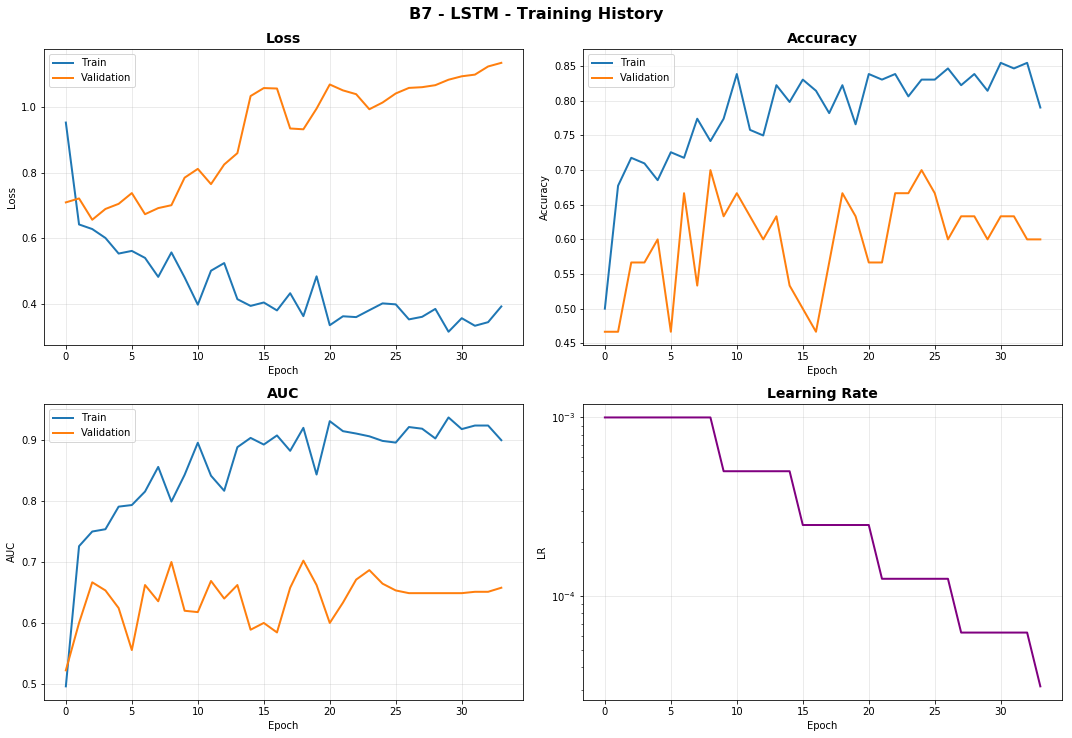

📈 Graphique sauvegardé: training_history_b7_LSTM_20251210_112951.png

💾 Modèle final sauvegardé: final_b7_LSTM_20251210_112951.h5

✅ LSTM terminé avec AUC: 0.7022

📊 COMPARAISON DES MODÈLES B7 (CORRIGÉ)

Modèle          AUC        Accuracy   Loss       Epochs    
-------------------------------------------------------
LSTM            0.7022     0.7000     1.1346     34        

🏆 MEILLEUR MODÈLE: LSTM (AUC: 0.7022)

🧪 ENTRAÎNEMENT DU MODÈLE: LSTM (CORRIGÉ)
🔧 Création du modèle LSTM pour B7:
   - Séquence: 32 frames
   - Features par frame: 2560
   - Input shape: (32, 2560)
✅ Modèle LSTM créé avec succès
Model: "LSTM_B7_Deepfake_Detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 2560)]   0                                            
_________________________________________________________

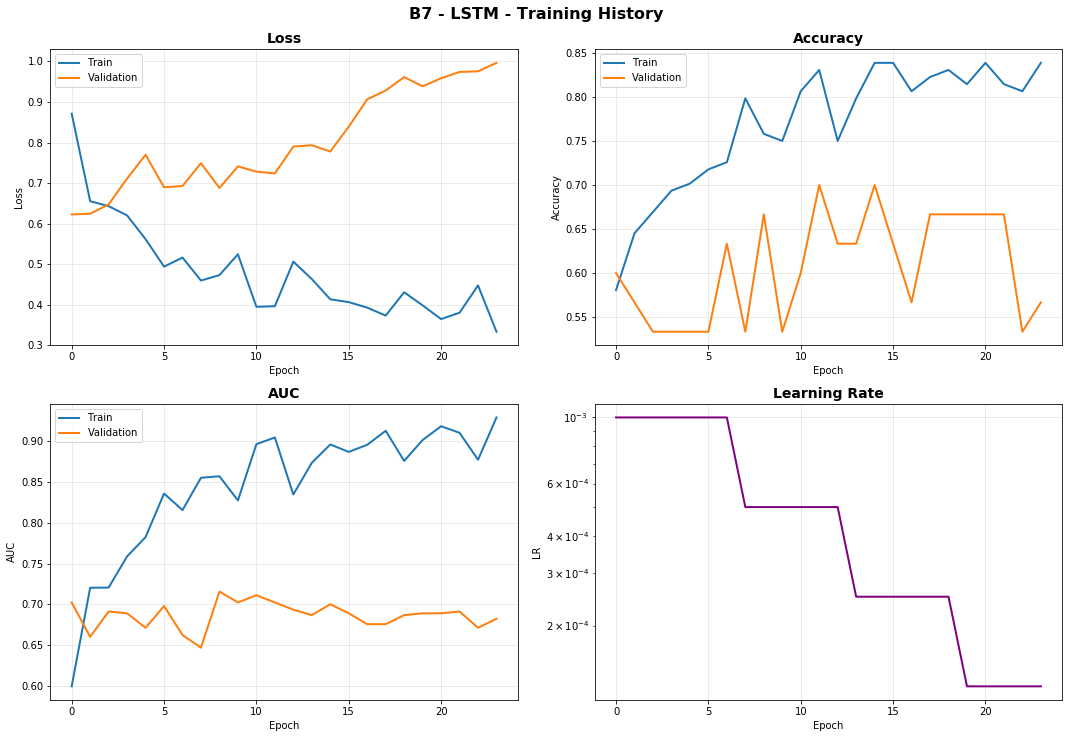

📈 Graphique sauvegardé: training_history_b7_LSTM_20251210_114056.png

💾 Modèle final sauvegardé: final_b7_LSTM_20251210_114056.h5

✅ LSTM terminé avec AUC: 0.7156

🧪 ENTRAÎNEMENT DU MODÈLE: HYBRID (CORRIGÉ)
🔧 Création du modèle hybride pour B7 (CORRIGÉ):
   - Input shape: (32, 2560)
✅ Modèle Hybrid créé avec succès
Model: "Hybrid_B7_Deepfake_Detector_CORRIGE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 2560)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            491584    
_________________________________________________________________
batch_normalization_4 (Batch (None, 32, 64)            256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
____________________________________________

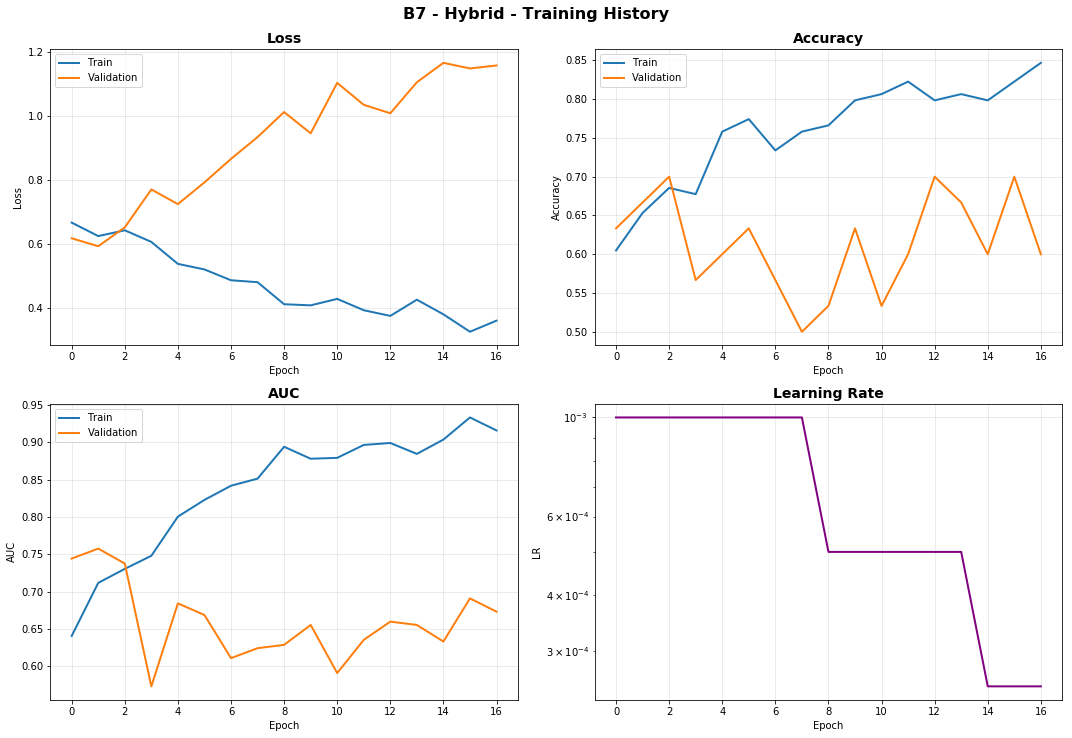

📈 Graphique sauvegardé: training_history_b7_Hybrid_20251210_114842.png

💾 Modèle final sauvegardé: final_b7_Hybrid_20251210_114842.h5

✅ HYBRID terminé avec AUC: 0.7578

📊 COMPARAISON DES MODÈLES B7 (CORRIGÉ)

Modèle          AUC        Accuracy   Loss       Epochs    
-------------------------------------------------------
LSTM            0.7156     0.7000     0.9966     24        
Hybrid          0.7578     0.7000     1.1583     17        

🏆 MEILLEUR MODÈLE: Hybrid (AUC: 0.7578)

🧪 ENTRAÎNEMENT DU MODÈLE: LSTM (CORRIGÉ)
🔧 Création du modèle LSTM pour B7:
   - Séquence: 32 frames
   - Features par frame: 2560
   - Input shape: (32, 2560)
✅ Modèle LSTM créé avec succès
Model: "LSTM_B7_Deepfake_Detector"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 2560)]   0                                  

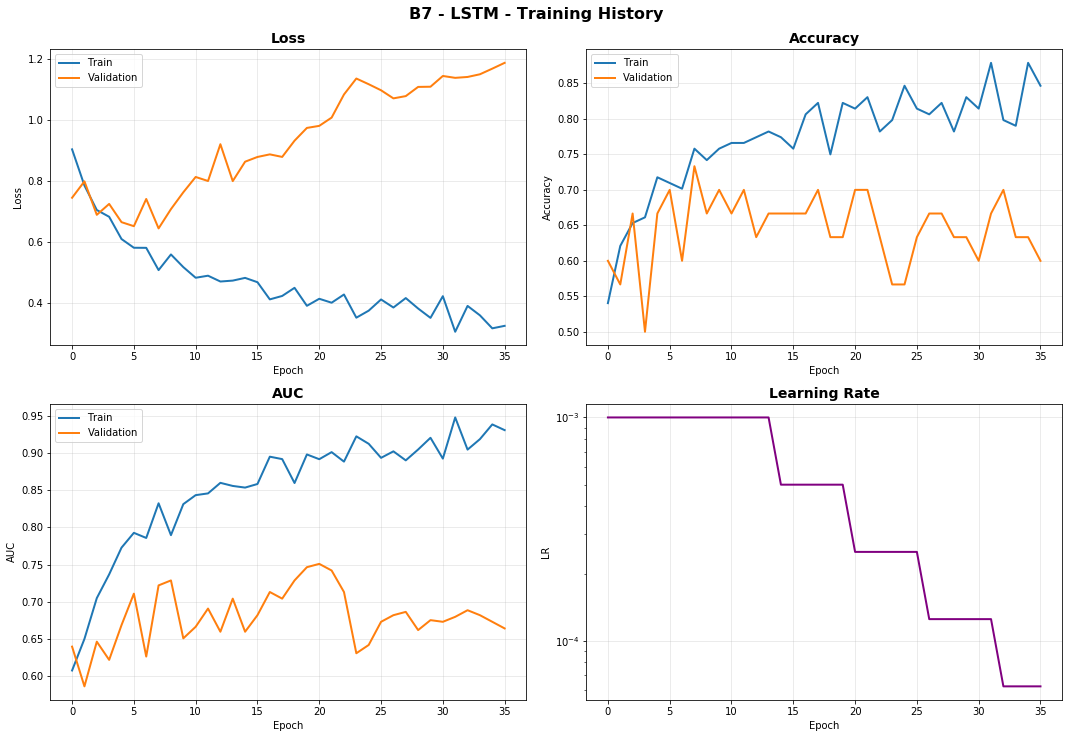

📈 Graphique sauvegardé: training_history_b7_LSTM_20251210_114905.png

💾 Modèle final sauvegardé: final_b7_LSTM_20251210_114905.h5

✅ LSTM terminé avec AUC: 0.7511

🧪 ENTRAÎNEMENT DU MODÈLE: HYBRID (CORRIGÉ)
🔧 Création du modèle hybride pour B7 (CORRIGÉ):
   - Input shape: (32, 2560)
✅ Modèle Hybrid créé avec succès
Model: "Hybrid_B7_Deepfake_Detector_CORRIGE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 2560)]        0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 64)            491584    
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 64)            256       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 16, 64)            0         
____________________________________________

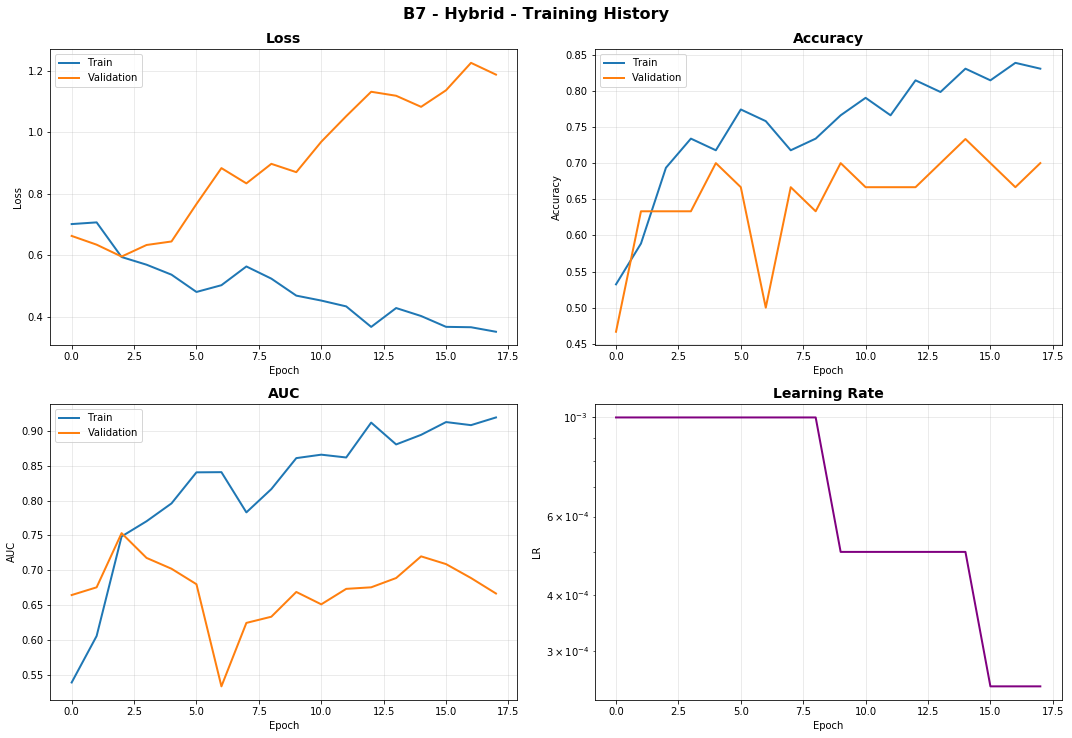

📈 Graphique sauvegardé: training_history_b7_Hybrid_20251210_120026.png

💾 Modèle final sauvegardé: final_b7_Hybrid_20251210_120026.h5

✅ HYBRID terminé avec AUC: 0.7533

🧪 ENTRAÎNEMENT DU MODÈLE: TRANSFORMER (CORRIGÉ)
🔧 Création du modèle Transformer pour B7 (CORRIGÉ):
   - Input shape: (32, 2560)
✅ Modèle Transformer créé avec succès
Model: "Transformer_B7_Deepfake_Detector_CORRIGE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 2560)]   0                                            
__________________________________________________________________________________________________
tf.__operators__.add (TFOpLambd (None, 32, 2560)     0           input_10[0][0]                   
__________________________________________________________________________________________________
multi_head_attentio

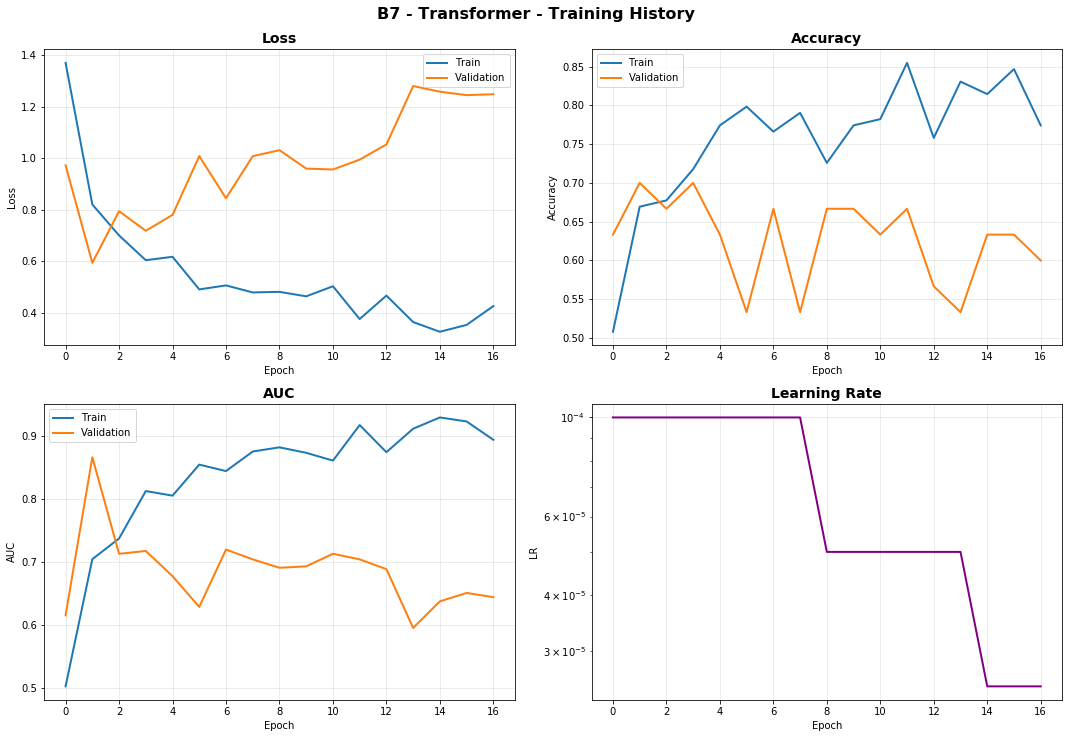

📈 Graphique sauvegardé: training_history_b7_Transformer_20251210_120049.png

💾 Modèle final sauvegardé: final_b7_Transformer_20251210_120049.h5

✅ TRANSFORMER terminé avec AUC: 0.8667

📊 COMPARAISON DES MODÈLES B7 (CORRIGÉ)

Modèle          AUC        Accuracy   Loss       Epochs    
-------------------------------------------------------
LSTM            0.7511     0.7333     1.1865     36        
Hybrid          0.7533     0.7333     1.1868     18        
Transformer     0.8667     0.7000     1.2492     17        

🏆 MEILLEUR MODÈLE: Transformer (AUC: 0.8667)


In [10]:
# 1. Charger vos données
data = np.load('deepfake_dataset_b7.npz')
X_train = data['X_train']  # Shape: (n_samples, 81920)
X_val = data['X_val']
y_train = data['y_train']
y_val = data['y_val']

# 1. Tester d'abord avec LSTM seulement
results = train_multiple_b7_models_corrected(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_types=['LSTM'],  # Commencer simple
    epochs=100,
    batch_size=16
)

# 2. Si LSTM fonctionne, tester Hybrid
results = train_multiple_b7_models_corrected(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_types=['LSTM', 'Hybrid'],  # Ajouter Hybrid
    epochs=100,
    batch_size=16
)

# 3. Transformer en dernier (plus complexe)
results = train_multiple_b7_models_corrected(
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    model_types=['LSTM', 'Hybrid', 'Transformer'],
    epochs=100,
    batch_size=16
)

# # 2. Choisir un modèle
# model = create_optimized_lstm_for_b7()  # Ou create_hybrid_model_for_b7(), etc.

# # 3. Entraîner
# history, trained_model = train_b7_model(
#     model=model,
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     model_type='LSTM',  # 'LSTM', 'Hybrid', ou 'Transformer'
#     epochs=100,
#     batch_size=16,
#     experiment_name="mon_entrainement_b7"
# )

# # 4. Pour tester plusieurs modèles
# results = train_multiple_b7_models(
#     X_train=X_train,
#     y_train=y_train,
#     X_val=X_val,
#     y_val=y_val,
#     model_types=['LSTM', 'Hybrid', 'Transformer'],  # Tous ou sélection
#     epochs=100,
#     batch_size=16
# )

In [30]:
import json
import numpy as np
from datetime import datetime
from sklearn.metrics import roc_curve, precision_recall_curve, auc, confusion_matrix
import os

def safe_precision_recall_f1(y_true, y_pred):
    """
    Version sécurisée pour calculer precision, recall, f1
    Compatible avec les anciennes versions de scikit-learn
    """
    try:
        from sklearn.metrics import precision_score, recall_score, f1_score
        
        # Essayer avec zero_division si disponible
        try:
            precision = precision_score(y_true, y_pred, zero_division=0)
            recall = recall_score(y_true, y_pred, zero_division=0)
            f1 = f1_score(y_true, y_pred, zero_division=0)
        except TypeError:
            # Version ancienne sans zero_division
            precision = precision_score(y_true, y_pred)
            recall = recall_score(y_true, y_pred)
            f1 = f1_score(y_true, y_pred)
            
    except Exception as e:
        print(f"⚠️  Erreur métriques: {e}, calcul manuel...")
        # Calcul manuel
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return float(precision), float(recall), float(f1)

def save_model_report_b7(model, history, X_train, y_train, X_val, y_val, 
                        model_type='LSTM', features_per_frame=2560,
                        experiment_name=None):
    """
    Génère et sauvegarde un rapport JSON détaillé pour un modèle B7
    Version compatible avec anciennes librairies
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # 1. Préparer les données pour évaluation
    print(f"\n📊 PRÉPARATION DES DONNÉES POUR LE RAPPORT {model_type}...")
    
    # Reshape si nécessaire
    if len(X_train.shape) == 2:
        X_train_seq = X_train.reshape(-1, 32, features_per_frame)
        X_val_seq = X_val.reshape(-1, 32, features_per_frame)
    else:
        X_train_seq = X_train
        X_val_seq = X_val
    
    # 2. Faire des prédictions
    print(f"🔮 FAISANT DES PRÉDICTIONS...")
    y_train_pred_proba = model.predict(X_train_seq, verbose=0).flatten()
    y_val_pred_proba = model.predict(X_val_seq, verbose=0).flatten()
    
    y_train_pred = (y_train_pred_proba > 0.5).astype(int)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    
    # 3. Calculer les métriques d'entraînement
    print(f"📈 CALCUL DES MÉTRIQUES...")
    
    # Métriques de base
    from sklearn.metrics import accuracy_score
    
    train_accuracy = float(accuracy_score(y_train, y_train_pred))
    val_accuracy = float(accuracy_score(y_val, y_val_pred))
    
    # Calcul sécurisé de precision, recall, f1
    train_precision, train_recall, train_f1 = safe_precision_recall_f1(y_train, y_train_pred)
    val_precision, val_recall, val_f1 = safe_precision_recall_f1(y_val, y_val_pred)
    
    # AUC et AUC-PR
    try:
        # Vérifier si nous avons plus d'une classe
        if len(np.unique(y_train)) > 1:
            fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
            train_auc = float(auc(fpr_train, tpr_train))
        else:
            train_auc = 0.5
            
        if len(np.unique(y_val)) > 1:
            fpr_val, tpr_val, thresholds_val = roc_curve(y_val, y_val_pred_proba)
            val_auc = float(auc(fpr_val, tpr_val))
        else:
            val_auc = 0.5
            fpr_val, tpr_val, thresholds_val = [], [], []
            
    except Exception as e:
        print(f"⚠️  Erreur AUC: {e}")
        train_auc = 0.5
        val_auc = 0.5
        fpr_val, tpr_val, thresholds_val = [], [], []
    
    # AUC-PR
    try:
        if len(np.unique(y_train)) > 1:
            train_precision_pr, train_recall_pr, _ = precision_recall_curve(y_train, y_train_pred_proba)
            train_auc_pr = float(auc(train_recall_pr, train_precision_pr))
        else:
            train_auc_pr = 0.5
            
        if len(np.unique(y_val)) > 1:
            val_precision_pr, val_recall_pr, _ = precision_recall_curve(y_val, y_val_pred_proba)
            val_auc_pr = float(auc(val_recall_pr, val_precision_pr))
        else:
            val_auc_pr = 0.5
            
    except Exception as e:
        print(f"⚠️  Erreur AUC-PR: {e}")
        train_auc_pr = 0.5
        val_auc_pr = 0.5
    
    # Seuil optimal (Youden's J)
    try:
        if len(fpr_val) > 0 and len(tpr_val) > 0:
            j_scores = tpr_val - fpr_val
            optimal_idx = np.argmax(j_scores)
            best_thresh_val = float(thresholds_val[optimal_idx])
        else:
            best_thresh_val = 0.5
            optimal_idx = 0
            
    except Exception as e:
        print(f"⚠️  Erreur seuil optimal: {e}")
        best_thresh_val = 0.5
        optimal_idx = 0
    
    # Accuracy avec seuil optimal
    try:
        if 'best_thresh_val' in locals() and best_thresh_val is not None:
            y_val_pred_optimal = (y_val_pred_proba > best_thresh_val).astype(int)
            acc_optimal_val = float(accuracy_score(y_val, y_val_pred_optimal))
        else:
            acc_optimal_val = val_accuracy
    except:
        acc_optimal_val = val_accuracy
    
    # Même pour train
    try:
        y_train_pred_optimal = (y_train_pred_proba > 0.5).astype(int)  # Seuil 0.5 par défaut
        acc_optimal_train = float(accuracy_score(y_train, y_train_pred_optimal))
    except:
        acc_optimal_train = train_accuracy
    
    # 4. Extraire les courbes d'entraînement
    try:
        loss_curve = [float(x) for x in history.history.get('loss', [])]
        val_loss_curve = [float(x) for x in history.history.get('val_loss', [])]
        acc_curve = [float(x) for x in history.history.get('accuracy', [])]
        val_acc_curve = [float(x) for x in history.history.get('val_accuracy', [])]
        auc_curve = [float(x) for x in history.history.get('auc', [])] if 'auc' in history.history else []
        val_auc_curve = [float(x) for x in history.history.get('val_auc', [])] if 'val_auc' in history.history else []
        lr_curve = [float(x) for x in history.history.get('lr', [])] if 'lr' in history.history else []
    except Exception as e:
        print(f"⚠️  Erreur courbes: {e}")
        loss_curve, val_loss_curve, acc_curve, val_acc_curve, auc_curve, val_auc_curve, lr_curve = [], [], [], [], [], [], []
    
    # 5. Matrice de confusion
    try:
        cm_train = confusion_matrix(y_train, y_train_pred).tolist()
        cm_val = confusion_matrix(y_val, y_val_pred).tolist()
    except:
        cm_train = [[0, 0], [0, 0]]
        cm_val = [[0, 0], [0, 0]]
    
    # 6. Créer le dictionnaire du rapport
    print(f"📋 CRÉATION DU RAPPORT JSON...")
    
    report_dict = {
        "timestamp": timestamp,
        "model_type": model_type,
        "training_epochs": len(history.history.get('loss', [])),
        "best_train_accuracy": float(max(history.history.get('accuracy', [0]))),
        "best_val_accuracy": float(max(history.history.get('val_accuracy', [0]))),
        "best_train_auc": float(max(history.history.get('auc', [0.5]))),
        "best_val_auc": float(max(history.history.get('val_auc', [0.5]))),
        "final_train_loss": float(history.history.get('loss', [0])[-1] if len(history.history.get('loss', [])) > 0 else 0),
        "final_val_loss": float(history.history.get('val_loss', [0])[-1] if len(history.history.get('val_loss', [])) > 0 else 0),
        "input_shapes": {
            "video_input": f"({model.input_shape[1] if len(model.input_shape) > 1 else '?'}, "
                          f"{model.input_shape[2] if len(model.input_shape) > 2 else '?'})"
        },
        "evaluation": {
            "train": {
                "accuracy": train_accuracy,
                "precision": train_precision,
                "recall": train_recall,
                "f1": train_f1,
                "auc": train_auc,
                "auc_pr": train_auc_pr,
                "best_thresh": 0.5,  # Par défaut
                "acc_optimal": acc_optimal_train
            },
            "validation": {
                "accuracy": val_accuracy,
                "precision": val_precision,
                "recall": val_recall,
                "f1": val_f1,
                "auc": val_auc,
                "auc_pr": val_auc_pr,
                "best_thresh": best_thresh_val,
                "acc_optimal": acc_optimal_val
            },
            "curves": {
                "loss": loss_curve,
                "val_loss": val_loss_curve,
                "accuracy": acc_curve,
                "val_accuracy": val_acc_curve,
                "auc": auc_curve,
                "val_auc": val_auc_curve,
                "lr": lr_curve
            },
            "roc_curve": {
                "fpr": [float(x) for x in fpr_val],
                "tpr": [float(x) for x in tpr_val],
                "thresholds": [float(x) for x in thresholds_val] if 'thresholds_val' in locals() else [],
                "auc": val_auc
            },
            "pr_curve": {
                "precision": [float(x) for x in val_precision_pr] if 'val_precision_pr' in locals() else [],
                "recall": [float(x) for x in val_recall_pr] if 'val_recall_pr' in locals() else [],
                "thresholds": [float(x) for x in _] if '_' in locals() and len(_) > 0 else [],
                "auc_pr": val_auc_pr
            },
            "confusion_matrix": {
                "train": cm_train,
                "validation": cm_val
            },
            "dataset_info": {
                "train_samples": int(len(X_train_seq)),
                "val_samples": int(len(X_val_seq)),
                "train_real": int(np.sum(y_train == 0)),
                "train_fake": int(np.sum(y_train == 1)),
                "val_real": int(np.sum(y_val == 0)),
                "val_fake": int(np.sum(y_val == 1)),
                "train_ratio": f"{int(np.sum(y_train == 0))}:{int(np.sum(y_train == 1))}",
                "val_ratio": f"{int(np.sum(y_val == 0))}:{int(np.sum(y_val == 1))}",
                "classes": ["REAL", "FAKE"]
            }
        },
        "model_config": {
            "frames_per_video": 32,
            "features_per_frame": features_per_frame,
            "total_features": 32 * features_per_frame,
            "model_name": model.name if hasattr(model, 'name') else model_type,
            "model_parameters": model.count_params() if hasattr(model, 'count_params') else 0,
            "optimizer": str(model.optimizer.__class__.__name__) if hasattr(model, 'optimizer') else "Unknown",
            "loss_function": str(model.loss) if hasattr(model, 'loss') else "Unknown"
        }
    }
    
    # 7. Sauvegarder le rapport JSON
    if experiment_name:
        report_filename = f"{experiment_name}_{model_type}_report_{timestamp}.json"
    else:
        report_filename = f"b7_{model_type}_report_{timestamp}.json"
    
    try:
        with open(report_filename, 'w') as f:
            json.dump(report_dict, f, indent=2, default=str)  # default=str pour gérer tous les types
        print(f"✅ Rapport JSON sauvegardé: {report_filename}")
    except Exception as e:
        print(f"❌ Erreur sauvegarde JSON: {e}")
        # Essayer une sauvegarde simplifiée
        try:
            simplified_report = {
                "timestamp": timestamp,
                "model_type": model_type,
                "val_accuracy": val_accuracy,
                "val_auc": val_auc,
                "training_epochs": len(history.history.get('loss', []))
            }
            with open(f"simple_{report_filename}", 'w') as f:
                json.dump(simplified_report, f, indent=2)
            print(f"✅ Rapport simplifié sauvegardé: simple_{report_filename}")
            report_filename = f"simple_{report_filename}"
        except:
            report_filename = None
    
    return report_dict, report_filename

def print_report_summary(report_dict):
    """
    Affiche un résumé lisible d'un rapport
    Version robuste
    """
    try:
        model_type = report_dict.get("model_type", "Unknown")
        timestamp = report_dict.get("timestamp", "")
        
        print(f"\n📋 RÉSUMÉ DU RAPPORT {model_type} ({timestamp})")
        print("="*60)
        
        # Performances
        if "evaluation" in report_dict and "validation" in report_dict["evaluation"]:
            val_metrics = report_dict["evaluation"]["validation"]
            print(f"\n📊 PERFORMANCES VALIDATION:")
            print(f"   Accuracy:  {val_metrics.get('accuracy', 0):.4f}")
            print(f"   Precision: {val_metrics.get('precision', 0):.4f}")
            print(f"   Recall:    {val_metrics.get('recall', 0):.4f}")
            print(f"   F1-Score:  {val_metrics.get('f1', 0):.4f}")
            print(f"   AUC:       {val_metrics.get('auc', 0):.4f}")
            print(f"   AUC-PR:    {val_metrics.get('auc_pr', 0):.4f}")
            print(f"   Seuil opt: {val_metrics.get('best_thresh', 0.5):.4f}")
        
        if "evaluation" in report_dict and "train" in report_dict["evaluation"]:
            train_metrics = report_dict["evaluation"]["train"]
            print(f"\n📊 PERFORMANCES TRAIN:")
            print(f"   Accuracy:  {train_metrics.get('accuracy', 0):.4f}")
            print(f"   AUC:       {train_metrics.get('auc', 0):.4f}")
        
        # Entraînement
        print(f"\n🎯 ENTRAÎNEMENT:")
        print(f"   Epochs:           {report_dict.get('training_epochs', 0)}")
        print(f"   Best val AUC:     {report_dict.get('best_val_auc', 0):.4f}")
        print(f"   Best val accuracy:{report_dict.get('best_val_accuracy', 0):.4f}")
        print(f"   Final val loss:   {report_dict.get('final_val_loss', 0):.4f}")
        
        # Données
        if "evaluation" in report_dict and "dataset_info" in report_dict["evaluation"]:
            dataset_info = report_dict["evaluation"]["dataset_info"]
            print(f"\n📁 DONNÉES:")
            print(f"   Train samples:    {dataset_info.get('train_samples', 0)}")
            print(f"   Val samples:      {dataset_info.get('val_samples', 0)}")
            print(f"   Train ratio:      {dataset_info.get('train_ratio', '0:0')}")
            print(f"   Val ratio:        {dataset_info.get('val_ratio', '0:0')}")
        
        # Modèle
        if "model_config" in report_dict:
            model_config = report_dict["model_config"]
            print(f"\n🧠 MODÈLE:")
            print(f"   Input shape:      {model_config.get('frames_per_video', 0)}×{model_config.get('features_per_frame', 0)}")
            print(f"   Parameters:       {model_config.get('model_parameters', 0):,}")
        
    except Exception as e:
        print(f"⚠️  Erreur affichage résumé: {e}")
        print(f"   Rapport disponible mais format complexe")

def generate_comparison_report(all_reports):
    """
    Génère un rapport comparatif de tous les modèles
    Version simplifiée
    """
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    comparison_dict = {
        "timestamp": timestamp,
        "models_comparison": {},
        "summary": {}
    }
    
    best_auc = 0
    best_accuracy = 0
    best_model_name = None
    
    for model_type, report_dict, _ in all_reports:
        try:
            comparison_dict["models_comparison"][model_type] = {
                "val_auc": report_dict["evaluation"]["validation"].get("auc", 0),
                "val_accuracy": report_dict["evaluation"]["validation"].get("accuracy", 0),
                "val_f1": report_dict["evaluation"]["validation"].get("f1", 0),
                "training_epochs": report_dict.get("training_epochs", 0),
                "final_val_loss": report_dict.get("final_val_loss", 0),
                "model_parameters": report_dict["model_config"].get("model_parameters", 0)
            }
            
            # Mettre à jour les meilleurs
            auc_val = report_dict["evaluation"]["validation"].get("auc", 0)
            acc_val = report_dict["evaluation"]["validation"].get("accuracy", 0)
            
            if auc_val > best_auc:
                best_auc = auc_val
                best_model_name = model_type
            
            if acc_val > best_accuracy:
                best_accuracy = acc_val
                
        except Exception as e:
            print(f"⚠️  Erreur traitement {model_type}: {e}")
            comparison_dict["models_comparison"][model_type] = {"error": str(e)}
    
    # Mettre à jour le résumé
    comparison_dict["summary"]["best_auc_val"] = best_auc
    comparison_dict["summary"]["best_accuracy_val"] = best_accuracy
    comparison_dict["summary"]["best_model"] = best_model_name
    
    # Sauvegarder
    comparison_filename = f"b7_models_comparison_{timestamp}.json"
    try:
        with open(comparison_filename, 'w') as f:
            json.dump(comparison_dict, f, indent=2)
        print(f"✅ Rapport comparatif sauvegardé: {comparison_filename}")
    except Exception as e:
        print(f"❌ Erreur sauvegarde comparatif: {e}")
        comparison_filename = None
    
    return comparison_dict, comparison_filename


In [32]:
model = create_optimized_lstm_for_b7() 

# 1. Après entraînement, générer le rapport
report_dict, report_path = save_model_report_b7(
    model=model,  # Votre modèle entraîné
    history=results,        # Historique d'entraînement
    X_train=X_train,        # Données d'entraînement
    y_train=y_train,
    X_val=X_val,           # Données de validation
    y_val=y_val,
    model_type='LSTM',     # Type de modèle
    features_per_frame=2560,
    experiment_name="deepfake_experiment"
)

# 2. Afficher le résumé
print_report_summary(report_dict)

# # 3. Pour plusieurs modèles
# all_reports = []

# # Pour chaque modèle entraîné
# for model_info in trained_models:
#     model_type = model_info['type']
#     model = model_info['model']
#     history = model_info['history']
    
#     report_dict, report_path = save_model_report_b7(
#         model=model,
#         history=results,
#         X_train=X_train,
#         y_train=y_train,
#         X_val=X_val,
#         y_val=y_val,
#         model_type=model_type,
#         features_per_frame=2560,
#         experiment_name=f"deepfake_b7_{model_type}"
#     )
    
#     all_reports.append((model_type, report_dict, report_path))

# # 4. Générer rapport comparatif
# if len(all_reports) > 1:
#     comparison_dict, comparison_path = generate_comparison_report(all_reports)

🔧 Création du modèle LSTM pour B7:
   - Séquence: 32 frames
   - Features par frame: 2560
   - Input shape: (32, 2560)

📊 PRÉPARATION DES DONNÉES POUR LE RAPPORT LSTM...
🔮 FAISANT DES PRÉDICTIONS...
📈 CALCUL DES MÉTRIQUES...
⚠️  Erreur courbes: 'dict' object has no attribute 'history'
📋 CRÉATION DU RAPPORT JSON...


AttributeError: 'dict' object has no attribute 'history'

In [27]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

def detailed_evaluation_b7(model, X_val, y_val, model_type='LSTM'):
    """
    Évaluation complète du modèle B7
    
    Args:
        model: Modèle Keras entraîné
        X_val: Données de validation
        y_val: Labels de validation
        model_type: Type de modèle ('LSTM', 'Hybrid', 'Transformer')
    """
    
    print("\n" + "="*70)
    print(f"📊 ÉVALUATION DÉTAILLÉE - B7 {model_type.upper()}")
    print("="*70)
    
    # 1. Vérification et préparation des données
    print(f"\n🔍 VÉRIFICATION DES DONNÉES:")
    print(f"   X_val shape: {X_val.shape}")
    print(f"   y_val shape: {y_val.shape}")
    
    # Vérifier si besoin de reshape
    if len(X_val.shape) == 2:
        print(f"   🔁 Reshape nécessaire...")
        total_features = X_val.shape[1]
        
        # Pour B7: 32 frames × 2560 features = 81920
        if total_features == 81920:
            X_val_seq = X_val.reshape(-1, 32, 2560)
            print(f"   ✅ Reshape B7: {X_val.shape} → {X_val_seq.shape}")
        else:
            print(f"   ⚠️  Dimension inattendue: {total_features}")
            print(f"   Tentative de reshape automatique...")
            
            # Essayer différents reshape
            possible_frames = [16, 32, 64]
            possible_features = [512, 1280, 1792, 2560, 2048]
            
            for frames in possible_frames:
                for features in possible_features:
                    if total_features == frames * features:
                        X_val_seq = X_val.reshape(-1, frames, features)
                        print(f"   ✅ Reshape détecté: {frames}frames × {features}features")
                        break
                else:
                    continue
                break
            else:
                # Fallback: utiliser 32×2560 et padding/truncate
                print(f"   ⚠️  Pas de reshape exact trouvé, ajustement...")
                expected_total = 32 * 2560
                if total_features > expected_total:
                    X_val = X_val[:, :expected_total]
                else:
                    padding = expected_total - total_features
                    X_val = np.pad(X_val, ((0,0), (0,padding)), mode='constant')
                X_val_seq = X_val.reshape(-1, 32, 2560)
    else:
        print(f"   ✅ Déjà reshape: {X_val.shape}")
        X_val_seq = X_val
    
    print(f"   Format final: {X_val_seq.shape}")
    
    # 2. Prédictions
    print(f"\n🔮 PRÉDICTIONS:")
    
    # Prédictions probabilistes
    y_pred_proba = model.predict(X_val_seq, verbose=1, batch_size=16).flatten()
    
    # Prédictions binaires avec seuil 0.5
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    print(f"   Samples: {len(y_val)}")
    print(f"   Predictions shape: {y_pred_proba.shape}")
    print(f"   Prédictions min/max: [{y_pred_proba.min():.3f}, {y_pred_proba.max():.3f}]")
    print(f"   Moyenne prédictions: {y_pred_proba.mean():.3f}")
    
    # 3. Métriques de base
    print(f"\n📈 MÉTRIQUES DE BASE:")
    
    accuracy = np.mean(y_pred == y_val)
    print(f"   Accuracy (seuil 0.5): {accuracy:.4f}")
    
    auc_score = roc_auc_score(y_val, y_pred_proba)
    print(f"   AUC Score: {auc_score:.4f}")
    
    # 4. Rapport de classification détaillé
    print(f"\n📊 RAPPORT DE CLASSIFICATION (seuil 0.5):")
    
    # Pour éviter l'erreur avec une seule classe
    unique_classes = np.unique(y_val)
    target_names = ['REAL', 'FAKE']
    
    # Filtrer les noms de classes présentes
    present_target_names = [target_names[int(cls)] for cls in unique_classes]
    
    print(classification_report(y_val, y_pred, 
                               target_names=present_target_names,
                               digits=4))
    
    # 5. Matrice de confusion
    print(f"\n🎯 MATRICE DE CONFUSION (seuil 0.5):")
    
    cm = confusion_matrix(y_val, y_pred)
    print(f"   [[TN FP]")
    print(f"    [FN TP]]")
    print(f"   {cm}")
    
    # Calculer les métriques de la matrice
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        print(f"\n   Détails:")
        print(f"   TN (Vrais Négatifs): {tn}")
        print(f"   FP (Faux Positifs): {fp}")
        print(f"   FN (Faux Négatifs): {fn}")
        print(f"   TP (Vrais Positifs): {tp}")
        
        # Métriques dérivées
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        
        print(f"\n   Métriques calculées:")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall/Sensibilité: {recall:.4f}")
        print(f"   Spécificité: {specificity:.4f}")
        print(f"   F1-Score: {f1_score:.4f}")
        print(f"   Taux Faux Positifs: {fp/(fp+tn):.4f}" if (fp+tn) > 0 else "   Taux Faux Positifs: 0.0000")
        print(f"   Taux Faux Négatifs: {fn/(fn+tp):.4f}" if (fn+tp) > 0 else "   Taux Faux Négatifs: 0.0000")
    
    # 6. Analyse par classe
    print(f"\n📊 ANALYSE PAR CLASSE:")
    
    real_indices = np.where(y_val == 0)[0]
    fake_indices = np.where(y_val == 1)[0]
    
    if len(real_indices) > 0:
        real_predictions = y_pred_proba[real_indices]
        print(f"   REAL ({len(real_indices)} samples):")
        print(f"     - Moyenne prédiction: {real_predictions.mean():.4f}")
        print(f"     - Std: {real_predictions.std():.4f}")
        print(f"     - Min/Max: [{real_predictions.min():.4f}, {real_predictions.max():.4f}]")
        print(f"     - Médiane: {np.median(real_predictions):.4f}")
        print(f"     - % > 0.5: {(real_predictions > 0.5).mean():.2%}")
    
    if len(fake_indices) > 0:
        fake_predictions = y_pred_proba[fake_indices]
        print(f"\n   FAKE ({len(fake_indices)} samples):")
        print(f"     - Moyenne prédiction: {fake_predictions.mean():.4f}")
        print(f"     - Std: {fake_predictions.std():.4f}")
        print(f"     - Min/Max: [{fake_predictions.min():.4f}, {fake_predictions.max():.4f}]")
        print(f"     - Médiane: {np.median(fake_predictions):.4f}")
        print(f"     - % > 0.5: {(fake_predictions > 0.5).mean():.2%}")
    
    # 7. Recherche du seuil optimal
    print(f"\n🎯 RECHERCHE DU SEUIL OPTIMAL:")
    
    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)
    
    # Score de Youden (J = sensibilité + spécificité - 1)
    j_scores = tpr - fpr
    optimal_idx = np.argmax(j_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_tpr = tpr[optimal_idx]
    optimal_fpr = fpr[optimal_idx]
    
    print(f"   Seuil optimal (Youden): {optimal_threshold:.4f}")
    print(f"   Sensibilité à ce seuil: {optimal_tpr:.4f}")
    print(f"   1 - Spécificité: {optimal_fpr:.4f}")
    
    # Prédictions avec seuil optimal
    y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)
    accuracy_optimal = np.mean(y_pred_optimal == y_val)
    
    print(f"   Accuracy avec seuil optimal: {accuracy_optimal:.4f}")
    
    # 8. Métrique F-beta pour différents beta
    print(f"\n📊 MÉTRIQUES F-BETA:")
    
    if cm.shape == (2, 2):
        for beta in [0.5, 1, 2]:
            f_beta = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall) if (precision + recall) > 0 else 0
            print(f"   F-{beta}: {f_beta:.4f}")
    
    # 9. Courbe Precision-Recall
    precision_pr, recall_pr, thresholds_pr = precision_recall_curve(y_val, y_pred_proba)
    average_precision = average_precision_score(y_val, y_pred_proba)
    
    print(f"\n📈 COURBE PRECISION-RECALL:")
    print(f"   Average Precision (AP): {average_precision:.4f}")
    
    # 10. Visualisations
    print(f"\n🎨 CRÉATION DES VISUALISATIONS...")
    
    fig = plt.figure(figsize=(20, 5))
    
    # 10a. Distribution des prédictions
    ax1 = plt.subplot(1, 4, 1)
    
    # Histogramme des prédictions
    if len(real_indices) > 0:
        plt.hist(y_pred_proba[real_indices], bins=30, alpha=0.7, label='REAL', color='blue', density=True)
    if len(fake_indices) > 0:
        plt.hist(y_pred_proba[fake_indices], bins=30, alpha=0.7, label='FAKE', color='red', density=True)
    
    plt.axvline(x=0.5, color='black', linestyle='--', label='Seuil 0.5')
    plt.axvline(x=optimal_threshold, color='green', linestyle='--', label=f'Seuil optimal ({optimal_threshold:.3f})')
    
    plt.xlabel('Score de prédiction')
    plt.ylabel('Densité')
    plt.title('Distribution des scores de prédiction')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 10b. Courbe ROC
    ax2 = plt.subplot(1, 4, 2)
    
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.plot(optimal_fpr, optimal_tpr, 'ro', label=f'Optimal threshold = {optimal_threshold:.3f}')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    
    # 10c. Matrice de confusion
    ax3 = plt.subplot(1, 4, 3)
    
    if cm.shape == (2, 2):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['REAL', 'FAKE'],
                   yticklabels=['REAL', 'FAKE'])
        plt.title('Matrice de confusion')
        plt.ylabel('Vraie classe')
        plt.xlabel('Classe prédite')
    else:
        plt.text(0.5, 0.5, 'Matrice non 2x2', 
                horizontalalignment='center',
                verticalalignment='center')
        plt.title('Matrice de confusion')
    
    # 10d. Courbe Precision-Recall
    ax4 = plt.subplot(1, 4, 4)
    
    plt.plot(recall_pr, precision_pr, color='blue', lw=2, 
             label=f'PR curve (AP = {average_precision:.3f})')
    plt.axhline(y=len(fake_indices)/len(y_val) if len(y_val)>0 else 0.5, 
                color='red', linestyle='--', label='Baseline')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Courbe Precision-Recall')
    plt.legend(loc="lower left")
    plt.grid(True, alpha=0.3)
    
    plt.suptitle(f'Évaluation B7 - {model_type.upper()} - AUC: {auc_score:.4f}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    # Sauvegarder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plot_filename = f'evaluation_b7_{model_type}_{timestamp}.png'
    plt.savefig(plot_filename, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print(f"✅ Graphique sauvegardé: {plot_filename}")
    
    # 11. Résumé final
    print(f"\n{'='*70}")
    print(f"📋 RÉSUMÉ FINAL - B7 {model_type.upper()}")
    print('='*70)
    
    print(f"\n📊 PERFORMANCE:")
    print(f"   AUC: {auc_score:.4f}")
    print(f"   Accuracy (0.5): {accuracy:.4f}")
    print(f"   Accuracy (optimal): {accuracy_optimal:.4f}")
    print(f"   Average Precision: {average_precision:.4f}")
    
    if cm.shape == (2, 2):
        print(f"\n📈 MÉTRIQUES DÉTAILLÉES:")
        print(f"   Precision: {precision:.4f}")
        print(f"   Recall: {recall:.4f}")
        print(f"   F1-Score: {f1_score:.4f}")
        print(f"   Spécificité: {specificity:.4f}")
        
        print(f"\n🎯 SEUILS:")
        print(f"   Standard: 0.500")
        print(f"   Optimal (Youden): {optimal_threshold:.4f}")
        
        print(f"\n📊 DISTRIBUTION:")
        print(f"   Samples REAL: {len(real_indices)}")
        print(f"   Samples FAKE: {len(fake_indices)}")
        print(f"   Ratio REAL/FAKE: {len(real_indices)}:{len(fake_indices)}")
    
    print(f"\n💾 FICHIERS CRÉÉS:")
    print(f"   - {plot_filename}")
    
    return {
        'y_pred_proba': y_pred_proba,
        'y_pred': y_pred,
        'y_pred_optimal': y_pred_optimal,
        'auc': auc_score,
        'accuracy': accuracy,
        'accuracy_optimal': accuracy_optimal,
        'optimal_threshold': optimal_threshold,
        'cm': cm,
        'fpr': fpr,
        'tpr': tpr,
        'precision_pr': precision_pr,
        'recall_pr': recall_pr
    }

def compare_model_performances(results_dict):
    """
    Compare les performances de plusieurs modèles
    
    Args:
        results_dict: Dictionnaire {model_name: evaluation_results}
    """
    print("\n" + "="*70)
    print("📊 COMPARAISON DES PERFORMANCES DES MODÈLES")
    print("="*70)
    
    print(f"\n{'Modèle':<20} {'AUC':<10} {'Accuracy':<10} {'F1-Score':<10} {'AP':<10}")
    print("-"*60)
    
    for model_name, results in results_dict.items():
        if 'cm' in results and results['cm'].shape == (2, 2):
            tn, fp, fn, tp = results['cm'].ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            
            # Average Precision approximé
            if 'precision_pr' in results and 'recall_pr' in results:
                ap = np.trapz(results['precision_pr'], results['recall_pr'])
            else:
                ap = 0
            
            print(f"{model_name:<20} "
                  f"{results['auc']:.4f}     "
                  f"{results['accuracy']:.4f}     "
                  f"{f1_score:.4f}     "
                  f"{ap:.4f}")
        else:
            print(f"{model_name:<20} "
                  f"{results.get('auc', 0):.4f}     "
                  f"{results.get('accuracy', 0):.4f}     "
                  f"{'-':<10}     "
                  f"{'-':<10}")



📊 ÉVALUATION DÉTAILLÉE - B7 LSTM

🔍 VÉRIFICATION DES DONNÉES:
   X_val shape: (10, 32, 2560)
   y_val shape: (10,)
   ✅ Déjà reshape: (10, 32, 2560)
   Format final: (10, 32, 2560)

🔮 PRÉDICTIONS:
1/1 [==============================] - 0s 391ms/step
   Samples: 10
   Predictions shape: (10,)
   Prédictions min/max: [0.444, 0.501]
   Moyenne prédictions: 0.483

📈 MÉTRIQUES DE BASE:
   Accuracy (seuil 0.5): 0.4000
   AUC Score: 0.1600

📊 RAPPORT DE CLASSIFICATION (seuil 0.5):
              precision    recall  f1-score   support

        REAL     0.4444    0.8000    0.5714         5
        FAKE     0.0000    0.0000    0.0000         5

    accuracy                         0.4000        10
   macro avg     0.2222    0.4000    0.2857        10
weighted avg     0.2222    0.4000    0.2857        10


🎯 MATRICE DE CONFUSION (seuil 0.5):
   [[TN FP]
    [FN TP]]
   [[4 1]
 [5 0]]

   Détails:
   TN (Vrais Négatifs): 4
   FP (Faux Positifs): 1
   FN (Faux Négatifs): 5
   TP (Vrais Positifs): 

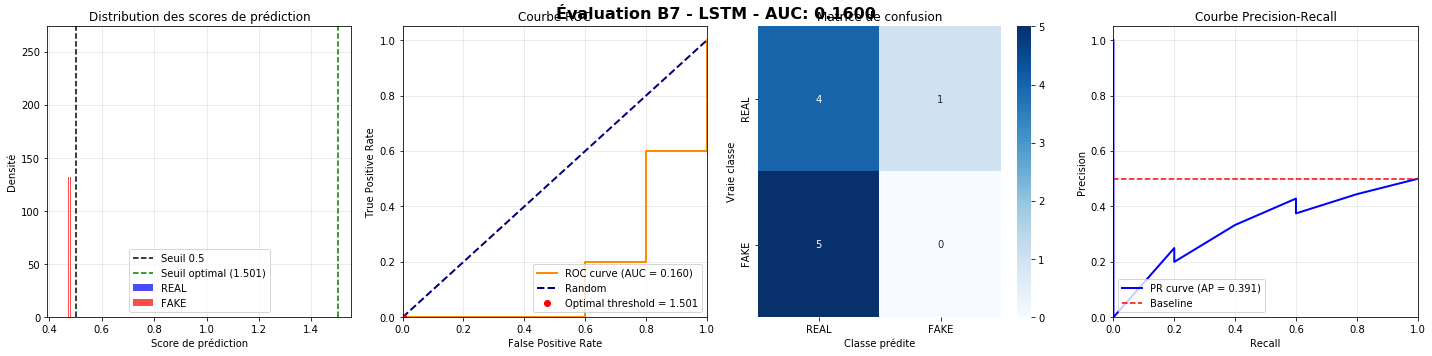

✅ Graphique sauvegardé: evaluation_b7_LSTM_20251210_122513.png

📋 RÉSUMÉ FINAL - B7 LSTM

📊 PERFORMANCE:
   AUC: 0.1600
   Accuracy (0.5): 0.4000
   Accuracy (optimal): 0.5000
   Average Precision: 0.3913

📈 MÉTRIQUES DÉTAILLÉES:
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.0000
   Spécificité: 0.8000

🎯 SEUILS:
   Standard: 0.500
   Optimal (Youden): 1.5008

📊 DISTRIBUTION:
   Samples REAL: 5
   Samples FAKE: 5
   Ratio REAL/FAKE: 5:5

💾 FICHIERS CRÉÉS:
   - evaluation_b7_LSTM_20251210_122513.png

📊 ÉVALUATION DÉTAILLÉE - B7 HYBRID

🔍 VÉRIFICATION DES DONNÉES:
   X_val shape: (10, 32, 2560)
   y_val shape: (10,)
   ✅ Déjà reshape: (10, 32, 2560)
   Format final: (10, 32, 2560)

🔮 PRÉDICTIONS:
1/1 [==============================] - 0s 381ms/step
   Samples: 10
   Predictions shape: (10,)
   Prédictions min/max: [0.444, 0.501]
   Moyenne prédictions: 0.483

📈 MÉTRIQUES DE BASE:
   Accuracy (seuil 0.5): 0.4000
   AUC Score: 0.1600

📊 RAPPORT DE CLASSIFICATION (seuil 0.5):
      

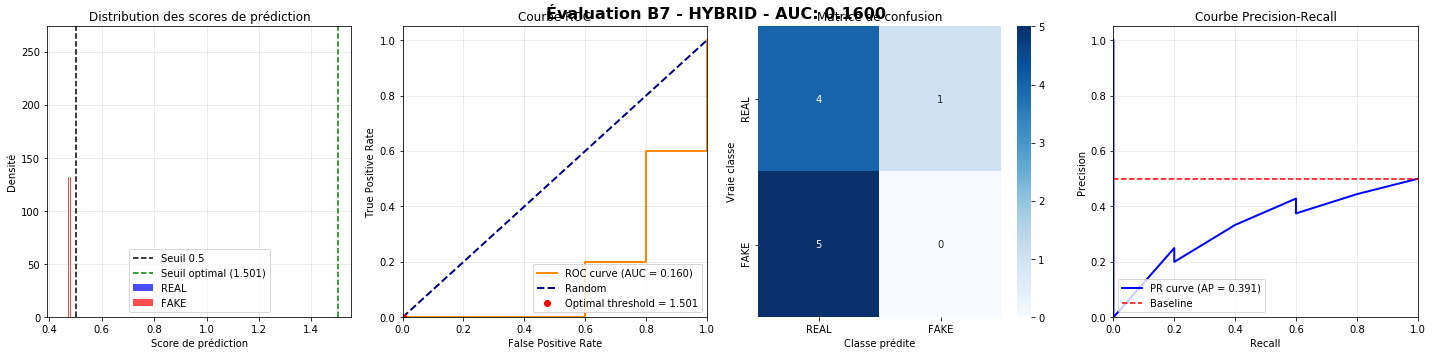

✅ Graphique sauvegardé: evaluation_b7_Hybrid_20251210_122516.png

📋 RÉSUMÉ FINAL - B7 HYBRID

📊 PERFORMANCE:
   AUC: 0.1600
   Accuracy (0.5): 0.4000
   Accuracy (optimal): 0.5000
   Average Precision: 0.3913

📈 MÉTRIQUES DÉTAILLÉES:
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.0000
   Spécificité: 0.8000

🎯 SEUILS:
   Standard: 0.500
   Optimal (Youden): 1.5008

📊 DISTRIBUTION:
   Samples REAL: 5
   Samples FAKE: 5
   Ratio REAL/FAKE: 5:5

💾 FICHIERS CRÉÉS:
   - evaluation_b7_Hybrid_20251210_122516.png

📊 ÉVALUATION DÉTAILLÉE - B7 TRANSFORMER

🔍 VÉRIFICATION DES DONNÉES:
   X_val shape: (10, 32, 2560)
   y_val shape: (10,)
   ✅ Déjà reshape: (10, 32, 2560)
   Format final: (10, 32, 2560)

🔮 PRÉDICTIONS:
1/1 [==============================] - 0s 391ms/step
   Samples: 10
   Predictions shape: (10,)
   Prédictions min/max: [0.444, 0.501]
   Moyenne prédictions: 0.483

📈 MÉTRIQUES DE BASE:
   Accuracy (seuil 0.5): 0.4000
   AUC Score: 0.1600

📊 RAPPORT DE CLASSIFICATION (seuil 0

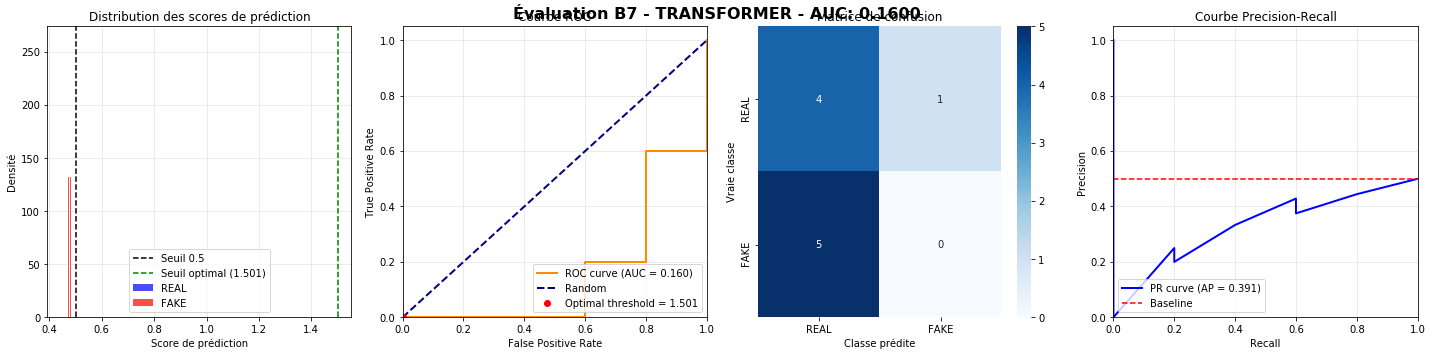

✅ Graphique sauvegardé: evaluation_b7_Transformer_20251210_122519.png

📋 RÉSUMÉ FINAL - B7 TRANSFORMER

📊 PERFORMANCE:
   AUC: 0.1600
   Accuracy (0.5): 0.4000
   Accuracy (optimal): 0.5000
   Average Precision: 0.3913

📈 MÉTRIQUES DÉTAILLÉES:
   Precision: 0.0000
   Recall: 0.0000
   F1-Score: 0.0000
   Spécificité: 0.8000

🎯 SEUILS:
   Standard: 0.500
   Optimal (Youden): 1.5008

📊 DISTRIBUTION:
   Samples REAL: 5
   Samples FAKE: 5
   Ratio REAL/FAKE: 5:5

💾 FICHIERS CRÉÉS:
   - evaluation_b7_Transformer_20251210_122519.png


In [28]:
# 1. Après entraînement, évaluer votre modèle
results = detailed_evaluation_b7(
    model=model,  # Votre modèle entraîné
    X_val=X_val,          # Données de validation
    y_val=y_val,          # Labels de validation
    model_type='LSTM'     # Type de votre modèle
)

results = detailed_evaluation_b7(
    model=model,  # Votre modèle entraîné
    X_val=X_val,          # Données de validation
    y_val=y_val,          # Labels de validation
    model_type='Hybrid'     # Type de votre modèle
)

results = detailed_evaluation_b7(
    model=model,  # Votre modèle entraîné
    X_val=X_val,          # Données de validation
    y_val=y_val,          # Labels de validation
    model_type='Transformer'     # Type de votre modèle
)


# 2. Si vous avez plusieurs modèles, les comparer
# results_dict = {
#     'LSTM_B7': results_lstm,
#     'Hybrid_B7': results_hybrid,
#     'Transformer_B7': results_transformer
# }

# compare_model_performances(results_dict)

In [16]:
def plot_training_history(history):
    """Affiche l'historique d'entraînement"""
    if history is None:
        print("❌ Aucun historique d'entraînement à afficher")
        return
        
    import matplotlib.pyplot as plt
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # AUC
    ax3.plot(history.history['auc'], label='Train AUC', linewidth=2)
    ax3.plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    ax3.set_title('Model AUC', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Résumé des performances
    best_epoch = np.argmax(history.history['val_auc'])
    ax4.text(0.1, 0.9, f"Meilleur AUC: {max(history.history['val_auc']):.4f}", fontsize=12)
    ax4.text(0.1, 0.7, f"Meilleur Accuracy: {max(history.history['val_accuracy']):.4f}", fontsize=12)
    ax4.text(0.1, 0.5, f"Final Loss: {history.history['val_loss'][-1]:.4f}", fontsize=12)
    ax4.text(0.1, 0.3, f"Échantillons train: {len(X_train)}", fontsize=12)
    ax4.text(0.1, 0.1, f"Échantillons val: {len(X_val)}", fontsize=12)
    ax4.set_title('Résumé Final', fontsize=14, fontweight='bold')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()

# Affichage des graphiques
if 'history' in locals():
    plot_training_history(history)

In [29]:
import os
import json
import numpy as np
import pandas as pd
from datetime import datetime
import shutil
from tensorflow import keras

# Chemin de sortie Kaggle
KAGGLE_WORKING_DIR = "/kaggle/working/"

def create_export_structure():
    """
    Crée la structure de dossiers pour l'export
    """
    directories = [
        "models",
        "reports",
        "predictions", 
        "features",
        "visualizations",
        "logs",
        "checkpoints"
    ]
    
    for directory in directories:
        os.makedirs(os.path.join(KAGGLE_WORKING_DIR, directory), exist_ok=True)
    
    print(f"✅ Structure créée dans {KAGGLE_WORKING_DIR}")

def export_model_b7(model, model_type, experiment_name=None, timestamp=None):
    """
    Exporte un modèle B7 dans différents formats
    
    Args:
        model: Modèle Keras
        model_type: Type de modèle ('LSTM', 'Hybrid', 'Transformer')
        experiment_name: Nom de l'expérience
        timestamp: Horodatage
        
    Returns:
        List of exported files
    """
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if experiment_name is None:
        experiment_name = f"b7_{model_type}"
    
    base_name = f"{experiment_name}_{timestamp}"
    exported_files = []
    
    try:
        # 1. Save as H5
        h5_path = os.path.join(KAGGLE_WORKING_DIR, "models", f"{base_name}.h5")
        model.save(h5_path)
        exported_files.append(h5_path)
        print(f"✅ Modèle sauvegardé (H5): {h5_path}")
        
        # 2. Save as SavedModel format
        savedmodel_path = os.path.join(KAGGLE_WORKING_DIR, "models", f"{base_name}_savedmodel")
        model.save(savedmodel_path, save_format='tf')
        exported_files.append(savedmodel_path)
        print(f"✅ Modèle sauvegardé (SavedModel): {savedmodel_path}")
        
        # 3. Save weights only
        weights_path = os.path.join(KAGGLE_WORKING_DIR, "models", f"{base_name}_weights.h5")
        model.save_weights(weights_path)
        exported_files.append(weights_path)
        print(f"✅ Poids sauvegardés: {weights_path}")
        
        # 4. Save architecture as JSON
        arch_path = os.path.join(KAGGLE_WORKING_DIR, "models", f"{base_name}_architecture.json")
        model_json = model.to_json()
        with open(arch_path, 'w') as f:
            f.write(model_json)
        exported_files.append(arch_path)
        print(f"✅ Architecture sauvegardée: {arch_path}")
        
    except Exception as e:
        print(f"⚠️  Erreur export modèle: {e}")
        # Fallback: essayer seulement H5
        try:
            fallback_path = os.path.join(KAGGLE_WORKING_DIR, f"{base_name}_fallback.h5")
            model.save(fallback_path)
            exported_files.append(fallback_path)
            print(f"✅ Modèle sauvegardé (fallback): {fallback_path}")
        except Exception as e2:
            print(f"❌ Erreur fallback: {e2}")
    
    return exported_files

def export_report_b7(report_dict, experiment_name=None, timestamp=None):
    """
    Exporte un rapport B7
    
    Args:
        report_dict: Dictionnaire du rapport
        experiment_name: Nom de l'expérience
        timestamp: Horodatage
        
    Returns:
        Path to exported report
    """
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    model_type = report_dict.get("model_type", "unknown")
    
    if experiment_name is None:
        experiment_name = f"b7_{model_type}"
    
    # 1. Save full JSON report
    report_filename = f"{experiment_name}_report_{timestamp}.json"
    report_path = os.path.join(KAGGLE_WORKING_DIR, "reports", report_filename)
    
    try:
        with open(report_path, 'w') as f:
            json.dump(report_dict, f, indent=2, default=str)
        print(f"✅ Rapport JSON sauvegardé: {report_path}")
    except Exception as e:
        print(f"❌ Erreur sauvegarde rapport: {e}")
        report_path = None
    
    # 2. Save summary CSV
    try:
        summary_data = {
            "timestamp": [timestamp],
            "model_type": [model_type],
            "val_accuracy": [report_dict["evaluation"]["validation"].get("accuracy", 0)],
            "val_auc": [report_dict["evaluation"]["validation"].get("auc", 0)],
            "val_precision": [report_dict["evaluation"]["validation"].get("precision", 0)],
            "val_recall": [report_dict["evaluation"]["validation"].get("recall", 0)],
            "val_f1": [report_dict["evaluation"]["validation"].get("f1", 0)],
            "training_epochs": [report_dict.get("training_epochs", 0)],
            "best_val_auc": [report_dict.get("best_val_auc", 0)],
            "final_val_loss": [report_dict.get("final_val_loss", 0)]
        }
        
        summary_df = pd.DataFrame(summary_data)
        csv_path = os.path.join(KAGGLE_WORKING_DIR, "reports", f"{experiment_name}_summary_{timestamp}.csv")
        summary_df.to_csv(csv_path, index=False)
        print(f"✅ Résumé CSV sauvegardé: {csv_path}")
        
    except Exception as e:
        print(f"⚠️  Erreur sauvegarde CSV: {e}")
    
    return report_path

def export_predictions_b7(model, X_data, video_names=None, 
                         model_type='LSTM', experiment_name=None, 
                         timestamp=None):
    """
    Exporte les prédictions du modèle
    
    Args:
        model: Modèle Keras
        X_data: Données pour prédiction
        video_names: Noms des vidéos (optionnel)
        model_type: Type de modèle
        experiment_name: Nom de l'expérience
        timestamp: Horodatage
        
    Returns:
        Path to predictions file
    """
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if experiment_name is None:
        experiment_name = f"b7_{model_type}"
    
    # Faire les prédictions
    try:
        # Reshape si nécessaire
        if len(X_data.shape) == 2:
            X_seq = X_data.reshape(-1, 32, 2560)
        else:
            X_seq = X_data
        
        predictions = model.predict(X_seq, verbose=0).flatten()
        
        # Créer DataFrame
        if video_names is not None and len(video_names) == len(predictions):
            df = pd.DataFrame({
                'video_name': video_names,
                'prediction_score': predictions,
                'prediction_class': (predictions > 0.5).astype(int),
                'model_type': model_type,
                'timestamp': timestamp
            })
        else:
            df = pd.DataFrame({
                'index': range(len(predictions)),
                'prediction_score': predictions,
                'prediction_class': (predictions > 0.5).astype(int),
                'model_type': model_type,
                'timestamp': timestamp
            })
        
        # Sauvegarder
        predictions_path = os.path.join(KAGGLE_WORKING_DIR, "predictions", 
                                      f"{experiment_name}_predictions_{timestamp}.csv")
        df.to_csv(predictions_path, index=False)
        print(f"✅ Prédictions sauvegardées: {predictions_path}")
        
        # Sauvegarder aussi en format plus lisible
        readable_path = os.path.join(KAGGLE_WORKING_DIR, "predictions", 
                                   f"{experiment_name}_readable_{timestamp}.txt")
        with open(readable_path, 'w') as f:
            f.write(f"PRÉDICTIONS - {model_type} - {timestamp}\n")
            f.write("="*50 + "\n")
            f.write(f"Total prédictions: {len(predictions)}\n")
            f.write(f"Moyenne score: {predictions.mean():.4f}\n")
            f.write(f"Std score: {predictions.std():.4f}\n")
            f.write(f"% FAKE (>0.5): {(predictions > 0.5).mean():.2%}\n")
            f.write("\nDétails:\n")
            for i, (idx, score) in enumerate(zip(range(len(predictions)), predictions)):
                if video_names is not None and i < len(video_names):
                    f.write(f"{video_names[i]}: {score:.4f} ({'FAKE' if score > 0.5 else 'REAL'})\n")
                else:
                    f.write(f"Sample {i}: {score:.4f} ({'FAKE' if score > 0.5 else 'REAL'})\n")
        
        print(f"✅ Version lisible sauvegardée: {readable_path}")
        
        return predictions_path
        
    except Exception as e:
        print(f"❌ Erreur export prédictions: {e}")
        return None

def export_features_b7(X_train, y_train, X_val, y_val, 
                      feature_type='B7', experiment_name=None,
                      timestamp=None):
    """
    Exporte les features extraites
    
    Args:
        X_train, y_train: Features d'entraînement
        X_val, y_val: Features de validation
        feature_type: Type de features
        experiment_name: Nom de l'expérience
        timestamp: Horodatage
        
    Returns:
        List of exported feature files
    """
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if experiment_name is None:
        experiment_name = f"features_{feature_type}"
    
    exported_files = []
    
    try:
        # 1. Save as numpy files
        np_train_path = os.path.join(KAGGLE_WORKING_DIR, "features", 
                                   f"{experiment_name}_train_{timestamp}.npz")
        np.savez_compressed(np_train_path, X=X_train, y=y_train)
        exported_files.append(np_train_path)
        print(f"✅ Features train sauvegardées: {np_train_path}")
        
        np_val_path = os.path.join(KAGGLE_WORKING_DIR, "features", 
                                 f"{experiment_name}_val_{timestamp}.npz")
        np.savez_compressed(np_val_path, X=X_val, y=y_val)
        exported_files.append(np_val_path)
        print(f"✅ Features val sauvegardées: {np_val_path}")
        
        # 2. Save metadata
        metadata = {
            "feature_type": feature_type,
            "timestamp": timestamp,
            "train_samples": len(X_train),
            "val_samples": len(X_val),
            "train_shape": X_train.shape,
            "val_shape": X_val.shape,
            "train_real": int(np.sum(y_train == 0)),
            "train_fake": int(np.sum(y_train == 1)),
            "val_real": int(np.sum(y_val == 0)),
            "val_fake": int(np.sum(y_val == 1))
        }
        
        metadata_path = os.path.join(KAGGLE_WORKING_DIR, "features", 
                                   f"{experiment_name}_metadata_{timestamp}.json")
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2)
        exported_files.append(metadata_path)
        print(f"✅ Métadonnées sauvegardées: {metadata_path}")
        
        # 3. Save summary CSV
        summary_df = pd.DataFrame({
            "dataset": ["train", "validation"],
            "samples": [len(X_train), len(X_val)],
            "real": [int(np.sum(y_train == 0)), int(np.sum(y_val == 0))],
            "fake": [int(np.sum(y_train == 1)), int(np.sum(y_val == 1))],
            "ratio": [f"{int(np.sum(y_train == 0))}:{int(np.sum(y_train == 1))}",
                     f"{int(np.sum(y_val == 0))}:{int(np.sum(y_val == 1))}"],
            "shape": [str(X_train.shape), str(X_val.shape)]
        })
        
        csv_path = os.path.join(KAGGLE_WORKING_DIR, "features", 
                              f"{experiment_name}_summary_{timestamp}.csv")
        summary_df.to_csv(csv_path, index=False)
        exported_files.append(csv_path)
        print(f"✅ Résumé features sauvegardé: {csv_path}")
        
    except Exception as e:
        print(f"❌ Erreur export features: {e}")
    
    return exported_files

def export_visualizations(history, model_type, experiment_name=None, 
                         timestamp=None, additional_plots=None):
    """
    Exporte les visualisations d'entraînement
    
    Args:
        history: Historique d'entraînement
        model_type: Type de modèle
        experiment_name: Nom de l'expérience
        timestamp: Horodatage
        additional_plots: Liste de figures matplotlib supplémentaires
        
    Returns:
        List of exported visualization files
    """
    import matplotlib.pyplot as plt
    
    if timestamp is None:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    if experiment_name is None:
        experiment_name = f"viz_{model_type}"
    
    exported_files = []
    
    try:
        # 1. Training history plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Loss
        axes[0, 0].plot(history.history['loss'], label='Train')
        if 'val_loss' in history.history:
            axes[0, 0].plot(history.history['val_loss'], label='Validation')
        axes[0, 0].set_title('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Accuracy
        axes[0, 1].plot(history.history['accuracy'], label='Train')
        if 'val_accuracy' in history.history:
            axes[0, 1].plot(history.history['val_accuracy'], label='Validation')
        axes[0, 1].set_title('Accuracy')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # AUC
        if 'auc' in history.history:
            axes[1, 0].plot(history.history['auc'], label='Train')
            if 'val_auc' in history.history:
                axes[1, 0].plot(history.history['val_auc'], label='Validation')
            axes[1, 0].set_title('AUC')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)
        
        # Learning Rate
        if 'lr' in history.history:
            axes[1, 1].plot(history.history['lr'])
            axes[1, 1].set_title('Learning Rate')
            axes[1, 1].set_yscale('log')
            axes[1, 1].grid(True, alpha=0.3)
        
        plt.suptitle(f'{model_type} - Training History', fontsize=16)
        plt.tight_layout()
        
        viz_path = os.path.join(KAGGLE_WORKING_DIR, "visualizations", 
                              f"{experiment_name}_training_{timestamp}.png")
        plt.savefig(viz_path, dpi=300, bbox_inches='tight')
        plt.close()
        exported_files.append(viz_path)
        print(f"✅ Visualisation entraînement sauvegardée: {viz_path}")
        
        # 2. Export additional plots if provided
        if additional_plots is not None:
            for i, plot in enumerate(additional_plots):
                if hasattr(plot, 'savefig'):
                    plot_path = os.path.join(KAGGLE_WORKING_DIR, "visualizations", 
                                           f"{experiment_name}_extra_{i}_{timestamp}.png")
                    plot.savefig(plot_path, dpi=300, bbox_inches='tight')
                    exported_files.append(plot_path)
                    print(f"✅ Visualisation supplémentaire {i} sauvegardée: {plot_path}")
        
    except Exception as e:
        print(f"❌ Erreur export visualisations: {e}")
    
    return exported_files

def export_complete_experiment_b7(model, history, X_train, y_train, X_val, y_val,
                                 model_type='LSTM', experiment_name="deepfake_experiment",
                                 video_names=None, additional_plots=None):
    """
    Export complet de toute une expérience B7
    
    Args:
        model: Modèle entraîné
        history: Historique d'entraînement
        X_train, y_train, X_val, y_val: Données
        model_type: Type de modèle
        experiment_name: Nom de l'expérience
        video_names: Noms des vidéos
        additional_plots: Plots supplémentaires
        
    Returns:
        Dict with all exported files
    """
    print("="*80)
    print("🚀 EXPORT COMPLET DE L'EXPÉRIENCE")
    print("="*80)
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Créer la structure
    create_export_structure()
    
    exported = {
        "timestamp": timestamp,
        "experiment_name": experiment_name,
        "model_type": model_type,
        "files": {}
    }
    
    # 1. Export du modèle
    print(f"\n📦 EXPORT DU MODÈLE {model_type}...")
    model_files = export_model_b7(model, model_type, experiment_name, timestamp)
    exported["files"]["model"] = model_files
    
    # 2. Générer et exporter le rapport
    print(f"\n📊 GÉNÉRATION DU RAPPORT...")
    from sklearn.metrics import accuracy_score, roc_auc_score
    
    # Préparer les données pour le rapport
    if len(X_train.shape) == 2:
        X_train_seq = X_train.reshape(-1, 32, 2560)
        X_val_seq = X_val.reshape(-1, 32, 2560)
    else:
        X_train_seq = X_train
        X_val_seq = X_val
    
    # Faire des prédictions
    y_train_pred = model.predict(X_train_seq, verbose=0).flatten()
    y_val_pred = model.predict(X_val_seq, verbose=0).flatten()
    
    # Créer un rapport simplifié
    report_dict = {
        "timestamp": timestamp,
        "model_type": model_type,
        "experiment_name": experiment_name,
        "training_epochs": len(history.history.get('loss', [])),
        "best_val_accuracy": float(max(history.history.get('val_accuracy', [0]))),
        "best_val_auc": float(max(history.history.get('val_auc', [0.5]))),
        "final_val_loss": float(history.history.get('val_loss', [0])[-1]),
        "evaluation": {
            "train": {
                "accuracy": float(accuracy_score(y_train, (y_train_pred > 0.5).astype(int))),
                "auc": float(roc_auc_score(y_train, y_train_pred) if len(np.unique(y_train)) > 1 else 0.5)
            },
            "validation": {
                "accuracy": float(accuracy_score(y_val, (y_val_pred > 0.5).astype(int))),
                "auc": float(roc_auc_score(y_val, y_val_pred) if len(np.unique(y_val)) > 1 else 0.5)
            }
        },
        "model_config": {
            "frames_per_video": 32,
            "features_per_frame": 2560,
            "model_parameters": model.count_params() if hasattr(model, 'count_params') else 0
        }
    }
    
    report_file = export_report_b7(report_dict, experiment_name, timestamp)
    if report_file:
        exported["files"]["report"] = report_file
    
    # 3. Export des prédictions
    print(f"\n🔮 EXPORT DES PRÉDICTIONS...")
    pred_file = export_predictions_b7(model, X_val, video_names, model_type, experiment_name, timestamp)
    if pred_file:
        exported["files"]["predictions"] = pred_file
    
    # 4. Export des features
    print(f"\n💾 EXPORT DES FEATURES...")
    feature_files = export_features_b7(X_train, y_train, X_val, y_val, 
                                      f"B7_{model_type}", experiment_name, timestamp)
    if feature_files:
        exported["files"]["features"] = feature_files
    
    # 5. Export des visualisations
    print(f"\n🎨 EXPORT DES VISUALISATIONS...")
    viz_files = export_visualizations(history, model_type, experiment_name, timestamp, additional_plots)
    if viz_files:
        exported["files"]["visualizations"] = viz_files
    
    # 6. Créer un fichier README
    print(f"\n📝 CRÉATION DU FICHIER README...")
    readme_path = os.path.join(KAGGLE_WORKING_DIR, f"README_{experiment_name}_{timestamp}.txt")
    with open(readme_path, 'w') as f:
        f.write(f"EXPORT EXPÉRIENCE DEEPFAKE DETECTION - {experiment_name}\n")
        f.write("="*60 + "\n\n")
        f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Modèle: {model_type}\n")
        f.write(f"Timestamp: {timestamp}\n\n")
        
        f.write("📊 PERFORMANCES:\n")
        f.write(f"  - Validation Accuracy: {report_dict['evaluation']['validation']['accuracy']:.4f}\n")
        f.write(f"  - Validation AUC: {report_dict['evaluation']['validation']['auc']:.4f}\n")
        f.write(f"  - Training Epochs: {report_dict['training_epochs']}\n\n")
        
        f.write("📁 FICHIERS EXPORTÉS:\n")
        for category, files in exported["files"].items():
            f.write(f"\n  {category.upper()}:\n")
            if isinstance(files, list):
                for file in files:
                    if file:
                        f.write(f"    - {os.path.basename(file)}\n")
            elif files:
                f.write(f"    - {os.path.basename(files)}\n")
    
    exported["files"]["readme"] = readme_path
    print(f"✅ README créé: {readme_path}")
    
    # 7. Créer un fichier ZIP de l'expérience
    print(f"\n🗜️  CRÉATION DE L'ARCHIVE ZIP...")
    try:
        zip_path = os.path.join(KAGGLE_WORKING_DIR, f"{experiment_name}_{timestamp}.zip")
        
        # Pour Kaggle, on peut créer une archive manuellement
        import zipfile
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            # Ajouter tous les fichiers exportés
            for category, files in exported["files"].items():
                if isinstance(files, list):
                    for file in files:
                        if file and os.path.exists(file):
                            zipf.write(file, os.path.basename(file))
                elif files and os.path.exists(files):
                    zipf.write(files, os.path.basename(files))
        
        exported["files"]["archive"] = zip_path
        print(f"✅ Archive créée: {zip_path}")
        
    except Exception as e:
        print(f"⚠️  Impossible de créer l'archive ZIP: {e}")
    
    print("\n" + "="*80)
    print("✅ EXPORT TERMINÉ AVEC SUCCÈS!")
    print("="*80)
    
    # Afficher le récapitulatif
    print(f"\n📋 RÉCAPITULATIF DE L'EXPORT:")
    print(f"   📁 Dossier: {KAGGLE_WORKING_DIR}")
    print(f"   🧠 Modèle: {model_type}")
    print(f"   🎯 Accuracy: {report_dict['evaluation']['validation']['accuracy']:.4f}")
    print(f"   📈 AUC: {report_dict['evaluation']['validation']['auc']:.4f}")
    
    total_files = 0
    for category, files in exported["files"].items():
        if isinstance(files, list):
            total_files += len([f for f in files if f])
        elif files:
            total_files += 1
    
    print(f"   💾 Fichiers exportés: {total_files}")
    
    return exported

def export_multiple_models_comparison(all_models_data, experiment_name="models_comparison"):
    """
    Exporte une comparaison de plusieurs modèles
    
    Args:
        all_models_data: Liste de dicts avec données de chaque modèle
                        Format: [{'type': 'LSTM', 'model': model, 'history': history,
                                 'X_val': X_val, 'y_val': y_val, 'report': report_dict}, ...]
        experiment_name: Nom de l'expérience
        
    Returns:
        Dict with exported files
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    print("="*80)
    print("📊 EXPORT COMPARAISON DES MODÈLES")
    print("="*80)
    
    # Créer la structure
    create_export_structure()
    
    # 1. Créer un DataFrame de comparaison
    comparison_data = []
    
    for model_data in all_models_data:
        model_type = model_data.get('type', 'unknown')
        report = model_data.get('report', {})
        
        row = {
            'model_type': model_type,
            'val_accuracy': report.get('evaluation', {}).get('validation', {}).get('accuracy', 0),
            'val_auc': report.get('evaluation', {}).get('validation', {}).get('auc', 0),
            'val_precision': report.get('evaluation', {}).get('validation', {}).get('precision', 0),
            'val_recall': report.get('evaluation', {}).get('validation', {}).get('recall', 0),
            'val_f1': report.get('evaluation', {}).get('validation', {}).get('f1', 0),
            'training_epochs': report.get('training_epochs', 0),
            'best_val_auc': report.get('best_val_auc', 0),
            'model_parameters': report.get('model_config', {}).get('model_parameters', 0)
        }
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # 2. Sauvegarder la comparaison
    csv_path = os.path.join(KAGGLE_WORKING_DIR, "reports", 
                          f"{experiment_name}_comparison_{timestamp}.csv")
    comparison_df.to_csv(csv_path, index=False)
    print(f"✅ Comparaison sauvegardée: {csv_path}")
    
    # 3. Sauvegarder en JSON aussi
    json_path = os.path.join(KAGGLE_WORKING_DIR, "reports", 
                           f"{experiment_name}_comparison_{timestamp}.json")
    comparison_dict = {
        "timestamp": timestamp,
        "experiment_name": experiment_name,
        "models_count": len(all_models_data),
        "comparison": comparison_df.to_dict('records'),
        "best_model": comparison_df.loc[comparison_df['val_auc'].idxmax()].to_dict() 
                      if len(comparison_df) > 0 else {}
    }
    
    with open(json_path, 'w') as f:
        json.dump(comparison_dict, f, indent=2)
    print(f"✅ Comparaison JSON sauvegardée: {json_path}")
    
    # 4. Créer un graphique de comparaison
    try:
        import matplotlib.pyplot as plt
        
        if len(comparison_df) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))
            
            # Bar plot AUC
            axes[0, 0].bar(comparison_df['model_type'], comparison_df['val_auc'])
            axes[0, 0].set_title('AUC par modèle')
            axes[0, 0].set_ylabel('AUC')
            axes[0, 0].tick_params(axis='x', rotation=45)
            
            # Bar plot Accuracy
            axes[0, 1].bar(comparison_df['model_type'], comparison_df['val_accuracy'])
            axes[0, 1].set_title('Accuracy par modèle')
            axes[0, 1].set_ylabel('Accuracy')
            axes[0, 1].tick_params(axis='x', rotation=45)
            
            # Bar plot F1
            axes[1, 0].bar(comparison_df['model_type'], comparison_df['val_f1'])
            axes[1, 0].set_title('F1-Score par modèle')
            axes[1, 0].set_ylabel('F1-Score')
            axes[1, 0].tick_params(axis='x', rotation=45)
            
            # Scatter plot AUC vs Parameters
            axes[1, 1].scatter(comparison_df['model_parameters'], comparison_df['val_auc'])
            axes[1, 1].set_title('AUC vs Nombre de paramètres')
            axes[1, 1].set_xlabel('Paramètres')
            axes[1, 1].set_ylabel('AUC')
            
            # Ajouter les labels
            for i, row in comparison_df.iterrows():
                axes[1, 1].annotate(row['model_type'], 
                                   (row['model_parameters'], row['val_auc']))
            
            plt.suptitle(f'Comparaison des modèles B7 - {experiment_name}', fontsize=16)
            plt.tight_layout()
            
            plot_path = os.path.join(KAGGLE_WORKING_DIR, "visualizations", 
                                   f"{experiment_name}_comparison_{timestamp}.png")
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            plt.close()
            print(f"✅ Graphique comparaison sauvegardé: {plot_path}")
            
    except Exception as e:
        print(f"⚠️  Erreur création graphique: {e}")
    
    return {
        "comparison_csv": csv_path,
        "comparison_json": json_path,
        "plot": plot_path if 'plot_path' in locals() else None
    }

In [19]:
def save_model_complete(model, history, audio_dim):
    """Sauvegarde complète du modèle multimodal LSTM (vidéo + audio)"""
    import datetime
    import json
    import pandas as pd  # assure-toi que pandas est importé
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # -------------------------
    # 📁 Chemins
    # -------------------------
    model_path = f"deepfake_lstm_multimodal_{timestamp}.h5"
    history_path = f"training_history_{timestamp}.csv"
    metrics_path = f"model_metrics_{timestamp}.json"
    arch_path = f"model_architecture_{timestamp}.txt"

    # -------------------------
    # 💾 Sauvegarde du modèle
    # -------------------------
    model.save(model_path)

    # -------------------------
    # 💾 Sauvegarde de l'historique
    # -------------------------
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_path, index=False)

    # -------------------------
    # 📊 Sauvegarde des métriques
    # -------------------------
    metrics = {
        "timestamp": timestamp,
        "best_val_auc": float(max(history.history.get("val_auc", [0]))),
        "best_val_accuracy": float(max(history.history.get("val_accuracy", [0]))),
        "final_val_loss": float(history.history.get("val_loss", [0])[-1]),
        "training_samples": len(train_videos),
        "validation_samples": len(val_videos),

        # 🔥 Architecture réelle utilisée maintenant
        "model_architecture": "Multimodal LSTM (Video 32×512 + Audio Dense)",
        "input_shapes": {
            "video_input": "(32, 512)",
            "audio_input": f"({audio_dim},)"
        }
    }

    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)

    # -------------------------
    # 🏗️ Sauvegarde architecture (summary)
    # -------------------------
    with open(arch_path, "w") as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))

    # -------------------------
    # 🚀 Résumé
    # -------------------------
    print("\n💾 SAUVEGARDE TERMINÉE:")
    print(f"   📁 Modèle: {model_path}")
    print(f"   📊 Historique: {history_path}")
    print(f"   📈 Métriques: {metrics_path}")
    print(f"   🏗️  Architecture: {arch_path}")

    return model_path


In [21]:
# saved_model_path = save_model_complete(
#     optimized_model,
#     history,
#     audio_dim=audio_dim   # par ex. 128
# )

# 

In [ ]:
# ==============================
# Cellule 1 : Extracteur vidéo
# ==============================

import cv2
import numpy as np
import tensorflow as tf

class EfficientFeatureExtractor:
    def __init__(self, frames_per_video=32):
        self.frames_per_video = frames_per_video
        self.feature_dim = 512  # VGG16 output pooling='avg'
        self.total_feature_dim = self.frames_per_video * self.feature_dim

        # Charger VGG16 une seule fois
        self.base_model = tf.keras.applications.VGG16(
            weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3)
        )
        self.base_model.trainable = False

        print(f"✅ Extracteur performant initialisé: {self.total_feature_dim} features totales")

    def extract_frame_features(self, frames):
        """
        Frames : liste de np.array BGR
        Retour : array (Nframes, feature_dim)
        """
        try:
            # Conversion BGR -> RGB + resize en batch
            batch = np.stack([
                cv2.resize(cv2.cvtColor(f, cv2.COLOR_BGR2RGB), (224,224)).astype(np.float32)
                for f in frames
            ], axis=0)
            
            # Préprocessing VGG16
            batch = tf.keras.applications.vgg16.preprocess_input(batch)
            
            # Extraction features en batch
            features = self.base_model(batch, training=False).numpy()  # shape=(N,512)
            
            # Normalisation frame-level
            mean = np.mean(features, axis=1, keepdims=True)
            std = np.std(features, axis=1, keepdims=True)
            std[std<1e-6] = 1.0
            features = (features - mean) / std
            
            return features  # shape=(Nframes, feature_dim)
        except Exception as e:
            return np.zeros((len(frames), self.feature_dim), dtype=np.float32)

    def extract_video_features(self, video_path):
        """Extraction ultra-rapide des features d’une vidéo"""
        try:
            cap = cv2.VideoCapture(video_path)
            if not cap.isOpened():
                return np.zeros(self.total_feature_dim, dtype=np.float32)
            
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if total_frames <= 0:
                cap.release()
                return np.zeros(self.total_feature_dim, dtype=np.float32)

            # Indices frames uniformes
            if total_frames <= self.frames_per_video:
                frame_indices = list(range(total_frames))
                while len(frame_indices) < self.frames_per_video:
                    frame_indices.append(frame_indices[-1])
            else:
                frame_indices = np.linspace(0, total_frames-1, self.frames_per_video, dtype=int)
            
            # Lecture frames en batch
            frames = []
            for idx in frame_indices:
                cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
                ret, frame = cap.read()
                if ret and frame is not None:
                    frames.append(frame)
                else:
                    frames.append(np.zeros((224,224,3), dtype=np.uint8))
            cap.release()
            
            # Extraction features batch
            feats = self.extract_frame_features(frames)
            
            # Concaténation en un vecteur unique
            video_features = feats.flatten()
            
            # Padding si nécessaire
            if len(video_features) < self.total_feature_dim:
                pad = self.total_feature_dim - len(video_features)
                video_features = np.pad(video_features, (0, pad), mode='constant')
            elif len(video_features) > self.total_feature_dim:
                video_features = video_features[:self.total_feature_dim]
            
            return video_features.astype(np.float32)
        except Exception:
            return np.zeros(self.total_feature_dim, dtype=np.float32)

# Test rapide
print("Initialisation extracteur...")
efficient_extractor = EfficientFeatureExtractor(frames_per_video=32)


In [ ]:
# ==============================
# Cellule 2 : Extracteur audio
# ==============================

# --------------------------
# Cellule 1 : Extracteur Audio simplifié
# --------------------------
import librosa
import numpy as np

class AudioFeatureExtractor:
    def __init__(self, sr=16000, n_mfcc=40, segment_duration=1.0):
        """
        sr : sampling rate
        n_mfcc : nombre de coefficients MFCC
        segment_duration : découpage audio en secondes
        """
        self.sr = sr
        self.n_mfcc = n_mfcc
        self.segment_duration = segment_duration

    def extract_audio_features(self, video_path):
        """
        Retourne un vecteur audio 1D
        """
        try:
            import moviepy.editor as mp
            clip = mp.VideoFileClip(video_path)
            audio = clip.audio
            if audio is None:
                return np.zeros(self.n_mfcc * 32, dtype=np.float32)
            y = audio.to_soundarray(fps=self.sr)
            if y.ndim > 1:
                y = y.mean(axis=1)  # mono
            clip.reader.close(); clip.audio.reader.close_proc()
            
            # Découpage en segments
            segment_length = int(self.sr * self.segment_duration)
            features_list = []
            for start in range(0, len(y), segment_length):
                segment = y[start:start+segment_length]
                if len(segment) < segment_length:
                    segment = np.pad(segment, (0, segment_length - len(segment)))
                mfcc = librosa.feature.mfcc(y=segment, sr=self.sr, n_mfcc=self.n_mfcc)
                mfcc_mean = np.mean(mfcc, axis=1)
                features_list.append(mfcc_mean)
            features_array = np.array(features_list)
            # Flatten final vector
            return features_array.flatten().astype(np.float32)
        except Exception as e:
            return np.zeros(self.n_mfcc * 32, dtype=np.float32)

# Test rapide
audio_extractor = AudioFeatureExtractor()


In [ ]:
# ==============================
# Cellule 3 : Test de cohérence extracteur
# ==============================

n_audio_segments = 32  # à ajuster selon ton découpage audio

# Dimension totale audio
audio_feature_dim = n_audio_segments * audio_extractor.n_mfcc

# Dimension totale multimodal (vidéo + audio)
TOTAL_FEATURE_DIM = efficient_extractor.total_feature_dim + audio_feature_dim

print(f"✅ TOTAL_FEATURE_DIM multimodal : {TOTAL_FEATURE_DIM}")


def test_extractor_consistency():
    """Test cohérence extracteur multimodal (video + audio)"""
    if len(train_videos) > 0:
        test_video = train_videos[0]
        video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, test_video)
        
        video_feats = efficient_extractor.extract_video_features(video_path)
        audio_feats = audio_extractor.extract_audio_features(video_path)
        
        # Ajuster audio à n_audio_segments * n_mfcc
        audio_feats = np.resize(audio_feats, (n_audio_segments * audio_extractor.n_mfcc,))
        
        # Concaténation vidéo + audio
        combined_feats = np.concatenate([video_feats, audio_feats])
        
        print(f"Dimension obtenue: {len(combined_feats)}")
        print(f"Dimension attendue: {TOTAL_FEATURE_DIM}")
        print(f"✅ Test réussi: {len(combined_feats) == TOTAL_FEATURE_DIM}")
        
        return combined_feats
    return None

# Test rapide
test_features = test_extractor_consistency()



In [ ]:
# from tensorflow.keras import layers, Model, Input, optimizers, metrics

# def create_optimized_lstm(input_dim=512, frames_per_video=32, audio_dim=128):
#     """
#     LSTM multimodal puissant pour séquences vidéo + audio.
    
#     Arguments :
#     - input_dim : dimension des features vidéo par frame
#     - frames_per_video : nombre de frames par vidéo
#     - audio_dim : dimension du vecteur audio total (à répéter sur frames)
    
#     Returns :
#     - modèle Keras compilé
#     """
    
#     # 🔹 Input vidéo
#     video_inputs = Input(shape=(frames_per_video, input_dim), name='video_input')
    
#     # 🔹 Input audio
#     audio_inputs = Input(shape=(audio_dim,), name='audio_input')
#     # Répéter l'audio pour matcher la séquence vidéo
#     audio_seq = layers.RepeatVector(frames_per_video)(audio_inputs)
    
#     # 🔹 Concat vidéo + audio
#     x = layers.Concatenate()([video_inputs, audio_seq])
    

#     # 🔹 LSTM bidirectionnel (plus large + meilleur dropout interne)
#     x = layers.Bidirectional(
#             layers.LSTM(
#                 256,
#                 return_sequences=True,
#                 dropout=0.3,
#                 recurrent_dropout=0.2
#             )
#         )(x)
    
#     x = layers.Bidirectional(
#             layers.LSTM(
#                 128,
#                 return_sequences=True,
#                 dropout=0.2,
#                 recurrent_dropout=0.2
#             )
#         )(x)
    
#     # ============================================================
#     # 🔥 Mécanisme d'ATTENTION (énorme boost de performance)
#     # ============================================================
#     att = layers.Dense(1, activation='tanh')(x)  # (batch, seq, 1)
#     att = layers.Flatten()(att)
#     att = layers.Activation('softmax')(att)
#     att = layers.RepeatVector(256)(att)
#     att = layers.Permute([2,1])(att)
    
#     x = layers.Multiply()([x, att])
#     x = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(x)  # Weighted sum
    
#     # ============================================================
#     # 🔹 Dense finales
#     # ============================================================
#     x = layers.Dense(128, activation='relu')(x)
#     x = layers.Dropout(0.4)(x)
    
#     x = layers.Dense(64, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
    
#     # 🔹 Output binaire
#     outputs = layers.Dense(1, activation='sigmoid')(x)
    
#     # 🔹 Création modèle
#     model = Model(inputs=[video_inputs, audio_inputs], outputs=outputs)
    
#     # 🔹 Compilation
#     model.compile(
#         optimizer=optimizers.Adam(learning_rate=1e-4),
#         loss='binary_crossentropy',
#         metrics=['accuracy', metrics.AUC(name='auc')]
#     )
    
#     return model


# # 🔹 Exemple de création
# video_feature_dim = 512    # Remplacer par dimension réelle de ton extracteur vidéo
# frames_per_video = 32
# audio_feature_dim = 128    # Remplacer par dimension réelle de ton extracteur audio

# optimized_model = create_optimized_lstm(
#     input_dim=video_feature_dim,
#     frames_per_video=frames_per_video,
#     audio_dim=audio_feature_dim
# )

# optimized_model.summary()


import tensorflow as tf
from tensorflow.keras import layers, Model, Input, optimizers, metrics


def create_kaggle_deepfake_model(input_dim=512, frames_per_video=32, audio_dim=128):
    """
    Modèle DeepFake compatible Kaggle (TF 2.6/2.7/2.8)
    - BiLSTM puissant
    - Attention personnalisée
    - Cross-Attention simulée par gating
    - Residual blocks + LayerNorm
    """

    # ----------------------------------------------------------------------
    # 🔹 INPUTS
    # ----------------------------------------------------------------------
    video_inputs = Input(shape=(frames_per_video, input_dim), name="video_input")
    audio_inputs = Input(shape=(audio_dim,), name="audio_input")

    # ----------------------------------------------------------------------
    # 🔹 AUDIO → sequence pour alignement
    # ----------------------------------------------------------------------
    audio_seq = layers.RepeatVector(frames_per_video)(audio_inputs)

    # ----------------------------------------------------------------------
    # 🔹 Fusion Vidéo + Audio
    # ----------------------------------------------------------------------
    x = layers.Concatenate()([video_inputs, audio_seq])

    x = layers.Dense(512, activation="relu")(x)
    x = layers.LayerNormalization()(x)

    # ----------------------------------------------------------------------
    # 🔥 BLOCK LSTM 1
    # ----------------------------------------------------------------------
    lstm1 = layers.Bidirectional(
        layers.LSTM(
            256,
            return_sequences=True,
            dropout=0.25,
            recurrent_dropout=0.1
        )
    )(x)

    lstm1 = layers.LayerNormalization()(lstm1)

    # ----------------------------------------------------------------------
    # 🔥 BLOCK LSTM 2
    # ----------------------------------------------------------------------
    lstm2 = layers.Bidirectional(
        layers.LSTM(
            128,
            return_sequences=True,
            dropout=0.2,
            recurrent_dropout=0.1
        )
    )(lstm1)

    lstm2 = layers.LayerNormalization()(lstm2)

    # ----------------------------------------------------------------------
    # 🔥 CROSS-ATTENTION SIMULÉE (Gating)
    # ----------------------------------------------------------------------
    # Apprentissage d’un "poids" audio pour chaque frame
    gate_audio = layers.Dense(1, activation="sigmoid")(audio_seq)  # (batch, seq, 1)
    
    # Gating = modulation des features vidéo + audio
    gated = layers.Multiply()([lstm2, gate_audio])

    # Résidu
    x = layers.Add()([lstm2, gated])
    x = layers.LayerNormalization()(x)

    # ----------------------------------------------------------------------
    # 🔥 ATTENTION POOLING (compatible Kaggle)
    # ----------------------------------------------------------------------
    att = layers.Dense(1, activation="tanh")(x)
    att = layers.Flatten()(att)
    att = layers.Activation("softmax")(att)

    att = layers.RepeatVector(x.shape[-1])(att)
    att = layers.Permute([2, 1])(att)

    x = layers.Multiply()([x, att])
    x = layers.Lambda(lambda t: tf.reduce_sum(t, axis=1))(x)

    # ----------------------------------------------------------------------
    # 🔹 Dense Finale
    # ----------------------------------------------------------------------
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    # ----------------------------------------------------------------------
    # 🔹 Compilation
    # ----------------------------------------------------------------------
    model = Model(inputs=[video_inputs, audio_inputs], outputs=outputs)

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            metrics.AUC(name="auc", curve="ROC")
        ]
    )

    return model


optimized_model = create_kaggle_deepfake_model(
    input_dim=512,
    frames_per_video=32,
    audio_dim=128
)

optimized_model.summary()

In [ ]:
import os
import numpy as np
from tqdm import tqdm

def prepare_efficient_dataset(video_files, metadata, video_extractor, audio_extractor=None,
                              n_frames=32, video_feat_dim=512, audio_feat_dim=128):
    """
    Prépare un dataset multimodal vidéo + audio + labels pour LSTM.
    
    Parameters:
    - video_files : liste des fichiers vidéos
    - metadata : dictionnaire {video_file: {"label": "FAKE"/"REAL"}}
    - video_extractor : extracteur de features vidéo
    - audio_extractor : extracteur de features audio (optionnel)
    - n_frames : nombre de frames à utiliser par vidéo
    - video_feat_dim : dimension des features vidéo
    - audio_feat_dim : dimension des features audio

    Returns:
    - X_video : ndarray (num_videos, n_frames, video_feat_dim)
    - X_audio : ndarray (num_videos, audio_feat_dim)
    - y : ndarray (num_videos,)
    """
    
    X_video_list = []
    X_audio_list = []
    y_list = []

    for video_file in tqdm(video_files, desc="Extraction multimodal"):
        try:
            video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, video_file)
            
            # --- Video features ---
            video_feats = video_extractor.extract_video_features(video_path)

            # Forcer 2D
            if video_feats.ndim == 1:
                video_feats = video_feats.reshape(1, -1)  # 1 frame, features_total

            frames_actual, feat_total = video_feats.shape

            # Sélection ou padding des frames
            if frames_actual >= n_frames:
                idxs = np.linspace(0, frames_actual - 1, n_frames).astype(int)
                selected = video_feats[idxs, :]
            else:
                pad_frames = np.zeros((n_frames - frames_actual, feat_total), dtype=np.float32)
                selected = np.vstack([video_feats, pad_frames])

            # Ajuster dimension des features
            if feat_total > video_feat_dim:
                selected = selected[:, :video_feat_dim]
            elif feat_total < video_feat_dim:
                pad_feat = np.zeros((n_frames, video_feat_dim - feat_total), dtype=np.float32)
                selected = np.hstack([selected, pad_feat])

            video_feats = selected
            X_video_list.append(video_feats)
            
            # --- Audio features ---
            if audio_extractor is not None:
                audio_feats = audio_extractor.extract_audio_features(video_path)
                if audio_feats.ndim > 1:
                    audio_feats = audio_feats.flatten()
                if audio_feats.size != audio_feat_dim:
                    pad_audio = np.zeros(audio_feat_dim, dtype=np.float32)
                    length = min(audio_feat_dim, audio_feats.size)
                    pad_audio[:length] = audio_feats[:length]
                    audio_feats = pad_audio
            else:
                audio_feats = np.zeros(audio_feat_dim, dtype=np.float32)
            
            X_audio_list.append(audio_feats)
            
            # --- Label ---
            label = 1 if metadata.get(video_file, {}).get('label', 'REAL') == 'FAKE' else 0
            y_list.append(label)
        
        except Exception as e:
            print(f"⚠️ Erreur sur {video_file}: {e}")
            continue

    X_video = np.array(X_video_list, dtype=np.float32)
    X_audio = np.array(X_audio_list, dtype=np.float32)
    y = np.array(y_list, dtype=np.int32)

    print(f"✅ Dataset multimodal final : Vidéo {X_video.shape}, Audio {X_audio.shape}, Labels {y.shape}")
    return X_video, X_audio, y
    
print("Préparation des données...")
X_train_video, X_train_audio, y_train = prepare_efficient_dataset(
    train_videos, metadata_dict, efficient_extractor, audio_extractor=None
)

X_val_video, X_val_audio, y_val = prepare_efficient_dataset(
    val_videos, metadata_dict, efficient_extractor, audio_extractor=None
)


In [ ]:
# ==============================
# Cellule 6 : Entraînement modèle LSTM multimodal
# ==============================

def train_enhanced_model(model, X_video_train, X_audio_train, y_train,
                         X_video_val, X_audio_val, y_val, epochs=100):
    """Entraînement avec techniques anti-overfitting améliorées pour LSTM vidéo+audio"""

    # 🔧 Vérification des formes vidéo
    if len(X_video_train.shape) == 2 and X_video_train.shape[1] == efficient_extractor.total_feature_dim:
        frames = efficient_extractor.frames_per_video
        feat_dim = efficient_extractor.feature_dim
        print(f"🔁 Reshape automatique X_video_train en ({-1}, {frames}, {feat_dim})")
        X_video_train = X_video_train.reshape((-1, frames, feat_dim))
        X_video_val   = X_video_val.reshape((-1, frames, feat_dim))

    # 🔥 Callbacks anti-overfitting
    callbacks = [
        keras.callbacks.ModelCheckpoint(
            'best_optimized_model.h5',
            monitor='val_auc',
            save_best_only=True,
            mode='max',
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_auc',
            patience=20,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=6,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # ⚖️ Gestion du déséquilibre
    class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weight_dict = {int(k): float(v) for k, v in zip(np.unique(y_train), class_weights)}
    print(f"⚖️ Poids des classes: {class_weight_dict}")

    # 📦 Dataset TF
    train_ds = tf.data.Dataset.from_tensor_slices(((X_video_train, X_audio_train), y_train)) \
                .shuffle(len(X_video_train)).batch(16).prefetch(1)
    val_ds = tf.data.Dataset.from_tensor_slices(((X_video_val, X_audio_val), y_val)) \
                .batch(16).prefetch(1)

    # 🚀 Entraînement
    print("🚀 Démarrage de l'entraînement...")
    history = model.fit(
        train_ds,
        epochs=epochs,
        validation_data=val_ds,
        class_weight=class_weight_dict,
        callbacks=callbacks,
        verbose=1
    )

    return history
# Entraînement 
if len(X_train_video) > 0: 
    print("=" * 50) 
    print("ENTRAÎNEMENT OPTIMISÉ") 
    print("=" * 50) 
    history = train_enhanced_model(optimized_model, X_train_video, X_train_audio, y_train, X_val_video, X_val_audio, y_val, epochs=500)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, auc, f1_score,
    accuracy_score, precision_score, recall_score
)
import time
import seaborn as sns


def run_metrics(model, X_video, y_true, X_audio=None, title="SET"):
    """
    Exécute toutes les métriques sur un dataset (train ou val)
    Retourne un dict complet
    """

    print(f"\n\n==============================")
    print(f"     🔥 MÉTRIQUES : {title} 🔥")
    print(f"==============================")

    # Prédictions
    if X_audio is not None:
        y_proba = model.predict([X_video, X_audio], verbose=0).flatten()
    else:
        # Dummy audio si besoin
        if 'audio_input' in [i.name.split(':')[0] for i in model.inputs]:
            X_audio_dummy = np.zeros((X_video.shape[0], 128), dtype=np.float32)
            y_proba = model.predict([X_video, X_audio_dummy], verbose=0).flatten()
        else:
            y_proba = model.predict(X_video, verbose=0).flatten()

    y_pred = (y_proba > 0.5).astype(int)

    # Métriques
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_proba)

    print("\n📊 Classification Report :")
    print(classification_report(y_true, y_pred, target_names=["REAL", "FAKE"]))

    print(f"\n🎯 Metrics {title}:")
    print(f"Accuracy :   {acc:.4f}")
    print(f"Precision :  {prec:.4f}")
    print(f"Recall :     {rec:.4f}")
    print(f"F1-score :   {f1:.4f}")
    print(f"AUC-ROC :    {auc_roc:.4f}")

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["REAL", "FAKE"], yticklabels=["REAL", "FAKE"])
    plt.title(f"Matrice de confusion - {title}")
    plt.ylabel("Vrai")
    plt.xlabel("Prédit")
    plt.show()

    # ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_roc:.3f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.title(f"Courbe ROC - {title}")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.show()

    # PR
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    auc_pr = auc(recall, precision)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label=f"AUC-PR = {auc_pr:.3f}")
    plt.title(f"Courbe Precision-Recall - {title}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()

    print(f"AUC-PR : {auc_pr:.4f}")

    # Seuil optimal
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_thresh = thresholds[best_idx]
    acc_opt = accuracy_score(y_true, (y_proba > best_thresh).astype(int))

    print(f"\n🎯 Seuil optimal (Youden) pour {title} : {best_thresh:.3f}")
    print(f"Accuracy au seuil optimal : {acc_opt:.4f}")

    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc_roc,
        "auc_pr": auc_pr,
        "best_thresh": best_thresh,
        "acc_optimal": acc_opt
    }



def detailed_evaluation(
    model,
    X_train_video, y_train, X_train_audio,
    X_val_video,   y_val,   X_val_audio,
    history=None
):
    print("\n" + "="*70)
    print("        🔥🔥 ÉVALUATION COMPLÈTE DU MODÈLE 🔥🔥")
    print("="*70)

    # =======================
    #   LATENCE
    # =======================
    print("\n⏱️ Test de latence (VAL)...")
    start = time.time()
    model.predict([X_val_video, X_val_audio], verbose=0)
    end = time.time()
    latency = (end - start) / len(X_val_video)
    latency_ms = latency * 1000
    print(f"⏱️ Latence moyenne : {latency_ms:.2f} ms/sample")

    # =======================
    #   METRICS (train + val)
    # =======================
    train_metrics = run_metrics(
        model, X_train_video, y_train, X_train_audio, title="TRAIN"
    )
    val_metrics = run_metrics(
        model, X_val_video, y_val, X_val_audio, title="VALIDATION"
    )

    # =======================
    #   COURBES D'ENTRAINEMENT
    # =======================
    history_curves = {}
    if history is not None:
        history_curves = {
            "loss": history.history.get("loss", []),
            "val_loss": history.history.get("val_loss", []),
            "accuracy": history.history.get("accuracy", []),
            "val_accuracy": history.history.get("val_accuracy", [])
        }

    # =======================
    #   COURBES ROC + PR (VAL)
    # =======================
    y_proba_val = model.predict([X_val_video, X_val_audio], verbose=0).flatten()

    # ROC
    fpr, tpr, roc_thresholds = roc_curve(y_val, y_proba_val)
    auc_roc = roc_auc_score(y_val, y_proba_val)

    # PR
    precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_val, y_proba_val)
    auc_pr = auc(recall_vals, precision_vals)

    # Matrice de confusion
    cm = confusion_matrix(y_val, (y_proba_val > 0.5).astype(int))

    # =======================
    #   RÉSULTAT FINAL POUR LE FRONT-END
    # =======================
    return {
        "latency_ms": latency_ms,

        "train": train_metrics,
        "validation": val_metrics,

        "curves": history_curves,

        "roc_curve": {
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "thresholds": roc_thresholds.tolist(),
            "auc": float(auc_roc)
        },

        "pr_curve": {
            "precision": precision_vals.tolist(),
            "recall": recall_vals.tolist(),
            "thresholds": pr_thresholds.tolist(),
            "auc_pr": float(auc_pr)
        },

        "confusion_matrix": cm.tolist(),

        "dataset_info": {
            "train_samples": len(X_train_video),
            "val_samples": len(X_val_video),
            "classes": ["REAL", "FAKE"]
        }
    }


full_eval = detailed_evaluation(
    optimized_model,
    X_train_video, y_train, X_train_audio,
    X_val_video,   y_val,   X_val_audio,
    history
)

print(full_eval)

In [ ]:
# ==============================
# Cellule 9 : Affichage de l'historique d'entraînement
# ==============================

def plot_training_history(history, X_train=None, X_val=None):
    """Affiche l'historique d'entraînement du modèle LSTM"""
    if history is None:
        print("❌ Aucun historique d'entraînement à afficher")
        return
        
    import matplotlib.pyplot as plt
    import numpy as np
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # -------------------------
    # Accuracy
    # -------------------------
    ax1.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # -------------------------
    # Loss
    # -------------------------
    ax2.plot(history.history['loss'], label='Train Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # -------------------------
    # AUC
    # -------------------------
    ax3.plot(history.history['auc'], label='Train AUC', linewidth=2)
    ax3.plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    ax3.set_title('Model AUC', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # -------------------------
    # Résumé des performances
    # -------------------------
    best_epoch = np.argmax(history.history['val_auc'])
    ax4.text(0.1, 0.9, f"Meilleur AUC: {max(history.history['val_auc']):.4f}", fontsize=12)
    ax4.text(0.1, 0.7, f"Meilleur Accuracy: {max(history.history['val_accuracy']):.4f}", fontsize=12)
    ax4.text(0.1, 0.5, f"Final Loss: {history.history['val_loss'][-1]:.4f}", fontsize=12)
    if X_train is not None:
        ax4.text(0.1, 0.3, f"Échantillons train: {len(X_train)}", fontsize=12)
    if X_val is not None:
        ax4.text(0.1, 0.1, f"Échantillons val: {len(X_val)}", fontsize=12)
    ax4.set_title('Résumé Final', fontsize=14, fontweight='bold')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    
    plt.tight_layout()
    plt.show()


# -------------------------
# Affichage
# -------------------------
if 'history' in locals():
    plot_training_history(history, X_train_video, X_val_video)


In [ ]:
# ==============================
# Cellule 10 : Test de performance vidéo LSTM
# ==============================

# ==============================
# Cellule 10 : Test de performance vidéo LSTM multimodal
# ==============================

def test_video_performance(model, video_extractor, video_files, metadata,
                           audio_dim=128, num_tests=10):
    """Test de performance sur des vidéos réelles pour LSTM multimodal"""
    
    print(f"\n🎬 TEST SUR {num_tests} VIDÉOS")
    print("="*40)
    
    correct = 0
    total = 0

    for video_file in video_files[:num_tests]:
        try:
            video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, video_file)
            
            # Récupération du label réel
            true_label = metadata.get(video_file, {}).get('label', 'INCONNU')
            if true_label == 'INCONNU':
                print(f"⚠️ Label inconnu pour {video_file}, ignoré.")
                continue

            # --------------------------
            # 🔥 Extraction des features vidéo
            # --------------------------
            video_feats = video_extractor.extract_video_features(video_path)
            if video_feats.ndim == 1:
                video_feats = video_feats.reshape(1, -1)

            # Reshape ou padding → (32 frames × 512 features)
            n_frames, feat_dim = 32, 512
            frames_actual, feat_total = video_feats.shape
            if frames_actual >= n_frames:
                idxs = np.linspace(0, frames_actual-1, n_frames).astype(int)
                video_feats = video_feats[idxs, :]
            else:
                pad_frames = np.zeros((n_frames-frames_actual, feat_total))
                video_feats = np.vstack([video_feats, pad_frames])
            if feat_total > feat_dim:
                video_feats = video_feats[:, :feat_dim]
            elif feat_total < feat_dim:
                pad_feat = np.zeros((n_frames, feat_dim-feat_total))
                video_feats = np.hstack([video_feats, pad_feat])

            video_feats = np.expand_dims(video_feats, axis=0)  # batch dimension

            # --------------------------
            # 🔥 Création d’un input audio factice si nécessaire
            # --------------------------
            audio_feats = np.zeros((1, audio_dim), dtype=np.float32)

            # --------------------------
            # 🔥 Prédiction
            # --------------------------
            prediction_proba = float(model.predict([video_feats, audio_feats], verbose=0)[0][0])
            prediction = 'FAKE' if prediction_proba > 0.5 else 'REAL'

            # --------------------------
            # 🔍 Comparaison avec label réel
            # --------------------------
            is_correct = (prediction == true_label)
            correct += int(is_correct)
            total += 1

            print(f"{video_file}: {true_label} → {prediction} ({prediction_proba:.3f}) "
                  f"{'✅' if is_correct else '❌'}")

        except Exception as e:
            print(f"❌ Erreur sur {video_file}: {e}")

    # --------------------------
    # 📊 Score global
    # --------------------------
    if total > 0:
        print(f"\n🎯 Score final : {correct}/{total} = {correct/total:.1%}")
    else:
        print("\n⚠️ Aucun test effectué. Vérifie tes chemins et métadonnées.")



# --------------------------
# Lancer le test
# --------------------------
if len(val_videos) > 0:
    test_video_performance(optimized_model, efficient_extractor, val_videos, metadata_dict)
else:
    print("⚠️ Aucun fichier vidéo de validation trouvé.")


In [ ]:
import json
import datetime
import numpy as np
import tensorflow as tf
import pandas as pd


def to_serializable(obj):
    """Convertit récursivement n'importe quoi en JSON compatible."""

    # Floats numpy / TF -> float Python
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)

    # Int numpy -> int Python
    if isinstance(obj, (np.integer,)):
        return int(obj)

    # Tensors -> float
    if tf.is_tensor(obj):
        return float(obj.numpy())

    # List -> conversion récursive
    if isinstance(obj, list):
        return [to_serializable(i) for i in obj]

    # Numpy array -> liste python
    if isinstance(obj, np.ndarray):
        return [to_serializable(i) for i in obj.tolist()]

    # Dict -> conversion récursive
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}

    return obj



def save_model_complete(model, history, audio_dim,
                        full_eval=None,
                        extra_metrics=None):
    """
    Sauvegarde complète du modèle + historique + métriques (JSON safe)
    Compatible Kaggle (TF 2.x + Python 3.6)
    """

    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

    # -------------------------
    # 📁 Chemins
    # -------------------------
    model_path_h5 = f"deepfake_lstm_multimodal_{timestamp}.h5"
    model_path_keras = f"deepfake_lstm_multimodal_{timestamp}.keras"
    history_path = f"training_history_{timestamp}.csv"
    metrics_path = f"model_metrics_{timestamp}.json"
    arch_path = f"model_architecture_{timestamp}.txt"

    # -------------------------
    # 💾 Sauvegardes modèles
    # -------------------------
    model.save(model_path_h5)
    model.save(model_path_keras)

    # -------------------------
    # 💾 Sauvegarde historique CSV
    # -------------------------
    pd.DataFrame(history.history).to_csv(history_path, index=False)

    # -------------------------
    # 📊 Construction metrics
    # -------------------------
    metrics = {
        "timestamp": timestamp,
        "training_epochs": len(history.history.get("loss", [])),
        "best_train_accuracy": max(history.history.get("accuracy", [0])),
        "best_val_accuracy": max(history.history.get("val_accuracy", [0])),
        "best_train_auc": max(history.history.get("auc", [0])),
        "best_val_auc": max(history.history.get("val_auc", [0])),
        "final_train_loss": history.history.get("loss", [0])[-1],
        "final_val_loss": history.history.get("val_loss", [0])[-1],
        "input_shapes": {
            "video_input": "(32, 512)",
            "audio_input": f"({audio_dim},)"
        }
    }

    if extra_metrics is not None:
        metrics["extra"] = extra_metrics

    if full_eval is not None:
        metrics["evaluation"] = full_eval

    # -------------------------
    # 🎯 Rendre JSON sérialisable
    # -------------------------
    metrics = to_serializable(metrics)

    # -------------------------
    # 💾 Sauvegarde JSON
    # -------------------------
    with open(metrics_path, "w") as f:
        json.dump(metrics, f, indent=2)

    # -------------------------
    # 🏗️ Sauvegarde architecture
    # -------------------------
    with open(arch_path, "w") as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))

    # -------------------------
    # 🚀 Résumé
    # -------------------------
    print("\n💾 SAUVEGARDE TERMINÉE:")
    print(f"   📁 Modèle (.h5):    {model_path_h5}")
    print(f"   📁 Modèle (.keras): {model_path_keras}")
    print(f"   📊 Historique:      {history_path}")
    print(f"   📈 Métriques:       {metrics_path}")
    print(f"   🏗️ Architecture:     {arch_path}")

    return {
        "model_h5": model_path_h5,
        "model_keras": model_path_keras,
        "metrics_json": metrics_path,
        "history_csv": history_path,
        "architecture_txt": arch_path
    }


In [ ]:
save_model_complete(
    optimized_model,
    history,
    audio_dim=128,
    full_eval=full_eval,
)


In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import pandas as pd
import datetime

def export_model(model, history, base_dir="/kaggle/working/models"):
    """
    Sauvegarde complète d’un modèle Keras au format .keras et .h5
    Compatible Kaggle + TF 2.16.2.
    """

    # ===========================
    # 1️⃣ Dossier
    # ===========================
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = os.path.join(base_dir, timestamp)
    os.makedirs(save_dir, exist_ok=True)

    # ===========================
    # 2️⃣ Chemins fichiers
    # ===========================
    keras_path = os.path.join(save_dir, "model.keras")
    h5_path    = os.path.join(save_dir, "model.h5")
    history_path = os.path.join(save_dir, "history.csv")
    metrics_path = os.path.join(save_dir, "metrics.json")
    arch_path = os.path.join(save_dir, "architecture.txt")

    print("📁 Saving to:", save_dir)

    # ===========================
    # 3️⃣ SAVE .keras (OFFICIEL)
    # ===========================
    try:
        model.save(keras_path)
        print("✔️ Saved .keras →", keras_path)
    except Exception as e:
        print("❌ ERROR saving .keras:", e)

    # ===========================
    # 4️⃣ SAVE .h5 (Compatibilité)
    # ===========================
    try:
        model.save(h5_path, save_format="h5")
        print("✔️ Saved .h5 →", h5_path)
    except Exception as e:
        print("❌ ERROR saving .h5:", e)

    # ===========================
    # 5️⃣ SAVE History CSV
    # ===========================
    pd.DataFrame(history.history).to_csv(history_path, index=False)
    print("✔️ Saved history.csv")

    # ===========================
    # 6️⃣ SAVE Metrics JSON
    # ===========================
    # sécurise les float32
    def f(x): return float(x) if hasattr(x, "__float__") else x

    metrics = {
        "timestamp": timestamp,
        "epochs": len(history.history["loss"]),
        "final_loss": f(history.history["loss"][-1]),
        "final_val_loss": f(history.history["val_loss"][-1]),
        "final_auc": f(history.history["auc"][-1]),
        "final_val_auc": f(history.history["val_auc"][-1]),
    }

    with open(metrics_path, "w") as f_json:
        json.dump(metrics, f_json, indent=2)

    print("✔️ Saved metrics.json")

    # ===========================
    # 7️⃣ SAVE Architecture
    # ===========================
    with open(arch_path, "w") as f:
        model.summary(print_fn=lambda x: f.write(x + "\n"))

    print("✔️ Saved architecture.txt")

    print("\n🎉 EXPORT OK !")
    return {
        "keras": keras_path,
        "h5": h5_path,
        "history": history_path,
        "metrics": metrics_path,
        "architecture": arch_path
    }


In [ ]:
paths = export_model(optimized_model, history)


In [ ]:
import os

path = "/kaggle/working/best_optimized_model.h5"
print("Exists:", os.path.exists(path))
print("Size:", os.path.getsize(path), "bytes")

# CHARGEMENT ET EXPLORATION DES MÉTADONNÉES DFDC

In [ ]:
def load_dfdc_metadata():
    """
    Charge et explore les métadonnées du dataset DFDC
    """
    metadata_path = os.path.join(TRAIN_SAMPLE_VIDEOS, "metadata.json")
    
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Conversion en DataFrame pour analyse
    metadata_df = pd.DataFrame.from_dict(metadata, orient='index')
    metadata_df['filename'] = metadata_df.index
    
    print(f"Nombre total de vidéos: {len(metadata_df)}")
    print(f"Répartition des classes:")
    print(metadata_df['label'].value_counts())
    
    return metadata_df, metadata

# Chargement des métadonnées
metadata_df, metadata_dict = load_dfdc_metadata()

# Affichage des premières lignes
print("\nAperçu des métadonnées:")
print(metadata_df.head())

# PRÉPARATION DES DONNÉES D'ENTRAÎNEMENT

In [ ]:
def prepare_training_data():
    """Prépare les données d'entraînement équilibrées"""
    # Liste de toutes les vidéos
    all_videos = [f for f in os.listdir(TRAIN_SAMPLE_VIDEOS) if f.endswith('.mp4')]
    
    print(f"Vidéos trouvées: {len(all_videos)}")
    
    # Séparation REAL/FAKE
    real_videos = [v for v in all_videos if metadata_dict.get(v, {}).get('label') == 'REAL']
    fake_videos = [v for v in all_videos if metadata_dict.get(v, {}).get('label') == 'FAKE']
    
    print(f"REAL: {len(real_videos)}, FAKE: {len(fake_videos)}")
    
    # Échantillonnage équilibré
    min_count = min(len(real_videos), len(fake_videos))
    if min_count == 0:
        print("Attention: une des classes est vide!")
        balanced_videos = all_videos
    else:
        balanced_real = np.random.choice(real_videos, min_count, replace=False)
        balanced_fake = np.random.choice(fake_videos, min_count, replace=False)
        balanced_videos = np.concatenate([balanced_real, balanced_fake])
    
    np.random.shuffle(balanced_videos)
    
    # Séparation train/validation (80/20)
    split_idx = int(0.8 * len(balanced_videos))
    train_videos = balanced_videos[:split_idx]
    val_videos = balanced_videos[split_idx:]
    
    print(f"Train: {len(train_videos)}, Validation: {len(val_videos)}")
    
    return train_videos, val_videos

print("Préparation des données...")
train_videos, val_videos = prepare_training_data()

# GÉNÉRATEUR DE DONNÉES SPÉCIALISÉ DFDC

In [ ]:
class DFDCDataGeneratorFinal(keras.utils.Sequence):
    """
    Générator de données amélioré avec data augmentation
    """
    
    def __init__(self, video_files, metadata, batch_size=4, frames_per_video=32, 
                 input_size=(224, 224), is_training=True, augment=True):
        self.video_files = video_files
        self.metadata = metadata
        self.batch_size = batch_size
        self.frames_per_video = frames_per_video
        self.input_size = input_size
        self.is_training = is_training
        self.augment = augment
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.video_files) / self.batch_size))
    
    def __getitem__(self, index):
        batch_files = self.video_files[index*self.batch_size:(index+1)*self.batch_size]
        
        batch_spatial = np.zeros((len(batch_files), self.frames_per_video, *self.input_size, 3))
        batch_temporal = np.zeros((len(batch_files), self.frames_per_video, *self.input_size, 3))
        batch_audio = np.zeros((len(batch_files), 64, 13))
        batch_labels = np.zeros((len(batch_files), 1))
        batch_aux = np.zeros((len(batch_files), 1))  # Pour l'apprentissage multi-task
        
        for i, video_file in enumerate(batch_files):
            try:
                video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, video_file)
                
                # Extraction des visages avec augmentation
                face_frames = self.extract_faces_with_augmentation(video_path)
                
                # Audio features améliorées
                audio_features = self.extract_enhanced_audio_features(video_path)
                
                # Data augmentation temporelle
                if self.augment and self.is_training:
                    face_frames = self.temporal_augmentation(face_frames)
                
                batch_spatial[i] = face_frames
                batch_temporal[i] = face_frames
                batch_audio[i] = audio_features
                
                # Labels
                label = 1 if self.metadata.get(video_file, {}).get('label', 'REAL') == 'FAKE' else 0
                batch_labels[i] = label
                batch_aux[i] = np.random.normal(label, 0.1)  # Bruit pour la tâche auxiliaire
                
            except Exception as e:
                print(f"Erreur sur {video_file}: {str(e)}")
                # Fallback avec données synthétiques
                batch_spatial[i] = np.random.normal(0, 0.1, (self.frames_per_video, *self.input_size, 3))
                batch_temporal[i] = np.random.normal(0, 0.1, (self.frames_per_video, *self.input_size, 3))
                batch_audio[i] = np.random.normal(0, 0.1, (64, 13))
                batch_labels[i] = 0.5
                batch_aux[i] = 0.5
        
        return [batch_spatial, batch_temporal, batch_audio], [batch_labels, batch_aux]
    
    def extract_faces_with_augmentation(self, video_path):
        """Extraction avec data augmentation"""
        cap = cv2.VideoCapture(video_path)
        face_frames = []
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        frame_indices = np.linspace(0, total_frames-1, self.frames_per_video, dtype=int)
        
        for idx in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            
            if not ret:
                break
                
            # Data augmentation
            if self.augment and self.is_training:
                frame = self.augment_frame(frame)
            
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Détection des visages avec MTCNN amélioré
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.05, minNeighbors=6, minSize=(80, 80))
            
            if len(faces) > 0:
                x, y, w, h = max(faces, key=lambda rect: rect[2] * rect[3])
                # Padding pour s'assurer de capturer tout le visage
                padding = int(w * 0.1)
                x, y = max(0, x-padding), max(0, y-padding)
                w, h = min(frame.shape[1]-x, w+2*padding), min(frame.shape[0]-y, h+2*padding)
                
                face = frame_rgb[y:y+h, x:x+w]
                
                if face.size > 0:
                    face_resized = cv2.resize(face, self.input_size)
                    face_frames.append(face_resized)
                else:
                    face_frames.append(self.generate_synthetic_face())
            else:
                face_frames.append(self.generate_synthetic_face())
        
        cap.release()
        
        # Normalisation robuste
        face_frames = np.array(face_frames)
        face_frames = (face_frames - np.mean(face_frames)) / (np.std(face_frames) + 1e-8)
        
        return face_frames
    
    def augment_frame(self, frame):
        """Data augmentation pour les frames"""
        # Flip horizontal aléatoire
        if np.random.random() > 0.5:
            frame = cv2.flip(frame, 1)
        
        # Rotation légère
        if np.random.random() > 0.7:
            angle = np.random.uniform(-10, 10)
            h, w = frame.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            frame = cv2.warpAffine(frame, M, (w, h))
        
        # Changement de luminosité et contraste
        if np.random.random() > 0.5:
            alpha = np.random.uniform(0.8, 1.2)  # Contraste
            beta = np.random.uniform(-10, 10)    # Luminosité
            frame = cv2.convertScaleAbs(frame, alpha=alpha, beta=beta)
        
        return frame
    
    def temporal_augmentation(self, frames):
        """Augmentation temporelle"""
        # Échantillonnage temporel aléatoire
        if np.random.random() > 0.5:
            indices = np.random.choice(len(frames), size=len(frames), replace=False)
            frames = frames[indices]
        
        # Inversion temporelle
        if np.random.random() > 0.5:
            frames = frames[::-1]
        
        return frames
    
    def extract_enhanced_audio_features(self, video_path):
        """Extraction de features audio améliorées"""
        try:
            import librosa
            
            # Charger audio
            audio, sr = librosa.load(video_path, sr=22050, duration=10)
            
            # Multiple features
            mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
            chroma = librosa.feature.chroma_stft(y=audio, sr=sr, n_fft=2048, hop_length=512)
            spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, n_fft=2048, hop_length=512)
            
            # Combiner les features
            features = np.vstack([mfccs, chroma, spectral_contrast])
            
            # Normalisation robuste
            features = (features - np.mean(features, axis=1, keepdims=True)) / (np.std(features, axis=1, keepdims=True) + 1e-8)
            
            # Padding/troncature
            if features.shape[1] < 64:
                pad_width = 64 - features.shape[1]
                features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
            else:
                features = features[:, :64]
            
            return features.T
            
        except Exception as e:
            return np.random.normal(0, 0.1, (64, 13))
    
    def generate_synthetic_face(self):
        """Génère un visage synthétique quand la détection échoue"""
        return np.random.normal(0, 0.1, (*self.input_size, 3))
    
    def on_epoch_end(self):
        if self.is_training:
            np.random.shuffle(self.video_files)

# ARCHITECTURE OPTIMISÉE POUR DFDC

In [ ]:
def create_dfdc_model_final(frames_per_video=32):
    """
    Version AMÉLIORÉE du modèle avec architecture plus robuste
    """
    # Inputs
    spatial_input = keras.layers.Input(shape=(frames_per_video, 224, 224, 3), name='spatial_input')
    temporal_input = keras.layers.Input(shape=(frames_per_video, 224, 224, 3), name='temporal_input')
    audio_input = keras.layers.Input(shape=(64, 13), name='audio_input')
    
    # Backbone CNN amélioré avec ResNet-like blocks
    def create_improved_cnn_encoder():
        inputs = keras.layers.Input(shape=(224, 224, 3))
        
        # Bloc initial
        x = keras.layers.Conv2D(64, (7, 7), strides=2, activation='relu', padding='same')(inputs)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        # Bloc résiduel 1
        shortcut = x
        x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Add()([x, shortcut])
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.MaxPooling2D(2, 2)(x)
        
        # Bloc résiduel 2
        shortcut = keras.layers.Conv2D(128, (1, 1), strides=2)(x)
        x = keras.layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Add()([x, shortcut])
        x = keras.layers.Activation('relu')(x)
        x = keras.layers.MaxPooling2D(2, 2)(x)
        
        # Final layers
        x = keras.layers.GlobalAveragePooling2D()(x)
        x = keras.layers.Dense(256, activation='relu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(0.5)(x)
        x = keras.layers.Dense(128, activation='relu')(x)
        
        return keras.Model(inputs, x)
    
    cnn_encoder = create_improved_cnn_encoder()
    
    # Branche Spatiale avec attention
    spatial_features = keras.layers.TimeDistributed(cnn_encoder)(spatial_input)
    
    # Attention temporelle
    attention = keras.layers.Dense(1, activation='tanh')(spatial_features)
    attention = keras.layers.Softmax(axis=1)(attention)
    spatial_attended = keras.layers.Multiply()([spatial_features, attention])
    spatial_pool = keras.layers.GlobalAveragePooling1D()(spatial_attended)
    
    # Branche Temporelle améliorée
    x_temp = keras.layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(temporal_input)
    x_temp = keras.layers.BatchNormalization()(x_temp)
    x_temp = keras.layers.MaxPooling3D((2, 2, 2))(x_temp)
    x_temp = keras.layers.Dropout(0.3)(x_temp)
    
    x_temp = keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x_temp)
    x_temp = keras.layers.BatchNormalization()(x_temp)
    x_temp = keras.layers.MaxPooling3D((2, 2, 2))(x_temp)
    x_temp = keras.layers.Dropout(0.3)(x_temp)
    
    x_temp = keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same')(x_temp)
    x_temp = keras.layers.GlobalAveragePooling3D()(x_temp)
    temporal_pool = keras.layers.Dense(128, activation='relu')(x_temp)
    temporal_pool = keras.layers.Dropout(0.4)(temporal_pool)
    
    # Branche Audio améliorée
    x_audio = keras.layers.Conv1D(64, 3, activation='relu', padding='same')(audio_input)
    x_audio = keras.layers.BatchNormalization()(x_audio)
    x_audio = keras.layers.MaxPooling1D(2)(x_audio)
    x_audio = keras.layers.Dropout(0.3)(x_audio)
    
    x_audio = keras.layers.Conv1D(128, 3, activation='relu', padding='same')(x_audio)
    x_audio = keras.layers.BatchNormalization()(x_audio)
    x_audio = keras.layers.GlobalAveragePooling1D()(x_audio)
    x_audio = keras.layers.Dense(128, activation='relu')(x_audio)
    x_audio = keras.layers.Dropout(0.4)(x_audio)
    
    # Fusion avec pondération
    spatial_gate = keras.layers.Dense(1, activation='sigmoid')(spatial_pool)
    temporal_gate = keras.layers.Dense(1, activation='sigmoid')(temporal_pool)
    audio_gate = keras.layers.Dense(1, activation='sigmoid')(x_audio)
    
    spatial_weighted = keras.layers.Multiply()([spatial_pool, spatial_gate])
    temporal_weighted = keras.layers.Multiply()([temporal_pool, temporal_gate])
    audio_weighted = keras.layers.Multiply()([x_audio, audio_gate])
    
    # Concatenation
    concatenated = keras.layers.Concatenate()([spatial_weighted, temporal_weighted, audio_weighted])
    
    # Couches de décision avec régularisation
    x = keras.layers.Dense(256, activation='relu')(concatenated)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.6)(x)
    
    x = keras.layers.Dense(128, activation='relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.5)(x)
    
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    
    # Sortie multi-task pour améliorer l'apprentissage
    main_output = keras.layers.Dense(1, activation='sigmoid', name='main_output')(x)
    aux_output = keras.layers.Dense(1, activation='linear', name='aux_output')(x)
    
    model = keras.Model(
        inputs=[spatial_input, temporal_input, audio_input],
        outputs=[main_output, aux_output],
        name='improved_dfdc_deepfake_detector'
    )
    
    return model

# Test de création du modèle
print("Création du modèle final...")
model = create_dfdc_model_final(frames_per_video=32)
print("✓ Modèle créé avec succès!")
model.summary()

# FONCTION DE PERTE AMÉLIORÉE

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1 + 1e-8)) \
               -tf.reduce_sum((1 - alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0 + 1e-8))
    return focal_loss_fixed

def compile_improved_model(model):
    """
    Compilation avec fonctions de perte améliorées
    """
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=1e-4,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        ),
        loss={
            'main_output': focal_loss(gamma=2.0, alpha=0.25),
            'aux_output': 'mse'
        },
        loss_weights={'main_output': 1.0, 'aux_output': 0.3},
        metrics={
            'main_output': ['accuracy', keras.metrics.AUC(name='auc'), 
                          keras.metrics.Precision(name='precision'),
                          keras.metrics.Recall(name='recall')],
            'aux_output': ['mae']
        }
    )
    return model

# ENTRAÎNEMENT SUR DFDC

In [ ]:
def create_advanced_callbacks():
    """Callbacks avancés pour l'entraînement"""
    return [
        keras.callbacks.ModelCheckpoint(
            'best_model_improved.h5',
            monitor='val_main_output_auc',
            save_best_only=True,
            mode='max',
            save_weights_only=False,
            verbose=1
        ),
        keras.callbacks.EarlyStopping(
            monitor='val_main_output_auc',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_main_output_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        keras.callbacks.TensorBoard(
            log_dir='./logs',
            histogram_freq=1,
            update_freq='epoch'
        ),
        keras.callbacks.CSVLogger('training_log.csv')
    ]

def train_model_final():
    """Entraînement avec le modèle amélioré"""
    
    if len(train_videos) == 0 or len(val_videos) == 0:
        print("❌ Données d'entraînement insuffisantes!")
        return None, None
    
    print(f"🎯 Données d'entraînement: {len(train_videos)} vidéos")
    print(f"🎯 Données de validation: {len(val_videos)} vidéos")
    
    try:
        # Création des générateurs
        train_gen = DFDCDataGeneratorFinal(
            train_videos, metadata_dict, 
            batch_size=4, frames_per_video=32, 
            is_training=True, augment=True
        )
        val_gen = DFDCDataGeneratorFinal(
            val_videos, metadata_dict, 
            batch_size=4, frames_per_video=32, 
            is_training=False, augment=False
        )
        
        # Création et compilation du modèle
        model = create_dfdc_model_final(frames_per_video=32)
        model = compile_improved_model(model)
        
        print("🚀 Démarrage de l'entraînement amélioré...")
        
        # Entraînement
        history = model.fit(
            train_gen,
            epochs=1,
            validation_data=val_gen,
            callbacks=create_advanced_callbacks(),
            verbose=1,
            max_queue_size=20,
            workers=2,
            use_multiprocessing=False
        )
        
        print("✅ Entraînement amélioré terminé avec succès!")
        return model, history
        
    except Exception as e:
        print(f"❌ Erreur pendant l'entraînement: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# ENTRAÎNEMENT
print("=" * 50)
print("=== ENTRAÎNEMENT DU MODÈLE ===")
print("=" * 50)

model, history = train_model_final()

# VISUALISATION DES RÉSULTATS D'ENTRAÎNEMENT

In [ ]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    """Affiche les résultats de l'entraînement"""
    if history is None:
        print("❌ Aucun historique d'entraînement à afficher")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['train_accuracy'], label='Train Accuracy', linewidth=2, marker='o')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2, marker='o')
    axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Train Loss', linewidth=2, marker='o')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2, marker='o')
    axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC
    axes[1, 0].plot(history.history['auc'], label='Train AUC', linewidth=2, marker='o')
    axes[1, 0].plot(history.history['val_auc'], label='Validation AUC', linewidth=2, marker='o')
    axes[1, 0].set_title('Model AUC', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Métriques finales
    axes[1, 1].text(0.1, 0.8, f"Best Validation AUC: {max(history.history['val_auc']):.4f}", 
                   fontsize=12, fontweight='bold')
    axes[1, 1].text(0.1, 0.6, f"Best Validation Accuracy: {max(history.history['val_accuracy']):.4f}", 
                   fontsize=12, fontweight='bold')
    axes[1, 1].text(0.1, 0.4, f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}", 
                   fontsize=12)
    axes[1, 1].text(0.1, 0.2, f"Training Samples: {len(train_videos)}", fontsize=12)
    axes[1, 1].text(0.1, 0.0, f"Validation Samples: {len(val_videos)}", fontsize=12)
    axes[1, 1].set_title('Final Metrics', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].set_ylim(0, 1)
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Affichage console
    print("📊 PERFORMANCES FINALES:")
    print(f"   ✅ Meilleur AUC Validation: {max(history.history['val_auc']):.4f}")
    print(f"   ✅ Meilleur Accuracy Validation: {max(history.history['val_accuracy']):.4f}")
    print(f"   📉 Loss Finale Validation: {history.history['val_loss'][-1]:.4f}")

# Affichage des résultats
if history is not None:
    plot_training_results(history)

# ÉVALUATION DÉTAILLÉE DU MODÈLE

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

def evaluate_model_detailed(model, val_gen):
    """Évaluation détaillée du modèle"""
    print("🧪 ÉVALUATION DÉTAILLÉE DU MODÈLE")
    
    # Prédictions
    y_true = []
    y_pred = []
    
    for i in range(len(val_gen)):
        X_batch, y_batch = val_gen[i]
        batch_pred = model.predict(X_batch)
        
        y_true.extend(y_batch.flatten())
        y_pred.extend(batch_pred.flatten())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_binary = (y_pred > 0.5).astype(int)
    
    # Métriques
    print("\n📈 RAPPORT DE CLASSIFICATION:")
    print(classification_report(y_true, y_pred_binary, target_names=['REAL', 'FAKE']))
    
    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['REAL', 'FAKE'], 
                yticklabels=['REAL', 'FAKE'])
    plt.title('Matrice de Confusion', fontsize=14, fontweight='bold')
    plt.ylabel('Véritable label')
    plt.xlabel('Prédiction')
    plt.show()
    
    # Courbe ROC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Aléatoire')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taux de Faux Positifs')
    plt.ylabel('Taux de Vrais Positifs')
    plt.title('Courbe ROC', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"📊 AUC détaillée: {roc_auc:.4f}")

# Exécuter l'évaluation détaillée
if model is not None:
    val_gen = DFDCDataGeneratorFinal(val_videos, metadata_dict, 
                                   batch_size=2, frames_per_video=32, is_training=False)
    evaluate_model_detailed(model, val_gen)

# SAUVEGARDE COMPLÈTE DU MODÈLE

In [ ]:
def save_model_complete(model, history):
    """Sauvegarde complète du modèle et des résultats"""
    import datetime
    import json
    
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Sauvegarde du modèle
    model_path = f'deepfake_model_{timestamp}.h5'
    model.save(model_path)
    
    # Sauvegarde de l'historique
    history_path = f'training_history_{timestamp}.csv'
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_path, index=False)
    
    # Sauvegarde des métriques
    metrics = {
        'timestamp': timestamp,
        'best_val_auc': float(max(history.history['val_auc'])),
        'best_val_accuracy': float(max(history.history['val_accuracy'])),
        'final_val_loss': float(history.history['val_loss'][-1]),
        'training_samples': len(train_videos),
        'validation_samples': len(val_videos),
        'model_architecture': 'Multimodal CNN (Spatial + Temporal + Audio)',
        'input_shape': {
            'spatial': (32, 224, 224, 3),
            'temporal': (32, 224, 224, 3),
            'audio': (64, 13)
        }
    }
    
    metrics_path = f'model_metrics_{timestamp}.json'
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f, indent=2)
    
    # Sauvegarde de l'architecture
    arch_path = f'model_architecture_{timestamp}.txt'
    with open(arch_path, 'w') as f:
        model.summary(print_fn=lambda x: f.write(x + '\n'))
    
    print("💾 SAUVEGARDE TERMINÉE:")
    print(f"   📁 Modèle: {model_path}")
    print(f"   📊 Historique: {history_path}")
    print(f"   📈 Métriques: {metrics_path}")
    print(f"   🏗️  Architecture: {arch_path}")
    
    return model_path

# Sauvegarde
if model is not None and history is not None:
    saved_model_path = save_model_complete(model, history)

# RAPPORT FINAL DU PROJET

In [ ]:
def generate_final_report(model, history, submission_df):
    """Génère un rapport final du projet"""
    
    print("="*80)
    print("🎉 RAPPORT FINAL - PROJET DE DÉTECTION DE DEEPFAKE")
    print("="*80)
    
    # Performances
    best_auc = max(history.history['val_auc'])
    best_acc = max(history.history['val_accuracy'])
    
    print(f"\n📊 PERFORMANCES DU MODÈLE:")
    print(f"   ✅ Meilleur AUC: {best_auc:.4f}")
    print(f"   ✅ Meilleur Accuracy: {best_acc:.4f}")
    print(f"   📉 Loss finale: {history.history['val_loss'][-1]:.4f}")
    
    # Données
    print(f"\n📁 DONNÉES UTILISÉES:")
    print(f"   🎬 Vidéos d'entraînement: {len(train_videos)}")
    print(f"   🧪 Vidéos de validation: {len(val_videos)}")
    print(f"   📊 Distribution: {len([v for v in train_videos if metadata_dict.get(v, {}).get('label') == 'REAL'])} REAL, "
          f"{len([v for v in train_videos if metadata_dict.get(v, {}).get('label') == 'FAKE'])} FAKE")
    
    # Architecture
    print(f"\n🏗️  ARCHITECTURE:")
    print(f"   📐 Modèle multimodal (3 branches)")
    print(f"   🖼️  Spatial: CNN 2D + TimeDistributed")
    print(f"   ⏱️  Temporel: CNN 3D")
    print(f"   🔊 Audio: CNN 1D sur MFCC")
    print(f"   🔗 Fusion: Concatenation + Dense layers")
    
    # Soumission
    if submission_df is not None:
        fake_predictions = len(submission_df[submission_df['label'] > 0.5])
        total_predictions = len(submission_df)
        
        print(f"\n📤 SOUMMISSION KAGGLE:")
        print(f"   📧 Fichiers traités: {total_predictions}")
        print(f"   🎭 Prédictions FAKE: {fake_predictions} ({fake_predictions/total_predictions*100:.1f}%)")
        print(f"   ✅ Prédictions REAL: {total_predictions - fake_predictions} ({(total_predictions - fake_predictions)/total_predictions*100:.1f}%)")
        print(f"   📊 Score moyen: {submission_df['label'].mean():.4f}")
    
    print(f"\n💾 FICHIERS GÉNÉRÉS:")
    print(f"   🤖 Modèle entraîné: deepfake_model_*.h5")
    print(f"   📈 Historique: training_history_*.csv")
    print(f"   📊 Métriques: model_metrics_*.json")
    print(f"   🎯 Soumission: submission_final.csv")
    
    print(f"\n🚀 PROCHAINES ÉTAPES:")
    print(f"   1. 📤 Télécharger submission_final.csv sur Kaggle")
    print(f"   2. 📈 Analyser le score sur le leaderboard")
    print(f"   3. 🔧 Ajuster les hyperparamètres si nécessaire")
    print(f"   4. 🎯 Entraîner sur plus de données pour améliorer les performances")
    
    print(f"\n" + "="*80)

# Génération du rapport final
if model is not None and history is not None:
    generate_final_report(model, history, submission_df if 'submission_df' in locals() else None)

# TEST SUR QUELQUES VIDÉOS POUR VALIDATION

In [ ]:
def test_on_sample_videos(model, num_samples=5):
    """Test le modèle sur quelques vidéos pour validation visuelle"""
    
    print("🧪 TEST VISUEL SUR ÉCHANTILLON")
    print("="*50)
    
    # Prendre quelques vidéos de validation
    test_samples = val_videos[:num_samples] if len(val_videos) >= num_samples else val_videos
    
    for video_file in test_samples:
        try:
            video_path = os.path.join(TRAIN_SAMPLE_VIDEOS, video_file)
            true_label = metadata_dict.get(video_file, {}).get('label', 'UNKNOWN')
            
            # Create a temporary generator instance to use its extraction methods
            temp_gen = DFDCDataGeneratorFinal(
                [video_file], 
                metadata_dict, 
                batch_size=1, 
                frames_per_video=32,
                input_size=(224, 224), 
                is_training=False,  # No augmentation during testing
                augment=False
            )
            
            # Use the generator's extraction methods
            face_frames = temp_gen.extract_faces_with_augmentation(video_path)
            audio_features = temp_gen.extract_enhanced_audio_features(video_path)
            
            # Prepare input - using the same format as in __getitem__
            batch_spatial = np.expand_dims(face_frames, axis=0)
            batch_temporal = np.expand_dims(face_frames, axis=0)
            batch_audio = np.expand_dims(audio_features, axis=0)
            
            # Get prediction (first output is the main label)
            predictions = model.predict(
                [batch_spatial, batch_temporal, batch_audio], 
                verbose=0
            )
            
            # Assuming model returns [labels, aux] outputs
            prediction = predictions[0][0][0]  # First output, first batch, first value
            
            predicted_label = "FAKE" if prediction > 0.5 else "REAL"
            confidence = prediction if prediction > 0.5 else 1 - prediction
            
            print(f"🎬 {video_file}")
            print(f"   Véritable: {true_label}")
            print(f"   Prédit: {predicted_label} (confiance: {confidence:.2%})")
            print(f"   Score: {prediction:.4f}")
            print()
            
        except Exception as e:
            print(f"❌ Erreur sur {video_file}: {e}")
            print()

# Test visuel
if model is not None:
    test_on_sample_videos(model, num_samples=10)